# The Ray Tracer Challenge
## A Test-Driven Guide to Your First 3D Renderer
### by James Buck

>Brace yourself for a fun challenge: build a photorealistic 3D renderer from scratch! It’s easier than you think. In just a couple of weeks, build a ray tracer that renders beautiful scenes with shadows, reflections, brilliant refraction effects, and subjects composed of various graphics primitives: spheres, cubes, cylinders, triangles, and more. With each chapter, implement another piece of the puzzle and move the renderer that much further forward. Do all of this in whichever language and environment you prefer, and do it entirely test-first, so you know it’s correct. Recharge yourself with this project’s immense potential for personal exploration, experimentation, and discovery.

Opening quote from the beta ebook copy, September 2018. Publication due November 2018 (now February 2019). For details, see

https://pragprog.com/book/jbtracer/the-ray-tracer-challenge

This Jupyter notebook will contain the tests defined in the book and serve as a validation test suite for code developed and maintained in a different notebook. Code to be tested is saved as a workspace from a code notebook and then the workspace is loaded here prior to testing. If anything goes wrong that needs debugging, then the test workspace can be saved and loaded into the regular Dyalog IDE.

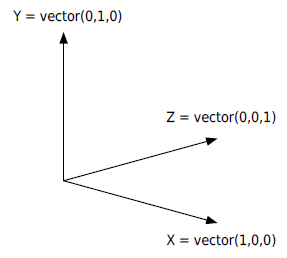


# Test Failures and Implementation Notes

The following test cases are failing at the moment

- Chapter 6, Scenario: Computing the normal on a transformed sphere
- Chapter 9, Scenario: Computing the normal on a transformed shape
- Chapter 15, Preparing the normal on a smooth triangle

The failure in the test from Chapter 9 was repaired. It only affected processing of test shapes anyway. The failure in Chapter 15 is because the code itself remains incomplete and has not yet been incorporated into the main code notebook.


The following changes were made in the course of development or at the end of development.

- Canvas dimensioning changed from ```width height ⍴``` to ```height width ⍴```
- The lighting function was checking for the number of arguments given to avoid test rewrite, but now expects all required arguments

# Bugs and Problems
Currentlt the demo scene for Chapter 11 doesn't produce a correct result when refraction is included in color computation. Specifically, the four background balls appear white instead of their assigned colors. They appear correctly when EVAL_REFRACTION is set to FALSE. I thought it might be due to returning two identical hits for Plane (and other) shapes, but removing the walls didn't help.

# Workspace Management
I can load and save a workspace, which may be the means by which I can separate notebooks containing test cases from a code development notebook. One thing seems notable; reducing the number of cells in a notebook reduces the time it takes to load the notebook. I've been combining multiple related test cases into a single markdown cell and their implementation in another code cell. Well worth continuing to do so.

After executing the previous cell with test related functions I would load my workspace containing the ray tracer code to test..

In [1]:
⊃1 ⎕NPARTS ''
)WSID rtcode_ws
)load rtcode_ws
)fns
)vars

C:/Users/Mark/Jupyter/

was

.\rtcode_ws.dws saved Wed Mar  6 16:58:35 2019
FILE NAME ERROR: Unable to open file ("The system cannot find the file specified.")
      hereDir←⊃⎕NPARTS ⎕WSID ⋄ (⍎{1=≡⍵:⍵ ⋄ ⊃⍵}2 ⎕FIX'file://',hereDir,'init.dyalog')hereDir ⋄ ⎕WSID←''
                                                ∧


PutText camera canvas canvas_to_ppm check_axis check_cap check_cap2 checker_pattern color_at 
compute_n1n2 cone_intersect cone_normal_at cross cube_intersect cube_normal_at cylinder_intersect 
cylinder_normal_at default_world dot flatten_group gradient_pattern group_intersect hit identity
intersect intersect_world intersection intersections is_shadowed lighting magnitude normal_at
normalize pattern_at pattern_at_shape plane_intersect plane_normal_at point point_light position
prepare_computations ray ray_for_pixel reflect reflected_color refracted_color render ring_pattern rotation_x
rotation_y rotation_z savePPM scaling schlick shade_hit shearing sphere_intersect 
sphere_normal_at stripe_pattern transform translation triangle vector view_transform

EPSILON EVAL_REFLECTION EVAL_REFRACTION FALSE INFINITY MAX_RECURSION RECURSE TRUE black camera_fview 
camera_halfh camera_halfw camera_hsize camera_psize camera_transform camera_vsize cone 
cone_closed cone_maximum cone_minimum cube cylinder cylinder_closed cylinder_maximum 
cylinder_minimum glass glass_sphere group group_members hereDir hit_distance hit_eyev hit_inside
hit_n1 hit_n2 hit_normalv hit_object hit_overpt hit_point hit_reflectv hit_underpt identity4
light_color light_point material material_ambient material_color material_diffuse 
material_pattern material_reflective material_refractive material_shininess material_specular 
material_transparency obj_material obj_tag obj_transform pat_checker pat_gradient pat_ring pat_stripe
pat_test pattern_color1 pattern_color2 pattern_transform pattern_type plane ray_direction ray_origin
shape_cone shape_cube shape_cylinder shape_group shape_plane shape_smtriangle shape_sphere 
shape_test shape_triangle sphere test_pattern test_shape triangle_edges triangle_normal triangle_points 
white world

It's also worthwhile loading some Dyalog utilities.

In [2]:
⍝)copy display

Should I need to debug code within the regular Dyalog GUI, I can save my test workspace from here.

In [3]:
⍝)wsid debug
⍝)save 

# Preliminaries
Let's create a few functions that can be used to simplify testing. The *yesno* function will compare its left and right arguments for equality and output a yes or no string. The function could just as easily return 'Pass' or 'Fail' instead. The *round0* function is something recommended by the book because floating point arithmetic does not always result in exact answers. The book suggests rounding values to within plus or minus 1e-5. Alternatively, if the absolute difference between two values is less than 1e-5 then the values can be considered equal.

Pseudocode for a comparison function would be
```
constant EPSILON ← 0.00001

function equal(a, b)
  if abs(a - b) < EPSILON
    return true
  else
    return false
  end if
end function
```

In [4]:
yesno←{('No' 'Yes')[1+⍺≡⍵]}
truefalse←{('False' 'True')[1+⍵]}
passfail←{('Fail' 'Pass')[1+⍵]}
round0←{1e¯5×⌊1e5×⍵}
equal←{('false' 'true')[1+EPSILON>|⍺-⍵]}
roundMN←{⍎ ⍺ ⍕ ⍵}

8 4 roundMN 1.23456 12.34

1.2346 12.34

# Chapter 1. Tuples, Points, and Vectors
APL makes it easy to deal with tuples; they are just vectors! No fancy constructor needed. Below are functions that create and manipulate tuples, and some test scenarios for them.

## APL Code Chapter 1
Introducing the code at the beginning of a series of tests seems to be backwards for Test Driven Development. In actuality though, the tests are written first, then the code is added to the cells below. Two functions mentioned in the book, *tuple* and *color*, are not needed since each are just APL vectors. The functions defined in Chapter 1 for manipulating the vector representation of points and vectors are described here.

Note that here and throughout the remaining chapters I will refer to something as a *Macro* if it is a constant or a very simple function that can be directly substituted with its code where ever it is used. The **point** and **vector** functions are a perfect example since they just append a 0 or 1 to the end of a three element vector.

* Macro **point(x,y,z)** accepts a three element tuple and appends a one to form a four element tuple representing a point
* Macro **vector(x,y,z)** accepts a three element tuple and appends a zero to form a four element tuple representing a vector
* Macro **magnitude(v)** returns the magnitude of a vector as a numeric value
* Macro **normalize(v)** returns a scaled vector of the input vector such that the return vector has a magnitude of 1
* Macro **dot(v,v)** computes the dot product of two vector inputs giving a scalar result
* Function **cross(v,v)** computes the cross product of two vectors giving a vector result

When implementing a function I will favor doing so as a D'fn rather than a traditional APL function.

## Chapter 1 Implementation
The above APL function definition names are in **bold** while their arguments are in *italic*. Function results are given following the rightward arrow.

- **point** *x y z*  → x y z 1
- **vector** *x y z* → x y z 0
- **magnitude** *vector* → numeric scalar
- **normalize** *vector* → vector
- *vector* **dot** *vector* → numeric scalar
- *vector* **cross** *vector* → vector

Although they are APL functions, *point* and *vector* can be thought of as data structures parameterized by initialization values when instantiated.

The pseudocode implementation of normalize is
```
function normalize(v)
  return tuple(v.x / magnitude(v),
               v.y / magnitude(v),
               v.z / magnitude(v),
               v.w / magnitude(v))
end function
```
The pseudocode implementation of the dot product is
```
function dot(a, b)
  return a.x * b.x +
         a.y * b.y +
         a.z * b.z +
         a.w * b.w
end function
```

The pseudocode specification for cross product is
```
function cross(a, b)
  return vector(a.y * b.z - a.z * b.y,
                a.z * b.x - a.x * b.z,
                a.x * b.y - a.y * b.x)
end function
```

## Chapter 1 Test Cases

```
Scenario: A tuple with w=1.0 is a point
  Given a ← tuple(4.3, -4.2, 3.1, 1.0)
  Then a.x = 4.3
    And a.y = -4.2
    And a.z = 3.1
    And a.w = 1.0
    And a is a point
    And a is not a vector
```

In [5]:
+a← point 4.3 ¯4.2 3.1
1 yesno a[4]

4.3 ¯4.2 3.1 1

┌───┐
│Yes│
└───┘

```
Scenario: A tuple with w=0 is a vector
  Given a ← tuple(4.3, -4.2, 3.1, 0.0)
  Then a.x = 4.3
    And a.y = -4.2
    And a.z = 3.1
    And a.w = 0.0
    And a is not a point
    And a is a vector
```

In [6]:
+a← vector 4.3 ¯4.2 3.1
0 yesno a[4]

4.3 ¯4.2 3.1 0

┌───┐
│Yes│
└───┘

```
Scenario: point() creates tuples with w=1
  Given p ← point(4, -4, 3)
  Then p = tuple(4, -4, 3, 1)
```

In [7]:
+p← point 4 ¯4 3
p yesno 4 ¯4 3 1

4 ¯4 3 1

┌───┐
│Yes│
└───┘

```
Scenario: vector() creates tuples with w=0
  Given v ← vector(4, -4, 3)
  Then v = tuple(4, -4, 3, 0)
```

In [8]:
+v← vector 4 ¯4 3
v yesno 4 ¯4 3 0

4 ¯4 3 0

┌───┐
│Yes│
└───┘

```
Scenario: Adding two tuples
  Given a1 ← tuple(3, -2, 5, 1)
    And a2 ← tuple(-2, 3, 1, 0)
   Then a1 + a2 = tuple(1, 1, 6, 1)
```

In [9]:
+a1← 3 ¯2 5 1
+a2← ¯2 3 1 0
a1+a2
1 1 6 1 yesno a1+a2

3 ¯2 5 1

¯2 3 1 0

1 1 6 1

┌───┐
│Yes│
└───┘

```
Scenario: Subtracting two points
  Given p1 ← point(3, 2, 1)
    And p2 ← point(5, 6, 7)
  Then p1 - p2 = vector(-2, -4, -6)

Scenario: Subtracting a vector from a point
  Given p ← point(3, 2, 1)
    And v ← vector(5, 6, 7)
  Then p - v = point(-2, -4, -6)

Scenario: Subtracting two vectors
  Given v1 ← vector(3, 2, 1)
    And v2 ← vector(5, 6, 7)
  Then v1 - v2 = vector(-2, -4, -6)

Scenario: Subtracting a vector from the zero vector
  Given zero ← vector(0, 0, 0)
    And v ← vector(1, -2, 3)
  Then zero - v = vector(-1, 2, -3)

Scenario: Negating a tuple
  Given a ← tuple(1, -2, 3, -4)
  Then -a = tuple(-1, 2, -3, 4)
```

In [10]:
p1← point 3 2 1
p2← point 5 6 7
p1-p2
(vector ¯2 ¯4 ¯6) yesno p1-p2
⍝
p← point 3 2 1
v← vector 5 6 7
p - v
(point ¯2 ¯4 ¯6) yesno p - v
⍝
v1← vector 3 2 1
v2← vector 5 6 7
v1 - v2
(vector ¯2 ¯4 ¯6) yesno v1-v2
⍝
zero← vector 0 0 0
v← vector 1 ¯2 3
zero - v
(vector ¯1 2 ¯3) yesno zero-v
⍝
a← 1 ¯2 3 ¯4
-a
¯1 2 ¯3 4 yesno -a

¯2 ¯4 ¯6 0

┌───┐
│Yes│
└───┘

¯2 ¯4 ¯6 1

┌───┐
│Yes│
└───┘

¯2 ¯4 ¯6 0

┌───┐
│Yes│
└───┘

¯1 2 ¯3 0

┌───┐
│Yes│
└───┘

¯1 2 ¯3 4

┌───┐
│Yes│
└───┘

```
Scenario: Multiplying a tuple by a scalar
  Given a ← tuple(1, -2, 3, -4)
  Then a * 3.5 = tuple(3.5, -7, 10.5, -14)

Scenario: Multiplying a tuple by a fraction
  Given a ← tuple(1, -2, 3, -4)
  Then a * 0.5 = tuple(0.5, -1, 1.5, -2)

Scenario: Dividing a tuple by a scalar
  Given a ← tuple(1, -2, 3, -4)
  Then a / 2 = tuple(0.5, -1, 1.5, -2)
```

In [11]:
a← 1 ¯2 3 ¯4
a×3.5
3.5 ¯7 10.5 ¯14 yesno a×3.5
⍝
a← 1 ¯2 3 ¯4
a×0.5
0.5 ¯1 1.5 ¯2 yesno a×0.5
⍝
a← 1 ¯2 3 ¯4
a÷2
0.5 ¯1 1.5 ¯2 yesno a÷2

3.5 ¯7 10.5 ¯14

┌───┐
│Yes│
└───┘

0.5 ¯1 1.5 ¯2

┌───┐
│Yes│
└───┘

0.5 ¯1 1.5 ¯2

┌───┐
│Yes│
└───┘

```
Scenario: Computing the magnitude of vector(1, 0, 0)
  Given v ← vector(1, 0, 0)
  Then magnitude(v) = 1

Scenario: Computing the magnitude of vector(0, 1, 0)
  Given v ← vector(0, 1, 0)
  Then magnitude(v) = 1

Scenario: Computing the magnitude of vector(0, 0, 1)
  Given v ← vector(0, 0, 1)
  Then magnitude(v) = 1

Scenario: Computing the magnitude of vector(1, 2, 3)
  Given v ← vector(1, 2, 3)
  Then magnitude(v) = √14

Scenario: Computing the magnitude of vector(-1, -2, -3)
  Given v ← vector(-1, -2, -3)
  Then magnitude(v) = √14
```

In [12]:
v← vector 1 0 0
magnitude v
1 yesno magnitude v
⍝
v← vector 0 1 0
magnitude v
1 yesno magnitude v
⍝
v← vector 0 0 1
magnitude v
1 yesno magnitude v
⍝
v← vector 1 2 3
magnitude v
(14*0.5) yesno magnitude v
⍝
v← vector ¯1 ¯2 ¯3
magnitude v
(14*0.5) yesno magnitude v

1

┌───┐
│Yes│
└───┘

1

┌───┐
│Yes│
└───┘

1

┌───┐
│Yes│
└───┘

3.74166

┌───┐
│Yes│
└───┘

3.74166

┌───┐
│Yes│
└───┘

```
Scenario: Normalizing vector(4, 0, 0) gives (1, 0, 0)
  Given v ← vector(4, 0, 0)
  Then normalize(v) = vector(1, 0, 0)

Scenario: Normalizing vector(1, 2, 3)
  Given v ← vector(1, 2, 3)
                                  # vector(1/√14,   2/√14,   3/√14)
  Then normalize(v) = approximately vector(0.26726, 0.53452, 0.80178)

Scenario: The magnitude of a normalized vector
  Given v ← vector(1, 2, 3)
  When norm ← normalize(v)
  Then magnitude(norm) = 1
```

In [13]:
v← vector 4 0 0
normalize v
(vector 1 0 0) yesno normalize v
⍝
v← vector 1 2 3
normalize v
(vector (÷14*0.5) (2÷14*0.5) (3÷14*0.5)) yesno normalize v
⍝
v← vector 1 2 3
norm← normalize v
magnitude norm
1 yesno magnitude norm

1 0 0 0

┌───┐
│Yes│
└───┘

0.267261 0.534522 0.801784 0

┌───┐
│Yes│
└───┘

1

┌───┐
│Yes│
└───┘

```
Scenario: The dot product of two tuples
  Given a ← vector(1, 2, 3)
    And b ← vector(2, 3, 4)
  Then dot(a, b) = 20

Scenario: The cross product of two vectors
  Given a ← vector(1, 2, 3)
    And b ← vector(2, 3, 4)
  Then cross(a, b) = vector(-1, 2, -1)
    And cross(b, a) = vector(1, -2, 1)
```

In [14]:
a← vector 1 2 3
b← vector 2 3 4
a dot b
20 yesno a dot b
⍝
a cross b
(vector ¯1 2 ¯1) yesno a cross b
b cross a
(vector 1 ¯2 1) yesno b cross a

20

┌───┐
│Yes│
└───┘

¯1 2 ¯1 0

┌───┐
│Yes│
└───┘

1 ¯2 1 0

┌───┐
│Yes│
└───┘

# Chapter 2. Drawing on a Canvas
This chapter focuses on representing color, a three element vector representing Red, Green and Blue color values. Each color value ranges from 0.0 to 1.0. A canvas is a matrix of color vectors, specified in terms of Height and Width. The primary functions developed in this chapter deal with a canvas and converting the canvas to a PPM image format.

The Chapter deals first with operations that can be performed on colors. These operations are necessary when dealing with transparency and reflection. The remainder of the Chapter is given over to creating a canvas and converting it to a PPM image, then saving that image to a file.

## APL Code Chapter 2
* Macro **canvas(w,h)** creates a canvas of width w, height h, initialized to color (0,0,0)
* Function **canvas_to_ppm(c)** processes a canvas and produces a text representation of a PPM graphics file
* Function **savePPM(file,ppm)** outputs a PPM result to a named file

## Implementation
- **canvas** *width height* → nested matrix of ⍴ = height width, each element being the enclosed vector (0 0 0)
- **canvas_to_ppm** *canvas* → textual representation of a PPM file
- *filename* **savePPM** *ppm* → file.ppm written to file system

Previously I used the width & height arguments to shape an array, which means width is the number of rows and height is the number of columns. This happens to match the way the author indexes a canvas by specifying x and y values in a write_pixel() function. Hence, width is x is rows, and y is height is columns. This matches the indexing form of an APL two dimensional array, specified as c[x ; y]. ***I've since reversed the dimensioning, height is rows and width is columns.*** Only a few functions and tests were affected by the change.

***Update:*** I've now implemented a canvas as an inverted matrix. A canvas is a vector whose length is equal to the height (# of rows) with each element being a vector whose length is equal to the width (# of columns) of colors. You pick the row, then the column from that row using ```row column⊃canvas```

Since a canvas is an array of colors, a color value must be enclosed before being assigned to a canvas element and disclosed when a color element is extracted. Enclosure is certain to be the source of numerous errors in development!

The implementation of **canvas_to_ppm** would probably be faster and more efficient if written as a regular procedural function with a loop to process the raveled, disclosed color elements from the canvas input. It would also result in a nested array with the same number of rows as lines of output. I may need to circle back at a later time. As implemented, it will not produce an output that matches the format given in the test scenarios.

I'm using a separate function **savePPM** to write the ppm result to a file for the moment. It could, perhaps should, be incorporated directly into the **canvas_to_ppm** function. I'm also using a preexisting function **PutText** from the *File* workspace for now. This dependency should be removed later by implementing my own file output routine.

## Chapter 2 Test Cases

```
Scenario: Colors are (red, green, blue) tuples
  Given c ← color(-0.5, 0.4, 1.7)
  Then c.red = -0.5
    And c.green = 0.4
    And c.blue = 1.7

Scenario: Adding colors
  Given c1 ← color(0.9, 0.6, 0.75)
    And c2 ← color(0.7, 0.1, 0.25)
   Then c1 + c2 = color(1.6, 0.7, 1.0)

Scenario: Subtracting colors
  Given c1 ← color(0.9, 0.6, 0.75)
    And c2 ← color(0.7, 0.1, 0.25)
   Then c1 - c2 = color(0.2, 0.5, 0.5)

Scenario: Multiplying a color by a scalar
  Given c ← color(0.2, 0.3, 0.4)
  Then c * 2 = color(0.4, 0.6, 0.8)

Scenario: Multiplying colors
  Given c1 ← color(1, 0.2, 0.4)
    And c2 ← color(0.9, 1, 0.1)
   Then c1 * c2 = color(0.9, 0.2, 0.04)
```

In [15]:
+c← ¯0.5 0.4 1.7
c yesno ¯0.5 0.4 1.7
⍝
c1← 0.9 0.6 0.75
c2← 0.7 0.1 0.25
c1+c2
1.6 0.7 1.0 yesno c1+c2
⍝
c1← 0.9 0.6 0.75
c2← 0.7 0.1 0.25
c1-c2
0.2 0.5 0.5 yesno c1-c2
⍝
c← 0.2 0.3 0.4
c×2
0.4 0.6 0.8 yesno c×2
⍝
c1← 1 0.2 0.4
c2← 0.9 1 0.1
c1×c2
0.9 0.2 0.04 yesno c1×c2
⍝

¯0.5 0.4 1.7

┌───┐
│Yes│
└───┘

1.6 0.7 1

┌───┐
│Yes│
└───┘

0.2 0.5 0.5

┌───┐
│Yes│
└───┘

0.4 0.6 0.8

┌───┐
│Yes│
└───┘

0.9 0.2 0.04

┌───┐
│Yes│
└───┘

```
Scenario: Creating a canvas
  Given c ← canvas(10, 20)
  Then c.width = 10
    And c.height = 20
    And every pixel of c is color(0, 0, 0)
```

In [18]:
c← canvas 10 20
⍴c
⍴⊃c[1]
20 yesno ⊃⍴c
10 yesno ⊃⍴⊃c[1]
0 yesno ∨/⊃,/⊃,/c

20

10

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Writing pixels to a canvas
  Given c ← canvas(10, 20)
    And red ← color(1, 0, 0)
  When write_pixel(c, 2, 3, red)
  Then pixel_at(c, 2, 3) = red
```

In [29]:
c← canvas 10 20
red← 1 0 0
(4 3⊃c)← red
4 3⊃c
red yesno 4 3⊃c

1 0 0

┌───┐
│Yes│
└───┘

```
Scenario: Constructing the PPM header
  Given c ← canvas(5, 3)
  When ppm ← canvas_to_ppm(c)
  Then lines 1-3 of ppm are
    """
    P3
    5 3
    255
    """
```

In [21]:
c← canvas 5 3
ppm← canvas_to_ppm c
ppm[1 2 3;]
⍴ppm

┌───┐
│P3 │
├───┤
│5 3│
├───┤
│255│
└───┘

4 1

```
Scenario: Constructing the PPM pixel data
  Given c ← canvas(5, 3)
    And c1 ← color(1.5, 0, 0)
    And c2 ← color(0, 0.5, 0)
    And c3 ← color(-0.5, 0, 1)
  When write_pixel(c, 0, 0, c1)
    And write_pixel(c, 2, 1, c2)
    And write_pixel(c, 4, 2, c3)
    And ppm ← canvas_to_ppm(c)
  Then lines 4-6 of ppm are
    """
    255 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 0 0 0 0 0 0 128 0 0 0 0 0 0 0
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 255
    """
```

In [30]:
c← canvas 5 3
c1← 1.5 0 0
c2← 0 0.5 0
c3← ¯0.5 0 1
(1 1⊃c)← c1
(2 3⊃c)← c2
(3 5⊃c)← c3
c
ppm← canvas_to_ppm c
ppm[4;]

┌─────────────────────────────────┬─────────────────────────────────┬──────────────────────────────────┐
│┌───────┬─────┬─────┬─────┬─────┐│┌─────┬─────┬───────┬─────┬─────┐│┌─────┬─────┬─────┬─────┬────────┐│
││1.5 0 0│0 0 0│0 0 0│0 0 0│0 0 0│││0 0 0│0 0 0│0 0.5 0│0 0 0│0 0 0│││0 0 0│0 0 0│0 0 0│0 0 0│¯0.5 0 1││
│└───────┴─────┴─────┴─────┴─────┘│└─────┴─────┴───────┴─────┴─────┘│└─────┴─────┴─────┴─────┴────────┘│
└─────────────────────────────────┴─────────────────────────────────┴──────────────────────────────────┘

┌────────────────────────────────────────────────────────────┐
│ 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0│
│ 0 0 0 0 0 0 0 128 0 0 0 0 0 0 0│
│ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255│
└────────────────────────────────────────────────────────────┘

```
Scenario: Splitting long lines in PPM files
  Given c ← canvas(10, 2)
  When every pixel of c is set to color(1, 0.8, 0.6)
    And ppm ← canvas_to_ppm(c)
  Then lines 4-7 of ppm are
    """
    255 204 153 255 204 153 255 204 153 255 204 153 255 204 153 255 204
    153 255 204 153 255 204 153 255 204 153 255 204 153
    255 204 153 255 204 153 255 204 153 255 204 153 255 204 153 255 204
    153 255 204 153 255 204 153 255 204 153 255 204 153
    """
```

In [31]:
c← canvas 10 2
c[(⍳2)∘.,⍳10]← ⊂1 0.8 0.6
ppm← canvas_to_ppm c
ppm[4;]
⍴ppm[4;]

┌────────────────────────────────────────────────────────────┐
│ 255 204 153 255 204 153 255 204 153 255 204 153 255 204 153│
│ 255 204 153 255 204 153 255 204 153 255 204 153 255 204 153│
│ 255 204 153 255 204 153 255 204 153 255 204 153 255 204 153│
│ 255 204 153 255 204 153 255 204 153 255 204 153 255 204 153│
└────────────────────────────────────────────────────────────┘

1

```
Scenario: PPM files are terminated by a newline
  Given c ← canvas(5, 3)
  When ppm ← canvas_to_ppm(c)
  Then the last character of ppm is a newline
```

# Chapter 3. Matrices
This section is where APL shines. A good deal of the chapter is devoted to constructing the means to invert a matrix. That code will not be written or tested thanks to the APL *domino* (⌹) function.

## APL Code Chapter 3
Functions implemented in this chapter include
* Function **identity(n)** that returns an n×n identity matrix
* Data structure *identity4* that is a 4×4 identity matrix

## Implementation

- **identity** *n* → n×n identity matrix
- *identity4* → 4×4 identity matrix

## Chapter 3 Test Cases
Throughout the book the author assumes vectors and matrices are indexed starting at zero, but APL by default indexes arrays beginning with 1.

```
Scenario: A 2x2 matrix ought to be representable
  Given the following 2x2 matrix M:
    | -3 |  5 |
    |  1 | -2 |
  Then M[0,0] = -3
    And M[0,1] = 5
    And M[1,0] = 1
    And M[1,1] = -2

Scenario: A 3x3 matrix ought to be representable
  Given the following 3x3 matrix M:
    | -3 |  5 |  0 |
    |  1 | -2 | -7 |
    |  0 |  1 |  1 |
  Then M[0,0] = -3
    And M[1,1] = -2
    And M[2,2] = 1
```

In [21]:
+m← 2 2⍴ ¯3 5 1 ¯2
¯3 5 1 ¯2 yesno m[(1 1) (1 2) (2 1) (2 2)]
⍝
+m←3 3⍴ ¯3 5 0 1 ¯2 ¯7 0 1 1
¯3 ¯2 1 yesno m[(1 1) (2 2) (3 3)]

¯3 5
 1 ¯2

┌───┐
│Yes│
└───┘

¯3 5 0
 1 ¯2 ¯7
 0 1 1

┌───┐
│Yes│
└───┘

```
Scenario: Matrix equality with identical matrices
  Given the following matrix A:
      | 1 | 2 | 3 | 4 |
      | 5 | 6 | 7 | 8 |
      | 9 | 8 | 7 | 6 |
      | 5 | 4 | 3 | 2 |
    And the following matrix B:
      | 1 | 2 | 3 | 4 |
      | 5 | 6 | 7 | 8 |
      | 9 | 8 | 7 | 6 |
      | 5 | 4 | 3 | 2 |
  Then A = B

Scenario: Matrix equality with different matrices
  Given the following matrix A:
      | 1 | 2 | 3 | 4 |
      | 5 | 6 | 7 | 8 |
      | 9 | 8 | 7 | 6 |
      | 5 | 4 | 3 | 2 |
    And the following matrix B:
      | 2 | 3 | 4 | 5 |
      | 6 | 7 | 8 | 9 |
      | 8 | 7 | 6 | 5 |
      | 4 | 3 | 2 | 1 |
  Then A != B
```

In [22]:
A← 4 4⍴ 1 2 3 4 5 6 7 8 9 8 7 6 5 4 3 2
B← 4 4⍴ 1 2 3 4 5 6 7 8 9 8 7 6 5 4 3 2
1 yesno A≡B
⍝
B← 4 4⍴ 2 3 4 5 6 7 8 9 8 7 6 5 4 3 2 1
1 yesno A≢B

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Multiplying two matrices
  Given the following matrix A:
      | 1 | 2 | 3 | 4 |
      | 5 | 6 | 7 | 8 |
      | 9 | 8 | 7 | 6 |
      | 5 | 4 | 3 | 2 |
    And the following matrix B:
      | -2 | 1 | 2 |  3 |
      |  3 | 2 | 1 | -1 |
      |  4 | 3 | 6 |  5 |
      |  1 | 2 | 7 |  8 |
  Then A * B is the following 4x4 matrix:
      | 20|  22 |  50 |  48 |
      | 44|  54 | 114 | 108 |
      | 40|  58 | 110 | 102 |
      | 16|  26 |  46 |  42 |

Scenario: A matrix multiplied by a tuple
  Given the following matrix A:
      | 1 | 2 | 3 | 4 |
      | 2 | 4 | 4 | 2 |
      | 8 | 6 | 4 | 1 |
      | 0 | 0 | 0 | 1 |
    And b ← tuple(1, 2, 3, 1)
  Then A * b = tuple(18, 24, 33, 1)

Scenario: Multiplying a matrix by the identity matrix
  Given the following matrix A:
    | 0 | 1 |  2 |  4 |
    | 1 | 2 |  4 |  8 |
    | 2 | 4 |  8 | 16 |
    | 4 | 8 | 16 | 32 |
  Then A * identity_matrix = A

Scenario: Multiplying the identity matrix by a tuple
  Given a ← tuple(1, 2, 3, 4)
  Then identity_matrix * a = a
```

In [23]:
A← 4 4⍴ 1 2 3 4 5 6 7 8 9 8 7 6 5 4 3 2
B← 4 4⍴ ¯2 1 2 3 3 2 1 ¯1 4 3 6 5 1 2 7 8
A +.× B
(A +.× B) yesno 4 4⍴ 20 22 50 48 44 54 114 108 40 58 110 102 16 26 46 42
⍝
A← 4 4⍴ 1 2 3 4 2 4 4 2 8 6 4 1 0 0 0 1
b← 1 2 3 1
A +.× b
18 24 33 1 yesno A +.× b
⍝
A← 4 4⍴ 0 1 2 4 1 2 4 8 2 4 8 16 4 8 16 32
A +.× identity4
A yesno A +.× identity4
⍝
a← 1 2 3 4
identity4 +.× a
a yesno identity4 +.× a

20 22 50 48
44 54 114 108
40 58 110 102
16 26 46 42

┌───┐
│Yes│
└───┘

18 24 33 1

┌───┐
│Yes│
└───┘

0 1 2 4
1 2 4 8
2 4 8 16
4 8 16 32

┌───┐
│Yes│
└───┘

1 2 3 4

┌───┐
│Yes│
└───┘

```
Scenario: Transposing a matrix
  Given the following matrix A:
    | 0 | 9 | 3 | 0 |
    | 9 | 8 | 0 | 8 |
    | 1 | 8 | 5 | 3 |
    | 0 | 0 | 5 | 8 |
  Then transpose(A) is the following matrix:
    | 0 | 9 | 1 | 0 |
    | 9 | 8 | 8 | 0 |
    | 3 | 0 | 5 | 5 |
    | 0 | 8 | 3 | 8 |

Scenario: Transposing the identity matrix
  Given A ← transpose(identity_matrix)
  Then A = identity_matrix
```

In [24]:
A← 4 4⍴ 0 9 3 0 9 8 0 8 1 8 5 3 0 0 5 8
⍉A
(⍉A) yesno 4 4⍴ 0 9 1 0 9 8 8 0 3 0 5 5 0 8 3 8
⍝
⍉ identity4
identity4 yesno ⍉identity4

0 9 1 0
9 8 8 0
3 0 5 5
0 8 3 8

┌───┐
│Yes│
└───┘

1 0 0 0
0 1 0 0
0 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

```
Scenario: Calculating the inverse of another matrix
  Given the following 4x4 matrix A:
    |  8 | -5 |  9 |  2 |
    |  7 |  5 |  6 |  1 |
    | -6 |  0 |  9 |  6 |
    | -3 |  0 | -9 | -4 |
  Then inverse(A) is the following 4x4 matrix:
    | -0.15385 | -0.15385 | -0.28205 | -0.53846 |
    | -0.07692 |  0.12308 |  0.02564 |  0.03077 |
    |  0.35897 |  0.35897 |  0.43590 |  0.92308 |
    | -0.69231 | -0.69231 | -0.76923 | -1.92308 |

Scenario: Calculating the inverse of a third matrix
  Given the following 4x4 matrix A:
    |  9 |  3 |  0 |  9 |
    | -5 | -2 | -6 | -3 |
    | -4 |  9 |  6 |  4 |
    | -7 |  6 |  6 |  2 |
  Then inverse(A) is the following 4x4 matrix:
    | -0.04074 | -0.07778 |  0.14444 | -0.22222 |
    | -0.07778 |  0.03333 |  0.36667 | -0.33333 |
    | -0.02901 | -0.14630 | -0.10926 |  0.12963 |
    |  0.17778 |  0.06667 | -0.26667 |  0.33333 |

Scenario: Multiplying a product by its inverse
  Given the following 4x4 matrix A:
      |  3 | -9 |  7 |  3 |
      |  3 | -8 |  2 | -9 |
      | -4 |  4 |  4 |  1 |
      | -6 |  5 | -1 |  1 |
    And the following 4x4 matrix B:
      |  8 |  2 |  2 |  2 |
      |  3 | -1 |  7 |  0 |
      |  7 |  0 |  5 |  4 |
      |  6 | -2 |  0 |  5 |
    And C ← A * B
  Then C * inverse(B) = A
```

In [25]:
A← 4 4⍴ 8 ¯5 9 2 7 5 6 1 ¯6 0 9 6 ¯3 0 ¯9 ¯4
4 4⍴ 9 5 roundMN ,⌹A
Z← ¯0.15385 ¯0.15385 ¯0.28205 ¯0.53846 ¯0.07692 0.12308 0.02564 0.03077
Z,← 0.35897 0.35897 0.43590 0.92308 ¯0.69231 ¯0.69231 ¯0.76923 ¯1.92308
Z yesno 9 5 roundMN ,⌹A
⍝
A← 4 4⍴ 9 3 0 9 ¯5 ¯2 ¯6 ¯3 ¯4 9 6 4 ¯7 6 6 2
4 4⍴ 9 5 roundMN ,⌹A
Z← ¯0.04074 ¯0.07778 0.14444 ¯0.22222 ¯0.07778 0.03333 0.36667 ¯0.33333
Z,← ¯0.02901 ¯0.14630 ¯0.10926 0.12963 0.17778 0.06667 ¯0.26667 0.33333
Z yesno 9 5 roundMN ,⌹A
⍝
A← 4 4⍴ 3 ¯9 7 3 3 ¯8 2 ¯9 ¯4 4 4 1 ¯6 5 ¯1 1
B← 4 4⍴ 8 2 2 2 3 ¯1 7 0 7 0 5 4 6 ¯2 0 5
C← A +.× B
C +.× ⌹B
A yesno C +.× ⌹B

¯0.15385 ¯0.15385 ¯0.28205 ¯0.53846
¯0.07692 0.12308 0.02564 0.03077
 0.35897 0.35897 0.4359 0.92308
¯0.69231 ¯0.69231 ¯0.76923 ¯1.92308

┌───┐
│Yes│
└───┘

¯0.04074 ¯0.07778 0.14444 ¯0.22222
¯0.07778 0.03333 0.36667 ¯0.33333
¯0.02901 ¯0.1463 ¯0.10926 0.12963
 0.17778 0.06667 ¯0.26667 0.33333

┌───┐
│Yes│
└───┘

3 ¯9 7 3
 3 ¯8 2 ¯9
¯4 4 4 1
¯6 5 ¯1 1

┌───┐
│Yes│
└───┘

# Chapter 4. Matrix Transformations
This chapter introduces the idea of the transform matrix. Multiplying a 4 by 4 matrix and a 4-tuple point or vector can translate, scale, rotate or some other alteration of the original point or vector. The author doesn't really explain the purpose of the transform matrix or how it affects the design of the ray tracer. Basically, all shapes will be defined as centered at the origin and of unit size. Each shape will have its own transform matrix, and that matrix will be used to move and reshape the object to fit a scene. The transform matrix will be the result of chaining a series of transform matrices defined in this chapter.

When chaining operations on an object, ordering is important. If A, B, and C are transformation matrices and O is an object, then a chain of operations would be represented as

C * (B * (A * O)

which just happens to be the order for the APL expression

C +.× B +.× A +.× O

The author also notes that matrix multiplication is associative *but not commutative*, hence the order in which the transformations are applied is important.

## APL Code Chapter 4
Functions implemented in this chapter include
* Function **translation(x,y,z)** that returns a 4×4 translation matrix
* Function **scaling(x,y,z)** that returns a 4×4 scaling matrix
* Function **rotation_x(angle)** that returns a 4×4 rotation matrix about the x axis
* Function **rotation_y(angle)** that returns a 4×4 rotation matrix about the y axis
* Function **rotation_z(angle)** that returns a 4×4 rotation matrix about the z axis
* Function **shearing(xy,xz,yx,yz,zx,zy)** that returns a 4×4 shearing matrix

Although implemented as APL functions, these could just as easily be considered data structures with initialization values. For now they will probably end up in the Functions part of the code section.

## Chapter 4 Implementation

- **translation** *x y z* → 4×4 translation matrix
- **scaling** *x y z* → 4×4 scaling matrix
- **rotation_x** *angle* → 4×4 rotation matrix about the x axis
- **rotation_y** *angle* → 4×4 rotation matrix about the y axis
- **rotation_z** *angle* → 4×4 rotation matrix about the z axis
- **shearing** *xy xz yx yz zx zy* → 4×4 shearing matrix

## Chapter 4 Test Cases

```
Scenario: Multiplying by a translation matrix
  Given transform ← translation(5, -3, 2)
    And p ← point(-3, 4, 5)
   Then transform * p = point(2, 1, 7)

Scenario: Multiplying by the inverse of a translation matrix
  Given transform ← translation(5, -3, 2)
    And inv ← inverse(transform)
    And p ← point(-3, 4, 5)
   Then inv * p = point(-8, 7, 3)

Scenario: Translation does not affect vectors
  Given transform ← translation(5, -3, 2)
    And v ← vector(-3, 4, 5)
   Then transform * v = v
```

In [26]:
t← translation 5 ¯3 2
p← point ¯3 4 5
t +.× p
(point 2 1 7) yesno t +.× p
⍝
t← translation 5 ¯3 2
inv← ⌹t
p← point ¯3 4 5
inv +.× p
p⌹t        ⍝ Equivalent to above
(point ¯8 7 3) yesno inv +.× p
⍝
t← translation 5 ¯3 2
v← vector ¯3 4 5
t +.× v
v yesno t +.× v

2 1 7 1

┌───┐
│Yes│
└───┘

¯8 7 3 1

¯8 7 3 1

┌───┐
│Yes│
└───┘

¯3 4 5 0

┌───┐
│Yes│
└───┘

```
Scenario: A scaling matrix applied to a point
  Given transform ← scaling(2, 3, 4)
    And p ← point(-4, 6, 8)
   Then transform * p = point(-8, 18, 32)

Scenario: A scaling matrix applied to a vector
  Given transform ← scaling(2, 3, 4)
    And v ← vector(-4, 6, 8)
   Then transform * v = vector(-8, 18, 32)

Scenario: Multiplying by the inverse of a scaling matrix
  Given transform ← scaling(2, 3, 4)
    And inv ← inverse(transform)
    And v ← vector(-4, 6, 8)
   Then inv * v = vector(-2, 2, 2)

Scenario: Reflection is scaling by a negative value
  Given transform ← scaling(-1, 1, 1)
    And p ← point(2, 3, 4)
   Then transform * p = point(-2, 3, 4)
```

In [27]:
t← scaling 2 3 4
p← point ¯4 6 8
t +.× p
(point ¯8 18 32) yesno t +.× p
⍝
t← scaling 2 3 4
v← vector ¯4 6 8
t +.× v
(vector ¯8 18 32) yesno t +.× v
⍝
t← scaling 2 3 4
inv← ⌹t
v← vector ¯4 6 8
inv +.× v
v⌹t           ⍝ Equivalent to above
(vector ¯2 2 2) yesno inv +.× v
⍝
t← scaling ¯1 1 1
p← point 2 3 4
t +.× p
(point ¯2 3 4) yesno t +.× p

¯8 18 32 1

┌───┐
│Yes│
└───┘

¯8 18 32 0

┌───┐
│Yes│
└───┘

¯2 2 2 0

¯2 2 2 0

┌───┐
│Yes│
└───┘

¯2 3 4 1

┌───┐
│Yes│
└───┘

```
Scenario: Rotating a point around the x axis
  Given p ← point(0, 1, 0)
    And half_quarter ← rotation_x(π / 4)
    And full_quarter ← rotation_x(π / 2)
  Then half_quarter * p = point(0, √2/2, √2/2)
    And full_quarter * p = point(0, 0, 1)

Scenario: The inverse of an x-rotation rotates in the opposite direction
  Given p ← point(0, 1, 0)
    And half_quarter ← rotation_x(π / 4)
    And inv ← inverse(half_quarter)
  Then inv * p = point(0, √2/2, -√2/2)

Scenario: Rotating a point around the y axis
  Given p ← point(0, 0, 1)
    And half_quarter ← rotation_y(π / 4)
    And full_quarter ← rotation_y(π / 2)
  Then half_quarter * p = point(√2/2, 0, √2/2)
    And full_quarter * p = point(1, 0, 0)

Scenario: Rotating a point around the z axis
  Given p ← point(0, 1, 0)
    And half_quarter ← rotation_z(π / 4)
    And full_quarter ← rotation_z(π / 2)
  Then half_quarter * p = point(-√2/2, √2/2, 0)
    And full_quarter * p = point(-1, 0, 0)
```

In [28]:
⍝ Rotating a point around the x axis
p← point 0 1 0
hq← rotation_x ○ 0.25
fq← rotation_x ○ 0.5
hq +.× p
(point 0 (0.5×2*0.5) (0.5×2*0.5)) yesno hq +.× p
fq +.× p
(point 0 0 1) yesno round0 fq +.× p
⍝ The inverse of an x-rotation rotates in the opposite direction
p← point 0 1 0
hq← rotation_x ○ 0.25
inv← ⌹hq
inv +.× p
p⌹hq       ⍝ Equivalent to above
(point 0 (0.5×2*0.5) (¯0.5×2*0.5)) yesno inv +.× p
⍝ Rotating a point around the y axis
p← point 0 0 1
hq← rotation_y ○ 0.25
fq← rotation_y ○ 0.5
hq +.× p
(point (0.5×2*0.5) 0 (0.5×2*0.5)) yesno hq +.× p
fq +.× p
(point 1 0 0) yesno round0 fq +.× p
⍝ Rotating a point around the z axis
p← point 0 1 0
hq← rotation_z ○ 0.25
fq← rotation_z ○ 0.5
hq +.× p
(point (¯0.5×2*0.5) (0.5×2*0.5) 0) yesno hq +.× p
fq +.× p
(point ¯1 0 0) yesno round0 fq +.× p

0 0.707107 0.707107 1

┌───┐
│Yes│
└───┘

0 6.12323E¯17 1 1

┌───┐
│Yes│
└───┘

0 0.707107 ¯0.707107 1

0 0.707107 ¯0.707107 1

┌───┐
│Yes│
└───┘

0.707107 0 0.707107 1

┌───┐
│Yes│
└───┘

1 0 6.12323E¯17 1

┌───┐
│Yes│
└───┘

¯0.707107 0.707107 0 1

┌───┐
│Yes│
└───┘

¯1 6.12323E¯17 0 1

┌───┐
│Yes│
└───┘

```
Scenario: A shearing transformation moves x in proportion to y
  Given transform ← shearing(1, 0, 0, 0, 0, 0)
    And p ← point(2, 3, 4)
  Then transform * p = point(5, 3, 4)

Scenario: A shearing transformation moves x in proportion to z
  Given transform ← shearing(0, 1, 0, 0, 0, 0)
    And p ← point(2, 3, 4)
  Then transform * p = point(6, 3, 4)

Scenario: A shearing transformation moves y in proportion to x
  Given transform ← shearing(0, 0, 1, 0, 0, 0)
    And p ← point(2, 3, 4)
  Then transform * p = point(2, 5, 4)

Scenario: A shearing transformation moves y in proportion to z
  Given transform ← shearing(0, 0, 0, 1, 0, 0)
    And p ← point(2, 3, 4)
  Then transform * p = point(2, 7, 4)

Scenario: A shearing transformation moves z in proportion to x
  Given transform ← shearing(0, 0, 0, 0, 1, 0)
    And p ← point(2, 3, 4)
  Then transform * p = point(2, 3, 6)

Scenario: A shearing transformation moves z in proportion to y
  Given transform ← shearing(0, 0, 0, 0, 0, 1)
    And p ← point(2, 3, 4)
  Then transform * p = point(2, 3, 7)
```

In [29]:
⍝ A shearing transformation moves x in proportion to y
t← shearing 1 0 0 0 0 0
p← point 2 3 4
t +.× t
(point 5 3 4) yesno t +.× p
⍝ A shearing transformation moves x in proportion to z
t← shearing 0 1 0 0 0 0
p← point 2 3 4
t +.× t
(point 6 3 4) yesno t +.× p
⍝ A shearing transformation moves y in proportion to x
t← shearing 0 0 1 0 0 0
p← point 2 3 4
t +.× t
(point 2 5 4) yesno t +.× p
⍝ A shearing transformation moves y in proportion to z
t← shearing 0 0 0 1 0 0
p← point 2 3 4
t +.× t
(point 2 7 4) yesno t +.× p
⍝ A shearing transformation moves z in proportion to x
t← shearing 0 0 0 0 1 0
p← point 2 3 4
t +.× t
(point 2 3 6) yesno t +.× p
⍝ A shearing transformation moves z in proportion to y
t← shearing 0 0 0 0 0 1
p← point 2 3 4
t +.× t
(point 2 3 7) yesno t +.× p

1 2 0 0
0 1 0 0
0 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

1 0 2 0
0 1 0 0
0 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

1 0 0 0
2 1 0 0
0 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

1 0 0 0
0 1 2 0
0 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

1 0 0 0
0 1 0 0
2 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

1 0 0 0
0 1 0 0
0 2 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

```
Scenario: Individual transformations are applied in sequence
  Given p ← point(1, 0, 1)
    And A ← rotation_x(π / 2)
    And B ← scaling(5, 5, 5)
    And C ← translation(10, 5, 7)
  # apply rotation first
  When p2 ← A * p
  Then p2 = point(1, -1, 0)
  # then apply scaling
  When p3 ← B * p2
  Then p3 = point(5, -5, 0)
  # then apply translation
  When p4 ← C * p3
  Then p4 = point(15, 0, 7)

Scenario: Chained transformations must be applied in reverse order
  Given p ← point(1, 0, 1)
    And A ← rotation_x(π / 2)
    And B ← scaling(5, 5, 5)
    And C ← translation(10, 5, 7)
  When T ← C * B * A
  Then T * p = point(15, 0, 7)
```

In [30]:
⍝ Individual transformations are applied in sequence
p← point 1 0 1
A← rotation_x ○ 0.5
B← scaling 5 5 5
C← translation 10 5 7
+p2← A +.× p
(round0 p2) yesno point 1 ¯1 0
+p3← B +.× p2
(round0 p3) yesno point 5 ¯5 0
+p4← C +.× p3
p4 yesno point 15 0 7
⍝ Chained transformations must be applied in reverse order
T← C +.× B +.× A
T +.× p
(T +.× p) yesno point 15 0 7

1 ¯1 6.12323E¯17 1

┌───┐
│Yes│
└───┘

5 ¯5 3.06162E¯16 1

┌───┐
│Yes│
└───┘

15 0 7 1

┌───┐
│Yes│
└───┘

15 0 7 1

┌───┐
│Yes│
└───┘

# Chapter 5. Ray/Sphere Intersections
This chapter marks the end of the basic support functions and the beginnings of an actual ray tracer. This chapter is all about casting rays and finding intersections with objects in a scene. This is also the point where PPM files are created and viewed to confirm the code is operating correctly.

One thing that becomes obvious with this and the previous Chapter is that a scene is not created by scaling and translating a set of objects as one might expect. Instead, standard objects are created and then given a transformation matrix that is not applied to itself in world space, but rather to rays instead. An interesting mirror image of what one might visualize in a scene.

This is also the main beginning of the author defining and redefining data structures such as Sphere and functions such as **normal_at**. I'll apply the lessons of my previous pass through the book chapters so I can reduce some of the work the authors' style imposes.

## APL Code Chapter 5
Functions implemented in this chapter include
* Macro **ray(origin,direction)** that returns a ray representation
* Constant **sphere** that returns a sphere object at origin (0,0,0) with radius 1
* Function **position(ray,t)** that returns a point at a given distance t from ray origin
* Function **discriminant(s,r)** that returns a value to indicate whether a ray intersects a sphere
* Function **transform(r,m)** applies the transformation matrix m to the components of ray r
* Function **intersect(s,r)** that returns the set of intersection points between sphere s and ray r
* Macro **intersection(t,object)** encasulates an object and a distance t
* Function **intersections(intersection list)** yields a sorted list of intersection objects
* Function **hit(list)** tests a list of intersections and returns the lowest positive distance or null

Note that APL functions designated as "Macros" could easily be replaced wherever used by the code in the function body itself. The *sphere* structure will have additional attributes added over the course of this and other chapters. Knowing that there will eventually be a class of objects besides the sphere, the first element of an object mixed vector will be a tag field identifying what kind of object it is.

Pseudo-code for the various functions are as follows

```
function position(ray, t)
  return ray.origin + ray.direction * t
end function
```
The author over the course of the next few chapters will expand upon the attributes of an *intersection* until it becomes what he refers to as a *hit*.
```
function intersect(sphere, ray)
  # the vector from the sphere's center, to the ray origin
  # remember: the sphere is centered at the world origin
  sphere_to_ray ← ray.origin - point(0, 0, 0)

  a ← dot(ray.direction, ray.direction)
  b ← 2 * dot(ray.direction, sphere_to_ray)
  c ← dot(sphere_to_ray, sphere_to_ray) - 1

  discriminant ← b² - 4 * a * c

  if discriminant < 0 then
    return ()
  end if

  t1 ← (-b - √(discriminant)) / (2 * a)
  t2 ← (-b + √(discriminant)) / (2 * a)

  return (t1, t2)
end function
```

Typical of the author, he adds code to the beginning of the **intersect** function and makes changes to internal calculations and output as well. Rather than just a pair of distances, the result becomes a pair of object and distance pairs.
```
function intersect(sphere, ray)
  ray2 ← transform(ray, inverse(sphere.transform))

  # ...
end function
```

## Chapter 5 Implementation
The following functions are implemented in this chapter

- *point* **ray** *vector* → ⊂point ⊂vector
- *sphere* → (point 0 0 0) 1 identity4
- *ray* **position** *time* → point
- *tmatrix* **transform** *ray* → new ray
- *sphere* **intersect** *ray* → ⍬ | intersection intersection
- *object* **intersection** *distance* → ⊂object, distance
- **intersections** *intersection* ... *intersection* → sorted intersection list
- **hit** *intersection list* → intersection | ⍬

Data structures for objects are also important at this point in development. A **ray** object for example will be a two element mixed vector where the first element is the origin (*point*) and the second element is the direction (*vector*). A **sphere** object will also be a mixed vector. It will consist of just the spheres' tag and transform matrix for the moment. Origin and radius are assumed to be (0,0,0) and 1 respectively by the book when creating a sphere.

An **intersection** is a mixed array that encapsulates a general object (*sphere* for now) and a distance t (numeric). The **intersections** function creates a mixed array of **intersection** objects whose length is the number of **intersection** objects it contains. It looks as though the **intersections** function will be used in Chapter 11, Reflection and Refraction. For now I'll implement the function and optimize it away later if not needed.

When dealing with **intersections**, the book defines the *Intersect* function as returning the distance from the ray origin to the **intersection** point, then later in the chapter redefines it as a structure containing the object that was hit and the distance value. This function and the Sphere data structure illustrates the value of implementing all of the test cases ***first** before writing code*. That way you don't go back and make changes within the same chapter. The author will still force you to do so in later chapters.

The **hit** function would return the first element of a sorted intersection list from the **intersections** function or, if the intersections function is not used, it will sort and return the first non-negative distance intersection.

## Chapter 5 Test Cases

```
Scenario: Creating and querying a ray
  Given origin ← point(1, 2, 3)
    And direction ← vector(4, 5, 6)
  When r ← ray(origin, direction)
  Then r.origin = origin
    And r.direction = direction

Scenario: Computing a point from a distance
  Given r ← ray(point(2, 3, 4), vector(1, 0, 0))
  Then position(r, 0) = point(2, 3, 4)
    And position(r, 1) = point(3, 3, 4)
    And position(r, -1) = point(1, 3, 4)
    And position(r, 2.5) = point(4.5, 3, 4)
```

In [31]:
⍝ Creating and querying a ray
origin← point 1 2 3
direction← vector 4 5 6
+r← origin ray direction
(point 1 2 3) yesno ⊃r[ray_origin]
(vector 4 5 6) yesno ⊃r[ray_direction]
⍝ Computing a point from a distance
+r← (point 2 3 4) ray vector 1 0 0
r position 0
(point 2 3 4) yesno r position 0
r position 1
(point 3 3 4) yesno r position 1
r position ¯1
(point 1 3 4) yesno r position ¯1
r position 2.5
(point 4.5 3 4) yesno r position 2.5


┌───────┬───────┐
│1 2 3 1│4 5 6 0│
└───────┴───────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───────┬───────┐
│2 3 4 1│1 0 0 0│
└───────┴───────┘

2 3 4 1

┌───┐
│Yes│
└───┘

3 3 4 1

┌───┐
│Yes│
└───┘

1 3 4 1

┌───┐
│Yes│
└───┘

4.5 3 4 1

┌───┐
│Yes│
└───┘

```
Scenario: A ray intersects a sphere at two points
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And s ← sphere()
  When xs ← intersect(s, r)
  Then xs.count = 2
    And xs[0] = 4.0
    And xs[1] = 6.0

Scenario: A ray intersects a sphere at a tangent
  Given r ← ray(point(0, 1, -5), vector(0, 0, 1))
    And s ← sphere()
  When xs ← intersect(s, r)
  Then xs.count = 2
    And xs[0] = 5.0
    And xs[1] = 5.0

Scenario: A ray misses a sphere
  Given r ← ray(point(0, 2, -5), vector(0, 0, 1))
    And s ← sphere()
  When xs ← intersect(s, r)
  Then xs.count = 0

Scenario: A ray originates inside a sphere
  Given r ← ray(point(0, 0, 0), vector(0, 0, 1))
    And s ← sphere()
  When xs ← intersect(s, r)
  Then xs.count = 2
    And xs[0] = -1.0
    And xs[1] = 1.0

Scenario: A sphere is behind a ray
  Given r ← ray(point(0, 0, 5), vector(0, 0, 1))
    And s ← sphere()
  When xs ← intersect(s, r)
  Then xs.count = 2
    And xs[0] = -6.0
    And xs[1] = -4.0
```

In [32]:
⍝ A ray intersects a sphere at two points
r← (point 0 0 ¯5) ray vector 0 0 1
s← sphere
+xs← s intersect r
≢xs
2⌷¨xs
0≤2⌷¨xs
2 yesno ≢xs
1↓⊃xs[1]
4 yesno ⊃1↓⊃xs[1]
1↓⊃xs[2]
6 yesno ⊃1↓⊃xs[2]
⍝ A ray intersects a sphere at a tangent
r← (point 0 1 ¯5) ray vector 0 0 1
+xs← s intersect r
≢xs
2 yesno ≢xs
1↓⊃xs[1]
5 yesno ⊃1↓⊃xs[1]
1↓⊃xs[2]
5 yesno ⊃1↓⊃xs[2]
⍝ A ray misses a sphere
r← (point 0 2 ¯5) ray vector 0 0 1
+xs← s intersect r
≢xs
0 yesno ≢xs
⍝ A ray originates inside a sphere
r← (point 0 0 0) ray vector 0 0 1
+xs← s intersect r
≢xs
2 yesno ≢xs
1↓⊃xs[1]
¯1 yesno ⊃1↓⊃xs[1]
1↓⊃xs[2]
1 yesno ⊃1↓⊃xs[2]
⍝ A sphere is behind a ray
r← (point 0 0 5) ray vector 0 0 1
+xs← s intersect r
≢xs
2 yesno ≢xs
1↓⊃xs[1]
¯6 yesno ⊃1↓⊃xs[1]
1↓⊃xs[2]
¯4 yesno ⊃1↓⊃xs[2]


┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│4│││┌─┬───────┬─────────────────────────────┐│6││
│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

2

4 6

1 1

┌───┐
│Yes│
└───┘

4

┌───┐
│Yes│
└───┘

6

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│5│││┌─┬───────┬─────────────────────────────┐│5││
│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

2

┌───┐
│Yes│
└───┘

5

┌───┐
│Yes│
└───┘

5

┌───┐
│Yes│
└───┘

0

┌───┐
│Yes│
└───┘

┌──────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬──┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│¯1│││┌─┬───────┬─────────────────────────────┐│1││
│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴──┘│└─────────────────────────────────────────┴─┘│
└──────────────────────────────────────────────┴─────────────────────────────────────────────┘

2

┌───┐
│Yes│
└───┘

¯1

┌───┐
│Yes│
└───┘

1

┌───┐
│Yes│
└───┘

┌──────────────────────────────────────────────┬──────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬──┐│┌─────────────────────────────────────────┬──┐│
││┌─┬───────┬─────────────────────────────┐│¯6│││┌─┬───────┬─────────────────────────────┐│¯4││
│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴──┘│└─────────────────────────────────────────┴──┘│
└──────────────────────────────────────────────┴──────────────────────────────────────────────┘

2

┌───┐
│Yes│
└───┘

¯6

┌───┐
│Yes│
└───┘

¯4

┌───┐
│Yes│
└───┘

```
Scenario: An intersection encapsulates t and object
  Given s ← sphere()
  When i ← intersection(3.5, s)
  Then i.t = 3.5
    And i.object = s

Scenario: Aggregating intersections
  Given s ← sphere()
    And i1 ← intersection(1, s)
    And i2 ← intersection(2, s)
  When xs ← intersections(i1, i2)
  Then xs.count = 2
    And xs[0].t = 1
    And xs[1].t = 2

Scenario: Intersect sets the object on the intersection
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And s ← sphere()
  When xs ← intersect(s, r)
  Then xs.count = 2
    And xs[0].object = s
    And xs[1].object = s
```

In [33]:
⍝ An intersection encapsulates t and object
s← sphere
+i← s intersection 3.5
s yesno ⊃i[hit_object]
3.5 yesno i[hit_distance]
⍝ Aggregating intersections
i1← s intersection 1
i2← s intersection 2
+xs← intersections i1 i2
≢xs
2 yesno ≢xs
hit_distance⌷⊃xs[1]
1 yesno ⊃hit_distance⌷⊃xs[1]  ⍝ Double indexing
hit_distance⌷⊃xs[2]
2 yesno ⊃hit_distance⌷⊃xs[2]
⍝ Intersect sets the object on the intersection
r← (point 0 0 ¯5) ray vector 0 0 1
xs← s intersect r
≢xs
2 yesno ≢xs
⊃xs[1]
s yesno ⊃⊃xs[1]
⊃xs[2]
s yesno ⊃⊃xs[2]

┌─────────────────────────────────────────┬───┐
│┌─┬───────┬─────────────────────────────┐│3.5│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │
││ │0 0 0 1│ ││ │
│└─┴───────┴─────────────────────────────┘│ │
└─────────────────────────────────────────┴───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│1│││┌─┬───────┬─────────────────────────────┐│2││
│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

2

┌───┐
│Yes│
└───┘

1

┌───┐
│Yes│
└───┘

2

┌───┐
│Yes│
└───┘

2

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────┬─┐
│┌─┬───────┬─────────────────────────────┐│4│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │
││ │0 0 0 1│ ││ │
│└─┴───────┴─────────────────────────────┘│ │
└─────────────────────────────────────────┴─┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────┬─┐
│┌─┬───────┬─────────────────────────────┐│6│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │
││ │0 0 0 1│ ││ │
│└─┴───────┴─────────────────────────────┘│ │
└─────────────────────────────────────────┴─┘

┌───┐
│Yes│
└───┘

```
Scenario: The hit, when all intersections have positive t
  Given s ← sphere()
    And i1 ← intersection(1, s)
    And i2 ← intersection(2, s)
    And xs ← intersections(i2, i1)
  When i ← hit(xs)
  Then i = i1

Scenario: The hit, when some intersections have negative t
  Given s ← sphere()
    And i1 ← intersection(-1, s)
    And i2 ← intersection(1, s)
    And xs ← intersections(i2, i1)
  When i ← hit(xs)
  Then i = i2

Scenario: The hit, when all intersections have negative t
  Given s ← sphere()
    And i1 ← intersection(-2, s)
    And i2 ← intersection(-1, s)
    And xs ← intersections(i2, i1)
  When i ← hit(xs)
  Then i is nothing

Scenario: The hit is always the lowest non-negative intersection
  Given s ← sphere()
  And i1 ← intersection(5, s)
  And i2 ← intersection(7, s)
  And i3 ← intersection(-3, s)
  And i4 ← intersection(2, s)
  And xs ← intersections(i1, i2, i3, i4)
When i ← hit(xs)
Then i = i4
```

In [34]:
⍝ The hit, when all intersections have positive t
s← sphere
i1← s intersection 1
i2← s intersection 2
xs← intersections i2 i1
+i← hit xs
i yesno i1
⍝ The hit, when some intersections have negative t
i1← s intersection ¯1
i2← s intersection 1
xs← intersections i2 i1
+i← hit xs
i yesno i2
⍝ The hit, when all intersections have negative t
i1← s intersection ¯2
i2← s intersection ¯1
xs← intersections i2 i1
+i← hit xs
i yesno ⍬
⍝  The hit is always the lowest non-negative intersection
i1← s intersection 5
i2← s intersection 7
i3← s intersection ¯3
i4← s intersection 2
xs← intersections i1 i2 i3 i4
+i← hit xs
i yesno i4

┌─────────────────────────────────────────┬─┐
│┌─┬───────┬─────────────────────────────┐│1│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │
││ │0 0 0 1│ ││ │
│└─┴───────┴─────────────────────────────┘│ │
└─────────────────────────────────────────┴─┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────┬─┐
│┌─┬───────┬─────────────────────────────┐│1│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │
││ │0 0 0 1│ ││ │
│└─┴───────┴─────────────────────────────┘│ │
└─────────────────────────────────────────┴─┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────┬─┐
│┌─┬───────┬─────────────────────────────┐│2│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │
││ │0 0 0 1│ ││ │
│└─┴───────┴─────────────────────────────┘│ │
└─────────────────────────────────────────┴─┘

┌───┐
│Yes│
└───┘

```
Scenario: Translating a ray
  Given r ← ray(point(1, 2, 3), vector(0, 1, 0))
    And m ← translation(3, 4, 5)
  When r2 ← transform(r, m)
  Then r2.origin = point(4, 6, 8)
    And r2.direction = vector(0, 1, 0)

Scenario: Scaling a ray
  Given r ← ray(point(1, 2, 3), vector(0, 1, 0))
    And m ← scaling(2, 3, 4)
  When r2 ← transform(r, m)
  Then r2.origin = point(2, 6, 12)
    And r2.direction = vector(0, 3, 0)
```

In [35]:
⍝ Translating a ray
r← (point 1 2 3) ray vector 0 1 0
m← translation 3 4 5
+r2← m transform r
(point 4 6 8) yesno ⊃r2[ray_origin]
(vector 0 1 0) yesno ⊃r2[ray_direction]
⍝ Scaling a ray
m← scaling 2 3 4
+r2← m transform r
(point 2 6 12) yesno ⊃r2[ray_origin]
(vector 0 3 0) yesno ⊃r2[ray_direction]

┌───────┬───────┐
│4 6 8 1│0 1 0 0│
└───────┴───────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌────────┬───────┐
│2 6 12 1│0 3 0 0│
└────────┴───────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: A sphere's default transformation
  Given s ← sphere()
  Then s.transform = identity_matrix

Scenario: Changing a sphere's transformation
  Given s ← sphere()
    And t ← translation(2, 3, 4)
  When set_transform(s, t)
  Then s.transform = t

Scenario: Intersecting a scaled sphere with a ray
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And s ← sphere()
  When set_transform(s, scaling(2, 2, 2))
    And xs ← intersect(s, r)
  Then xs.count = 2
    And xs[0].t = 3
    And xs[1].t = 7

Scenario: Intersecting a translated sphere with a ray
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And s ← sphere()
  When set_transform(s, translation(5, 0, 0))
    And xs ← intersect(s, r)
  Then xs.count = 0
```

In [36]:
⍝ A sphere's default transformation
s← sphere
s[obj_transform]
identity4 yesno ⊃s[obj_transform]

⍝ Changing a sphere's transformation
t← translation 2 3 4
s[obj_transform]← ⊂t
s
t yesno ⊃s[obj_transform]

⍝ Intersecting a scaled sphere with a ray
r← (point 0 0 ¯5) ray vector 0 0 1
s← sphere
s[obj_transform]← ⊂scaling 2 2 2
+xs← s intersect r
⍴xs
3 yesno ⊃hit_distance⌷⊃xs[1]
7 yesno ⊃hit_distance⌷⊃xs[2]

⍝ Intersecting a translated sphere with a ray
s[obj_transform]← ⊂translation 5 0 0
+xs← s intersect r
⍬ yesno xs

┌───────┐
│1 0 0 0│
│0 1 0 0│
│0 0 1 0│
│0 0 0 1│
└───────┘

┌───┐
│Yes│
└───┘

┌─┬───────┬─────────────────────────────┐
│1│1 0 0 2│┌─────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 1 0 3││1 1 1│0.1│0.9│0.9│200│0│1│0││
│ │0 0 1 4│└─────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴───────┴─────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│3│││┌─┬───────┬─────────────────────────────┐│7││
│││1│2 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│2 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 2 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 2 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 2 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 2 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

2

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

# Chapter 6. Light and Shading
This chapter considers lighting, material and viewpoint. In modeling a scene, a source of light is specified. A shading algorithm is used to determine how material is illuminated. An important calculation is a *surface normal* a vector that is perpendicular to a point on an objects' surface.

## APL Code Chapter 6
The functions called for in this Chapter are
* Function **normal_at(s, p)** returns a normal vector at point p on sphere s
* Function **reflect(in, norm)** returns the reflected ray *in* about the normal *norm*
* Macro **point_light(position,intensity)** returns a point light source aggregate of position & intensity
* Constant **material** is a nested vector with default attributes for color, ambient, diffuse, specular, and shininess
* Function **lighting(m, light, position, eyev, normalv)** returns a color based on material illuminated by lighting and eye position

Note that **normal_at** is specific to a Sphere and will be renamed sphere_normal_at. The **lighting** function will take additional arguments and new internal code in later chapters.

## Chapter 6 Implementation
The implementation and arrangement of arguments for the functions are as follows

- *sphere* **normal_at** *point* → *vector*
- *vector* **reflect** *normal* → *vector*
- *point* **point_light** *color* → ⊂*point* ⊂*color*
- **material** *color* → ⊂*color* *ambient diffuse specular shininess*
- **lighting** *m light position eyev normalv* → *color*

The pseudo-code for the reflect function is

```
function reflect(in, normal)
  return in - normal * 2 * dot(in, normal)
end function
```

The pseudo-code for normal_at is

```
function normal_at(sphere, world_point)
  object_point ← inverse(sphere.transform) * world_point
  object_normal ← object_point - point(0, 0, 0)
  world_normal ← transpose(inverse(sphere.transform)) * object_normal
  world_normal.w ← 0
  return normalize(world_normal)
end function
```

The peudo-code for lighting is

```
function lighting(material, light, point, eyev, normalv)
  # combine the surface color with the light's color/intensity
  effective_color ← material.color * light.intensity

  # find the direction to the light source
  lightv ← normalize(light.position - point)

  # compute the ambient contribution
  ambient ← effective_color * material.ambient

  # light_dot_normal represents the cosine of the angle between the
  # light vector and the normal vector. A negative number means the
  # light is on the other side of the surface.
  light_dot_normal ← dot(lightv, normalv)
  if light_dot_normal < 0
    diffuse ← black
    specular ← black

  else
    # compute the diffuse contribution
    diffuse ← effective_color * material.diffuse * light_dot_normal

    # reflect_dot_eye represents the cosine of the angle between the
    # reflection vector and the eye vector. A negative number means the
    # light reflects away from the eye.
    reflectv ← reflect(-lightv, normalv)
    reflect_dot_eye ← dot(reflectv, eyev)

    if reflect_dot_eye <= 0
      specular ← black
    else
      # compute the specular contribution
      factor ← pow(reflect_dot_eye, material.shininess)
      specular ← light.intensity * material.specular * factor
    end if
  end if

  # Add the three contributions together to get the final shading
  return ambient + diffuse + specular
end function
```

## Chapter 6 Test Cases

```
Scenario: The normal on a sphere at a point on the x axis
  Given s ← sphere()
  When n ← normal_at(s, point(1, 0, 0))
  Then n = vector(1, 0, 0)

Scenario: The normal on a sphere at a point on the y axis
  Given s ← sphere()
  When n ← normal_at(s, point(0, 1, 0))
  Then n = vector(0, 1, 0)

Scenario: The normal on a sphere at a point on the z axis
  Given s ← sphere()
  When n ← normal_at(s, point(0, 0, 1))
  Then n = vector(0, 0, 1)

Scenario: The normal on a sphere at a non-axial point
  Given s ← sphere()
  When n ← normal_at(s, point(√3/3, √3/3, √3/3))
  Then n = vector(√3/3, √3/3, √3/3)

Scenario: The normal is a normalized vector
  Given s ← sphere()
  When n ← normal_at(s, point(√3/3, √3/3, √3/3))
  Then n = normalize(n)
```

In [37]:
⍝ The normal on a sphere at a point on the x axis
s← sphere
+n← s normal_at point 1 0 0
n yesno vector 1 0 0
⍝ The normal on a sphere at a point on the y axis
+n← s normal_at point 0 1 0
n yesno vector 0 1 0
⍝ The normal on a sphere at a point on the z axis
+n← s normal_at point 0 0 1
n yesno vector 0 0 1
⍝ The normal on a sphere at a non-axial point
+n← s normal_at point ((3*0.5)÷3) ((3*0.5)÷3) ((3*0.5)÷3)
n yesno vector ((3*0.5)÷3) ((3*0.5)÷3) ((3*0.5)÷3)
⍝ The normal is a normalized vector
n yesno normalize n

1 0 0 0

┌───┐
│Yes│
└───┘

0 1 0 0

┌───┐
│Yes│
└───┘

0 0 1 0

┌───┐
│Yes│
└───┘

0.57735 0.57735 0.57735 0

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Computing the normal on a translated sphere
  Given s ← sphere()
    And set_transform(s, translation(0, 1, 0))
  When n ← normal_at(s, point(0, 1.70711, -0.70711))
  Then n = vector(0, 0.70711, -0.70711)

Scenario: Computing the normal on a transformed sphere
  Given s ← sphere()
    And m ← scaling(1, 0.5, 1) * rotation_z(π/5)
    And set_transform(s, m)
  When n ← normal_at(s, point(0, √2/2, -√2/2))
  Then n = vector(0, 0.97014, -0.24254)
```

**Why does this** ***fail*** **here?**

In [38]:
⍝ Computing the normal on a translated sphere
s← sphere
s[obj_transform]← ⊂translation 0 1 0
+n← s normal_at point 0 1.70711 ¯0.70711
(9 5 roundMN n) yesno vector 0 0.70711 ¯0.70711
⍝ Computing the normal on a transformed sphere
s← sphere
s[obj_transform]← ⊂(scaling 1 0.5 1) +.× rotation_z ○ 0.2
⍝ s[obj_transform]← ⊂(rotation_z ○ 0.2) +.× scaling 1 0.5 1
+n← s normal_at point 0 (0.5×2*0.5) (¯0.5×2*0.5)
(9 5 roundMN n) yesno vector 0 0.97014 ¯0.24254

0 0.707107 ¯0.707107 0

┌───┐
│Yes│
└───┘

¯0.337895 0.930146 ¯0.143716 0

┌──┐
│No│
└──┘

```
Scenario: Reflecting a vector approaching at 45°
  Given v ← vector(1, -1, 0)
    And n ← vector(0, 1, 0)
  When r ← reflect(v, n)
  Then r = vector(1, 1, 0)

Scenario: Reflecting a vector off a slanted surface
  Given v ← vector(0, -1, 0)
    And n ← vector(√2/2, √2/2, 0)
  When r ← reflect(v, n)
  Then r = vector(1, 0, 0)
```

In [39]:
⍝ Reflecting a vector approaching at 45°
v← vector 1 ¯1 0
n← vector 0 1 0
+r← v reflect n
r yesno vector 1 1 0
⍝ Reflecting a vector off a slanted surface
v← vector 0 ¯1 0
n← vector (0.5×2*0.5) (0.5×2*0.5) 0
+r← v reflect n
(round0 r) yesno vector 1 0 0

1 1 0 0

┌───┐
│Yes│
└───┘

1 2.22045E¯16 0 0

┌───┐
│Yes│
└───┘

```
Scenario: A point light has a position and intensity
  Given intensity ← color(1, 1, 1)
    And position ← point(0, 0, 0)
  When light ← point_light(position, intensity)
  Then light.position = position
    And light.intensity = intensity
```

In [40]:
+l← (point 0 0 0) point_light 1 1 1
(point 0 0 0) yesno ⊃l[light_point]
1 1 1 yesno ⊃l[light_color]

┌───────┬─────┐
│0 0 0 1│1 1 1│
└───────┴─────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
  Given m ← material()
    And position ← point(0, 0, 0)

Scenario: The default material
  Given m ← material()
  Then m.color = color(1, 1, 1)
    And m.ambient = 0.1
    And m.diffuse = 0.9
    And m.specular = 0.9
    And m.shininess = 200.0

Scenario: A sphere has a default material
  Given s ← sphere()
  When m ← s.material
  Then m = material()

Scenario: A sphere may be assigned a material
  Given s ← sphere()
    And m ← material()
    And m.ambient ← 1
  When s.material ← m
  Then s.material = m
```

In [41]:
⍝ The default material
+m← material
1 1 1 yesno ⊃m[material_color]
0.1 yesno m[material_ambient]
0.9 yesno m[material_diffuse]
0.9 yesno m[material_specular]
200 yesno m[material_shininess]

┌─────┬───┬───┬───┬───┬─┬─┬─┐
│1 1 1│0.1│0.9│0.9│200│0│1│0│
└─────┴───┴───┴───┴───┴─┴─┴─┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
  Given m ← material()
    And position ← point(0, 0, 0)

Scenario: Lighting with the eye between the light and the surface
  Given eyev ← vector(0, 0, -1)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 0, -10), color(1, 1, 1))
  When result ← lighting(m, light, position, eyev, normalv)
  Then result = color(1.9, 1.9, 1.9)

Scenario: Lighting with the eye between light and surface, eye offset 45°
  Given eyev ← vector(0, √2/2, -√2/2)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 0, -10), color(1, 1, 1))
  When result ← lighting(m, light, position, eyev, normalv)
  Then result = color(1.0, 1.0, 1.0)

Scenario: Lighting with eye opposite surface, light offset 45°
  Given eyev ← vector(0, 0, -1)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 10, -10), color(1, 1, 1))
  When result ← lighting(m, light, position, eyev, normalv)
  Then result = color(0.7364, 0.7364, 0.7364)

Scenario: Lighting with eye in the path of the reflection vector
  Given eyev ← vector(0, -√2/2, -√2/2)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 10, -10), color(1, 1, 1))
  When result ← lighting(m, light, position, eyev, normalv)
  Then result = color(1.6364, 1.6364, 1.6364)

Scenario: Lighting with the light behind the surface
  Given eyev ← vector(0, 0, -1)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 0, 10), color(1, 1, 1))
  When result ← lighting(m, light, position, eyev, normalv)
  Then result = color(0.1, 0.1, 0.1)
```

In [42]:
m← material
p← point 0 0 0
⍝ Lighting with the eye between the light and the surface
eyev← vector 0 0 ¯1
normalv← vector 0 0 ¯1
l← (point 0 0 ¯10) point_light 1 1 1
+r← lighting m l p eyev normalv 0 sphere
r yesno 1.9 1.9 1.9
⍝ Lighting with the eye between light and surface, eye offset 45°
eyev← vector 0 (0.5×2*0.5) (¯0.5×2*0.5)
normalv← vector 0 0 ¯1
l← (point 0 0 ¯10) point_light 1 1 1
+r← lighting m l p eyev normalv 0 sphere
r yesno 1 1 1
⍝ Lighting with eye opposite surface, light offset 45°
eyev← vector 0 0 ¯1
normalv← vector 0 0 ¯1
l← (point 0 10 ¯10) point_light 1 1 1
+r← lighting m l p eyev normalv 0 sphere
(9 4 roundMN r) yesno 0.7364 0.7364 0.7364
⍝ Lighting with eye in the path of the reflection vector
eyev← vector 0 (¯0.5×2*0.5) (¯0.5×2*0.5)
normalv← vector 0 0 ¯1
l← (point 0 10 ¯10) point_light 1 1 1
+r← lighting m l p eyev normalv 0 sphere
(9 4 roundMN r) yesno 1.6364 1.6364 1.6364
⍝ Lighting with the light behind the surface
eyev← vector 0 0 ¯1
normalv← vector 0 0 ¯1
l← (point 0 0 10) point_light 1 1 1
+r← lighting m l p eyev normalv 0 sphere
r yesno 0.1 0.1 0.1

1.9 1.9 1.9

┌───┐
│Yes│
└───┘

1 1 1

┌───┐
│Yes│
└───┘

0.736396 0.736396 0.736396

┌───┐
│Yes│
└───┘

1.6364 1.6364 1.6364

┌───┐
│Yes│
└───┘

0.1 0.1 0.1

┌───┐
│Yes│
└───┘

# Chapter 7. Making a Scene
This chapter creates the parts needed to create a scene - camera, light source, and world.

## Chapter 7 APL Code
Functions implemented in this chapter include

- Data structure **world** that is initially empty but will hold objects and light sources
- Data structure **default_world** that returns a *world* object with predefined initializations
- Function **intersect_world(world, ray)** returns the list of intersections of *ray* with each object in *world*
- Function **prepare_computations(hit, ray)** returns a *hit* structure based on *intersection* and *ray*
- Function **shade_hit(world, hit)** returns a *lighting* structure for the object hit by a ray
- Function **color_at(world,ray)** returns the color value where the ray hits, or black
- Function **view_transform(from,to,up)** has the effect of orienting the eye in a given direction
- Function **camera(hsize,vsize,fview)** creates a camera of with a given background size and field of view
- Function **ray_for_pixel(c,px,py)** returns a ray that passes from a camera to a pixel's coordinates
- Function **render(c,w)** returns a canvas resulting from rendering a world by a camera

## Chapter 7 Implementation
The arguments and return values of functions are defined in APL as follows

- **world** → ⍬ ⍬
- **default_world** → (⊂⊂*point_light*) ((*sphere*) (*sphere*))
- *world* **intersect_world** *ray* → (*intersection*) (*intersection*) ...
- *hit* **prepare_computations** *ray* → augmented *hit*
- *world* **shade_hit** *ray* → *lighting*
- *world* **color_at** *ray* → *color*
- **view_transform** from to up → *transform matrix*
- **camera** hsize vsize fview → *camera object*
- *camera* **ray_for_pixel** pixel_X pixel_Y → *ray*
- *world* **render** *camera* → *canvas*

An *intersection* consists of an object and a distance in a two element mixed vector. The result of **Intersect_world** would be a vector of enclosed *intersection* objects. The **prepare_computations** takes an intersection and adds additional information to produce a *hit* data structure.

```The **intersect_world** function should iterate over all of the
objects that have been added to the world, intersecting each of them with the
ray, and aggregating the intersections into a single collection. Note that in
order for the test to pass, intersect_world() must return the intersections in
sorted order.
```

This is where I should use the intersections function?

```
function prepare_computations(intersection, ray)
  # instantiate a data structure for storing some precomputed values
  comps ← new computations data structure

  # copy the intersection's properties, for convenience
  comps.t       ← intersection.t
  comps.object  ← intersection.object

  # precompute some useful values
  comps.point   ← position(ray, comps.t)
  comps.eyev    ← -ray.direction
  comps.normalv ← normal_at(comps.object, comps.point)

  if dot(comps.normalv, comps.eyev) < 0
    comps.inside ← true
    comps.normalv ← -comps.normalv
  else
    comps.inside ← false
  end if
  return comps
end function
```

```
function shade_hit(world, comps)
  return lighting(comps.object.material,
                  world.light,
                  comps.point, comps.eyev, comps.normalv)
end function
```

```
Your color_at() function should:
  1. Call intersect_world to find the intersections of the given ray with the given world.
  2. Find the hit from the resulting intersections.
  3. Return the color black if there is no such intersection.
  4. Otherwise, precompute the necessary values with prepare_computations.
  5. Finally, call shade_hit to find the color at the hit.
```

Don't forget to use **hit** in step 2 to return only positive distances in the intersection list.

```
function view_transform(from, to, up)
  forward ← normalize(to - from)
  upn ← normalize(up)
  left ← cross(forward, upn)
  true_up ← cross(left, forward)

  orientation ← matrix( left.x,     left.y,     left.z,    0,
                         true_up.x,  true_up.y,  true_up.z, 0,
                        -forward.x, -forward.y, -forward.z, 0,
                         0,          0,          0,         1)

  return orientation * translation(-from.x, -from.y, -from.z)
end function
```

```
function camera(hsize, vsize, field_of_view)
  half_view ← tan(camera.field_of_view / 2)
  aspect ← camera.hsize / camera.vsize
  if aspect >= 1 then
    camera.half_width ← half_view
    camera.half_height ← half_view / aspect
  else
    camera.half_width ← half_view * aspect
    camera.half_height ← half_view
  end if
  camera.pixel_size ← (camera.half_width * 2) / camera.hsize
end function
```

```
function ray_for_pixel(camera, px, py)
  # the offset from the edge of the canvas to the pixel's center
  xoffset ← (px + 0.5) * camera.pixel_size
  yoffset ← (py + 0.5) * camera.pixel_size

  # the untransformed coordinates of the pixel in world-space.
  # (remember that the camera looks toward -z, so +x is to the *left*.)
  world_x ← camera.half_width - xoffset
  world_y ← camera.half_height - yoffset

  # using the camera matrix, transform the canvas point and the origin,
  # and then compute the ray's direction vector.
  # (remember that the canvas is at z=-1)
  pixel ← inverse(camera.transform) * point(world_x, world_y, -1)
  origin ← inverse(camera.transform) * point(0, 0, 0)
  direction ← normalize(pixel - origin)

  return ray(origin, direction)
end function
```

```
function render(camera, world)
  image ← canvas(camera.hsize, camera.vsize)

  for y ← 0 to camera.vsize - 1
    for x ← 0 to camera.hsize - 1
      ray ← ray_for_pixel(camera, x, y)
      color ← color_at(world, ray)
      write_pixel(image, x, y, color)
    end for
  end for

  return image
end function
```

## Chapter 7 Test Cases

```
Scenario: Creating a world
  Given w ← world()
  Then w contains no objects
    And w has no light source

Scenario: The default world
  Given light ← point_light(point(-10, 10, -10), color(1, 1, 1))
    And s1 ← sphere() with:
      | material.color     | (0.8, 1.0, 0.6)        |
      | material.diffuse   | 0.7                    |
      | material.specular  | 0.2                    |
    And s2 ← sphere() with:
      | transform | scaling(0.5, 0.5, 0.5) |
  When w ← default_world()
  Then w.light = light
    And w contains s1
    And w contains s2

Scenario: Intersect a world with a ray
  Given w ← default_world()
    And r ← ray(point(0, 0, -5), vector(0, 0, 1))
  When xs ← intersect_world(w, r)
  Then xs.count = 4
    And xs[0].t = 4
    And xs[1].t = 4.5
    And xs[2].t = 5.5
    And xs[3].t = 6
```

In [43]:
⍝ Creating a world
+w← world
⍴w[2]
⍝ The default world
+w← default_world
((point ¯10 10 ¯10) point_light 1 1 1) yesno ⊃⊃w[1]
objs← ⊃w[2]
+s1← ⊃objs[1]
m← ⊃s1[obj_material]
(0.8 1 0.6) 0.7 0.2 yesno m[material_color material_diffuse material_specular]
+s2← ⊃objs[2]
(scaling 0.5 0.5 0.5) yesno ⊃s2[obj_transform]
⍝ Intersect a world with a ray
r← (point 0 0 ¯5) ray vector 0 0 1
+xs← w intersect_world r
4 yesno ≢xs
4 yesno hit_distance⌷⊃xs[1]
4.5 yesno hit_distance⌷⊃xs[2]
5.5 yesno hit_distance⌷⊃xs[3]
6 yesno hit_distance⌷⊃xs[4]

┌┬┐
│││
└┴┘

┌──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────┐
│┌────────────────────┐│┌─────────────────────────────────────────────┬───────────────────────────────────────────────┐│
││┌────────────┬─────┐│││┌─┬───────┬─────────────────────────────────┐│┌─┬─────────────┬─────────────────────────────┐││
│││¯10 10 ¯10 1│1 1 1│││││1│1 0 0 0│┌─────────┬───┬───┬───┬───┬─┬─┬─┐│││1│0.5 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│││
││└────────────┴─────┘││││ │0 1 0 0││0.8 1 0.6│0.1│0.7│0.2│200│0│1│0││││ │0 0.5 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││││
│└────────────────────┘│││ │0 0 1 0│└─────────┴───┴───┴───┴───┴─┴─┴─┘│││ │0 0 0.5 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│││
│ │││ │0 0 0 1│ │││ │0 0 0 1│ │││
│ ││└─┴───────┴─────────────────────────────────┘│└─┴─────────────┴─────────────────────────────┘││
│ │└─────────────────────────────────────────────┴───────────────────────────────────────────────┘│
└──────────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─┬───────┬─────────────────────────────────┐
│1│1 0 0 0│┌─────────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 1 0 0││0.8 1 0.6│0.1│0.7│0.2│200│0│1│0││
│ │0 0 1 0│└─────────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴───────┴─────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─┬─────────────┬─────────────────────────────┐
│1│0.5 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 0.5 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││
│ │0 0 0.5 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴─────────────┴─────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────────┬─────────────────────────────────────────────────────┬─────────────────
│┌─────────────────────────────────────────────┬─┐│┌───────────────────────────────────────────────┬───┐│┌────────────────
││┌─┬───────┬─────────────────────────────────┐│4│││┌─┬─────────────┬─────────────────────────────┐│4.5│││┌─┬─────────────
│││1│1 0 0 0│┌─────────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│0.5 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│0.5 0 0 0
│││ │0 1 0 0││0.8 1 0.6│0.1│0.7│0.2│200│0│1│0│││ ││││ │0 0.5 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 0.5 0 0
│││ │0 0 1 0│└─────────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 0.5 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 0.5 0
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││││ │0 0 0 1
││└─┴───────┴─────────────────────────────────┘│ │││└─┴─────────────┴─────────────────────────────┘│ │││└─┴─────────────
│└─────────────────────────────────────────────┴─┘│└───────────────────────────────────────────────┴───┘│└────────────────
└─────────────────────────────────────────────────┴─────────────────────────────────────────────────────┴─────────────────

 ────────────────────────────────────┬─────────────────────────────────────────────────┐
 ───────────────────────────────┬───┐│┌─────────────────────────────────────────────┬─┐│
 ┬─────────────────────────────┐│5.5│││┌─┬───────┬─────────────────────────────────┐│6││
 │┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────────┬───┬───┬───┬───┬─┬─┬─┐││ ││
 ││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││0.8 1 0.6│0.1│0.7│0.2│200│0│1│0│││ ││
 │└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────────┴───┴───┴───┴───┴─┴─┴─┘││ ││
 │ ││ ││││ │0 0 0 1│ ││ ││
 ┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────────┘│ ││
 ───────────────────────────────┴───┘│└─────────────────────────────────────────────┴─┘│
 ────────────────────────────────────┴─────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Precomputing the state of an intersection
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And shape ← sphere()
    And i ← intersection(4, shape)
  When comps ← prepare_computations(i, r)
  Then comps.t = i.t
    And comps.object = i.object
    And comps.point = point(0, 0, -1)
    And comps.eyev = vector(0, 0, -1)
    And comps.normalv = vector(0, 0, -1)

Scenario: The hit, when an intersection occurs on the outside
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And shape ← sphere()
    And i ← intersection(4, shape)
  When comps ← prepare_computations(i, r)
  Then comps.inside = false

Scenario: The hit, when an intersection occurs on the inside
  Given r ← ray(point(0, 0, 0), vector(0, 0, 1))
    And shape ← sphere()
    And i ← intersection(1, shape)
  When comps ← prepare_computations(i, r)
  Then comps.point = point(0, 0, 1)
    And comps.eyev = vector(0, 0, -1)
    And comps.inside = true
      # normal would have been (0, 0, 1), but is inverted!
    And comps.normalv = vector(0, 0, -1)
```

In [44]:
⍝ Precomputing the state of an intersection
r← (point 0 0 ¯5) ray vector 0 0 1
s← sphere
i← s intersection 4
+comps← i prepare_computations r
i[hit_distance] yesno comps[hit_distance]
(⊃i[hit_object]) yesno ⊃comps[hit_object]
(point 0 0 ¯1) yesno 9 4 roundMN ⊃comps[hit_point]
(vector 0 0 ¯1) yesno ⊃comps[hit_eyev]
(vector 0 0 ¯1) yesno ⊃comps[hit_normalv]
⍝ The hit, when an intersection occurs on the outside
('False' 'True')[1+comps[hit_inside]]
⍝ The hit, when an intersection occurs on the inside
r← (point 0 0 0) ray vector 0 0 1
i← s intersection 1
+comps← i prepare_computations r
(point 0 0 1) yesno 9 4 roundMN ⊃comps[hit_point]
(vector 0 0 ¯1) yesno ⊃comps[hit_eyev]
(vector 0 0 ¯1) yesno ⊃comps[hit_normalv]
('False' 'True')[1+comps[hit_inside]]

┌─────────────────────────────────────────┬─┬────────┬────────┬────────┬─┬────────┬──────────────┬──────────────┬─┬─┐
│┌─┬───────┬─────────────────────────────┐│4│0 0 ¯1 1│0 0 ¯1 0│0 0 ¯1 0│0│0 0 ¯1 0│0 0 ¯1.00001 1│0 0 ¯0.99999 1│0│0│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │ │ │ │ │ │ │ │ │ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │ │ │ │ │ │ │ │ │ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │ │ │ │ │ │ │ │ │ │
││ │0 0 0 1│ ││ │ │ │ │ │ │ │ │ │ │
│└─┴───────┴─────────────────────────────┘│ │ │ │ │ │ │ │ │ │ │
└─────────────────────────────────────────┴─┴────────┴────────┴────────┴─┴────────┴──────────────┴──────────────┴─┴─┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────┐
│False│
└─────┘

┌─────────────────────────────────────────┬─┬───────┬────────┬────────┬─┬────────┬─────────────┬─────────────┬─┬─┐
│┌─┬───────┬─────────────────────────────┐│1│0 0 1 1│0 0 ¯1 0│0 0 ¯1 0│1│0 0 ¯1 0│0 0 0.99999 1│0 0 1.00001 1│0│0│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │ │ │ │ │ │ │ │ │ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │ │ │ │ │ │ │ │ │ │
││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │ │ │ │ │ │ │ │ │ │
││ │0 0 0 1│ ││ │ │ │ │ │ │ │ │ │ │
│└─┴───────┴─────────────────────────────┘│ │ │ │ │ │ │ │ │ │ │
└─────────────────────────────────────────┴─┴───────┴────────┴────────┴─┴────────┴─────────────┴─────────────┴─┴─┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌────┐
│True│
└────┘

```
Scenario: Shading an intersection
  Given w ← default_world()
    And r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And shape ← the first object in w
    And i ← intersection(4, shape)
  When comps ← prepare_computations(i, r)
    And c ← shade_hit(w, comps)
  Then c = color(0.38066, 0.47583, 0.2855)

Scenario: Shading an intersection from the inside
  Given w ← default_world()
    And w.light ← point_light(point(0, 0.25, 0), color(1, 1, 1))
    And r ← ray(point(0, 0, 0), vector(0, 0, 1))
    And shape ← the second object in w
    And i ← intersection(0.5, shape)
  When comps ← prepare_computations(i, r)
    And c ← shade_hit(w, comps)
  Then c = color(0.90498, 0.90498, 0.90498)
```

In [45]:
⍝ Shading an intersection
w← default_world
r← (point 0 0 ¯5) ray vector 0 0 1
+s← ⊃1⌷⊃w[2]
i← s intersection 4
comps← i prepare_computations r
+c← w shade_hit comps
0.38066 0.47583 0.2855 yesno 9 5 roundMN c

⍝ Shading an intersection from the inside
w[1]← ⊂⊂ (point 0 0.25 0) point_light 1 1 1
r← (point 0 0 0) ray vector 0 0 1
+s← ⊃2⌷⊃w[2]
i← s intersection 0.5
comps← i prepare_computations r
+c← w shade_hit comps
0.90498 0.90498 0.90498 yesno 9 5 roundMN c

┌─┬───────┬─────────────────────────────────┐
│1│1 0 0 0│┌─────────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 1 0 0││0.8 1 0.6│0.1│0.7│0.2│200│0│1│0││
│ │0 0 1 0│└─────────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴───────┴─────────────────────────────────┘

0.380661 0.475826 0.285496

┌───┐
│Yes│
└───┘

┌─┬─────────────┬─────────────────────────────┐
│1│0.5 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 0.5 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││
│ │0 0 0.5 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴─────────────┴─────────────────────────────┘

0.904981 0.904981 0.904981

┌───┐
│Yes│
└───┘

```
Scenario: The color when a ray misses
  Given w ← default_world()
    And r ← ray(point(0, 0, -5), vector(0, 1, 0))
  When c ← color_at(w, r)
  Then c = color(0, 0, 0)

Scenario: The color when a ray hits
  Given w ← default_world()
    And r ← ray(point(0, 0, -5), vector(0, 0, 1))
  When c ← color_at(w, r)
  Then c = color(0.38066, 0.47583, 0.2855)

Scenario: The color with an intersection behind the ray
  Given w ← default_world()
    And outer ← the first object in w
    And outer.material.ambient ← 1
    And inner ← the second object in w
    And inner.material.ambient ← 1
    And r ← ray(point(0, 0, 0.75), vector(0, 0, -1))
  When c ← color_at(w, r)
  Then c = inner.material.color
```

In [46]:
⍝ The color when a ray misses
w← default_world
r← (point 0 0 ¯5) ray vector 0 1 0
+c← w color_at r
c yesno 0 0 0

⍝ The color when a ray hits
r← (point 0 0 ¯5) ray vector 0 0 1
+c← w color_at r
0.38066 0.47583 0.2855 yesno 9 5 roundMN c

⍝ The color with an intersection behind the ray
objs← ⊃w[2]
outer← ⊃objs[1]
m← ⊃outer[obj_material]
m[material_ambient]← 1
outer[obj_material]← ⊂m
objs[1]← ⊂outer
inner← ⊃objs[2]
m← ⊃inner[obj_material]
m[material_ambient]← 1
inner[obj_material]← ⊂m
objs[2]←⊂inner
w[2]← ⊂objs
r← (point 0 0 0.75) ray vector 0 0 ¯1
+c← w color_at r
c yesno ⊃m[material_color]

0 0 0

┌───┐
│Yes│
└───┘

0.380661 0.475826 0.285496

┌───┐
│Yes│
└───┘

1 1 1

┌───┐
│Yes│
└───┘

```
Scenario: The transformation matrix for the default orientation
  Given from ← point(0, 0, 0)
    And to ← point(0, 0, -1)
    And up ← vector(0, 1, 0)
  When t ← view_transform(from, to, up)
  Then t = identity_matrix

Scenario: A view transformation matrix looking in positive z direction
  Given from ← point(0, 0, 0)
    And to ← point(0, 0, 1)
    And up ← vector(0, 1, 0)
  When t ← view_transform(from, to, up)
  Then t = scaling(-1, 1, -1)

Scenario: The view transformation moves the world
  Given from ← point(0, 0, 8)
    And to ← point(0, 0, 0)
    And up ← vector(0, 1, 0)
  When t ← view_transform(from, to, up)
  Then t = translation(0, 0, -8)

Scenario: An arbitrary view transformation
  Given from ← point(1, 3, 2)
    And to ← point(4, -2, 8)
    And up ← vector(1, 1, 0)
  When t ← view_transform(from, to, up)
  Then t is the following 4x4 matrix:
      | -0.50709 | 0.50709 |  0.67612 | -2.36643 |
      |  0.76772 | 0.60609 |  0.12122 | -2.82843 |
      | -0.35857 | 0.59761 | -0.71714 |  0.00000 |
      |  0.00000 | 0.00000 |  0.00000 |  1.00000 |
```

In [47]:
⍝ The transformation matrix for the default orientation
from← point 0 0 0
to← point 0 0 ¯1
up← vector 0 1 0
+t← view_transform from to up
t yesno identity4
⍝ A view transformation matrix looking in positive z direction
from← point 0 0 0
to← point 0 0 1
up← vector 0 1 0
+t← view_transform from to up
t yesno scaling ¯1 1 ¯1
⍝ The view transformation moves the world
from← point 0 0 8
to← point 0 0 0
up← vector 0 1 0
+t← view_transform from to up
t yesno translation 0 0 ¯8
⍝ An arbitrary view transformation
from← point 1 3 2
to← point 4 ¯2 8
up← vector 1 1 0
t← view_transform from to up
4 4⍴ 9 5 roundMN ,t

1 0 0 0
0 1 0 0
0 0 1 0
0 0 0 1

┌───┐
│Yes│
└───┘

¯1 0 0 0
 0 1 0 0
 0 0 ¯1 0
 0 0 0 1

┌───┐
│Yes│
└───┘

1 0 0 0
0 1 0 0
0 0 1 ¯8
0 0 0 1

┌───┐
│Yes│
└───┘

¯0.50709 0.50709 0.67612 ¯2.36643
 0.76772 0.60609 0.12122 ¯2.82843
¯0.35857 0.59761 ¯0.71714 0 
 0 0 0 1

```
Scenario: Constructing a camera
  Given hsize ← 160
    And vsize ← 120
    And field_of_view ← π/2
  When c ← camera(hsize, vsize, field_of_view)
  Then c.hsize = 160
    And c.vsize = 120
    And c.field_of_view = π/2
    And c.transform = identity_matrix

Scenario: The pixel size for a horizontal canvas
  Given c ← camera(200, 125, π/2)
  Then c.pixel_size = 0.01

Scenario: The pixel size for a vertical canvas
  Given c ← camera(125, 200, π/2)
  Then c.pixel_size = 0.01
```

In [48]:
⍝ Constructing a camera
hsize← 160
vsize← 120
field_of_view← ○ 0.5
+c← camera hsize vsize field_of_view
160 120 field_of_view identity4 yesno c[camera_hsize camera_vsize camera_fview camera_transform]

⍝ The pixel size for a horizontal canvas
+c← camera 200 125 (○ 0.5)
0.01 yesno c[camera_psize]

⍝ The pixel size for a vertical canvas
+c← camera 125 200 (○ 0.5)
0.01 yesno c[camera_psize]

┌───┬───┬──────┬───────┬──────┬─┬────┐
│160│120│1.5708│1 0 0 0│0.0125│1│0.75│
│ │ │ │0 1 0 0│ │ │ │
│ │ │ │0 0 1 0│ │ │ │
│ │ │ │0 0 0 1│ │ │ │
└───┴───┴──────┴───────┴──────┴─┴────┘

┌───┐
│Yes│
└───┘

┌───┬───┬──────┬───────┬────┬─┬─────┐
│200│125│1.5708│1 0 0 0│0.01│1│0.625│
│ │ │ │0 1 0 0│ │ │ │
│ │ │ │0 0 1 0│ │ │ │
│ │ │ │0 0 0 1│ │ │ │
└───┴───┴──────┴───────┴────┴─┴─────┘

┌───┐
│Yes│
└───┘

┌───┬───┬──────┬───────┬────┬─────┬─┐
│125│200│1.5708│1 0 0 0│0.01│0.625│1│
│ │ │ │0 1 0 0│ │ │ │
│ │ │ │0 0 1 0│ │ │ │
│ │ │ │0 0 0 1│ │ │ │
└───┴───┴──────┴───────┴────┴─────┴─┘

┌───┐
│Yes│
└───┘

```
Scenario: Constructing a ray through the center of the canvas
  Given c ← camera(201, 101, π/2)
  When r ← ray_for_pixel(c, 100, 50)
  Then r.origin = point(0, 0, 0)
    And r.direction = vector(0, 0, -1)

Scenario: Constructing a ray through a corner of the canvas
  Given c ← camera(201, 101, π/2)
  When r ← ray_for_pixel(c, 0, 0)
  Then r.origin = point(0, 0, 0)
    And r.direction = vector(0.66519, 0.33259, -0.66851)

Scenario: Constructing a ray when the camera is transformed
  Given c ← camera(201, 101, π/2)
  When c.transform ← rotation_y(π/4) * translation(0, -2, 5)
    And r ← ray_for_pixel(c, 100, 50)
  Then r.origin = point(0, 2, -5)
    And r.direction = vector(√2/2, 0, -√2/2)

Scenario: Rendering a world with a camera
  Given w ← default_world()
    And c ← camera(11, 11, π/2)
    And from ← point(0, 0, -5)
    And to ← point(0, 0, 0)
    And up ← vector(0, 1, 0)
    And c.transform ← view_transform(from, to, up)
  When image ← render(c, w)
  Then pixel_at(image, 5, 5) = color(0.38066, 0.47583, 0.2855)
```

In [49]:
⍝ Constructing a ray through the center of the canvas
c← camera 201 101 (○ 0.5)
+r← c ray_for_pixel 100 50
(point 0 0 0) yesno ⊃r[ray_origin]
(vector 0 0 ¯1) yesno round0 ⊃r[ray_direction]

⍝ Constructing a ray through a corner of the canvas
+r← c ray_for_pixel 0 0
(point 0 0 0) yesno ⊃r[ray_origin]
(vector 0.66519 0.33259 ¯0.66851) yesno 9 5 roundMN ⊃r[ray_direction]

⍝ Constructing a ray when the camera is transformed
c[camera_transform]← ⊂(rotation_y ○ 0.25) +.× translation 0 ¯2 5
+r← c ray_for_pixel 100 50
(point 0 2 ¯5) yesno ⊃r[ray_origin]
(vector (0.5×2*0.5) 0 (¯0.5×2*0.5)) yesno ⊃r[ray_direction]

⍝ Rendering a world with a camera
w← default_world
c← camera 11 11 (○ 0.5)
from← point 0 0 ¯5
to← point 0 0 0
up← vector 0 1 0
c[camera_transform]← ⊂view_transform from to up
image← w render c
⊃image[6;6]
0.38066 0.47583 0.2855 yesno 9 5 roundMN ⊃image[6;6]

┌───────┬──────────────────┐
│0 0 0 1│1.11022E¯16 0 ¯1 0│
└───────┴──────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───────┬─────────────────────────────┐
│0 0 0 1│0.665186 0.332593 ¯0.668512 0│
└───────┴─────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌────────┬──────────────────────┐
│0 2 ¯5 1│0.707107 0 ¯0.707107 0│
└────────┴──────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

0.380661 0.475826 0.285496

┌───┐
│Yes│
└───┘

# Chapter 8. Shadows
Building upon chapter 7, this chapter will determine the resulting color found by a ray as determined by shadows cast by objects in a scene.

## APL Code Chapter 8
Once again, the book's author changes a function or data structure, and that forces a change to previous regression tests! In this case he adds an extra argument to the **lighting** function defined in Chapter 6. he also modifies the **shade_hit** function to check whether or not a point is in shadow and pass the result to the **lighting** function. The **prepare_hit** function is also modified to avoid the phenomenon known as *acne* that leaves speckled dots on a surface.

In **lighting** I can add a test for number of arguments and give a default value for the new argument if it is not supplied. The other two functions can be modified internally as well.

Functions implemented or modified in this chapter include

- Function **is_shadowed(world,point)** that returns Boolean true/false if point is in a world object shadow
- Function **lighting(m, light, position, eyev, normalv, in_shadow)** returns a color based on material illuminated by lighting and eye position
- Function **shade_hit(world,ray)** returns a color
- Function **prepare_hit(hit,ray)** returns an augmented hit

## Implementation
The arguments and return values of functions are defined in APL as follows

- *world* **is_shadowed** *point* → *Boolean*
- **lighting** m light position eyev normalv *and optionally* in_shadow → *color*
- *world* **shade_hit** *ray* → *color*
- *hit* **prepare_hit** *ray* → *hit*

```
function is_shadowed(world, point)
  v ← world.light.position - point
  distance ← magnitude(v)
  direction ← normalize(v)

  r ← ray(point, direction)
  intersections ← intersect_world(world, r)

  h ← hit(intersections)
  if h is present and h.t < distance
    return true
  else
    return false
  end if
end function
```

You may need to fix your other tests to accommodate the addition of that new
parameter. Go ahead and address that, and then make this new test pass as
well by making your **lighting()** function ignore the specular and diffuse components
when in_shadow is true.

Next, modify your shade_hit() function so that it invokes is_shadowed() with the
hit’s newly offset over_point attribute, and then call the lighting() function (again
with over_point) with the result. In pseudocode:
```
function shade_hit(world, comps)
shadowed ← is_shadowed(world, comps.over_point)
return lighting(comps.object.material,
world.light,
comps.over_point, comps.eyev, comps.normalv,
shadowed)
end function
```

In pseudocode, your prepare_computations() function will need to do something
like this:
```
\# after computing and (if appropriate) negating
\# the normal vector...
comps.over_point ← comps.point + comps.normalv * EPSILON
```

EPSILON is the tiny number discussed in Comparing Floating Point Numbers,
on page 5, and is used here to bump the point just a bit in the direction of
the normal.

## Chapter 8 Test Cases

```
Scenario: Lighting with the surface in shadow
  Given eyev ← vector(0, 0, -1)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 0, -10), color(1, 1, 1))
    And in_shadow ← true
  When result ← lighting(m, light, position, eyev, normalv, in_shadow)
  Then result = color(0.1, 0.1, 0.1)
```

In [50]:
m← material
p← point 0 0 0
eyev← vector 0 0 ¯1
normalv← vector 0 0 ¯1
l← (point 0 0 ¯10) point_light 1 1 1
ins← 1
+r← lighting m l p eyev normalv ins sphere
r yesno 0.1 0.1 0.1

0.1 0.1 0.1

┌───┐
│Yes│
└───┘

```
Scenario: There is no shadow when nothing is collinear with point and light
  Given w ← default_world()
    And p ← point(0, 10, 0)
   Then is_shadowed(w, p) is false

Scenario: The shadow when an object is between the point and the light
  Given w ← default_world()
    And p ← point(10, -10, 10)
   Then is_shadowed(w, p) is true

Scenario: There is no shadow when an object is behind the light
  Given w ← default_world()
    And p ← point(-20, 20, -20)
   Then is_shadowed(w, p) is false

Scenario: There is no shadow when an object is behind the point
  Given w ← default_world()
    And p ← point(-2, 2, -2)
   Then is_shadowed(w, p) is false
```

In [51]:
⍝ There is no shadow when nothing is collinear with point and light
w← default_world
p← point 0 10 0
+r← w is_shadowed p
truefalse r

⍝ The shadow when an object is between the point and the light
p← point 10 ¯10 10
+r← w is_shadowed p
truefalse r

⍝ There is no shadow when an object is behind the light
p← point ¯20 20 ¯20
+r← w is_shadowed p
truefalse r

⍝ There is no shadow when an object is behind the point
p← point ¯2 2 ¯2
+r← w is_shadowed p
truefalse r

0

┌─────┐
│False│
└─────┘

1

┌────┐
│True│
└────┘

0

┌─────┐
│False│
└─────┘

0

┌─────┐
│False│
└─────┘

```
Scenario: shade_hit() is given an intersection in shadow
  Given w ← world()
    And w.light ← point_light(point(0, 0, -10), color(1, 1, 1))
    And s1 ← sphere()
    And s1 is added to w
    And s2 ← sphere() with:
      | transform | translation(0, 0, 10) |
    And s2 is added to w
    And r ← ray(point(0, 0, 5), vector(0, 0, 1))
    And i ← intersection(4, s2)
  When comps ← prepare_computations(i, r)
    And c ← shade_hit(w, comps)
  Then c = color(0.1, 0.1, 0.1)
```

In [52]:
w← world
w[1]← ⊂⊂ (point 0 0 ¯10) point_light 1 1 1
s1← sphere
w[2],← ⊂⊂s1
s2← sphere
s2[obj_transform]← ⊂translation 0 0 10
w[2],← ⊂⊂s2
r← (point 0 0 5) ray vector 0 0 1
i← s2 intersection 4
+comps← i prepare_computations r
+c← w shade_hit comps
c yesno 0.1 0.1 0.1

┌──────────────────────────────────────────┬─┬───────┬────────┬────────┬─┬────────┬─────────────┬─────────────┬─┬─┐
│┌─┬────────┬─────────────────────────────┐│4│0 0 9 1│0 0 ¯1 0│0 0 ¯1 0│0│0 0 ¯1 0│0 0 8.99999 1│0 0 9.00001 1│0│0│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │ │ │ │ │ │ │ │ │ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │ │ │ │ │ │ │ │ │ │
││ │0 0 1 10│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │ │ │ │ │ │ │ │ │ │
││ │0 0 0 1│ ││ │ │ │ │ │ │ │ │ │ │
│└─┴────────┴─────────────────────────────┘│ │ │ │ │ │ │ │ │ │ │
└──────────────────────────────────────────┴─┴───────┴────────┴────────┴─┴────────┴─────────────┴─────────────┴─┴─┘

0.1 0.1 0.1

┌───┐
│Yes│
└───┘

```
Scenario: The hit should offset the point
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And shape ← sphere() with:
      | transform | translation(0, 0, 1) |
    And i ← intersection(5, shape)
  When comps ← prepare_computations(i, r)
  Then comps.over_point.z < -EPSILON/2
    And comps.point.z > comps.over_point.z
```

In [53]:
r← (point 0 0 ¯5) ray vector 0 0 1
s← sphere
s[obj_transform]← ⊂translation 0 0 1
i← s intersection 5
+comps← i prepare_computations r
+p← ⊃comps[hit_point]
+op← ⊃comps[hit_overpt]
truefalse op[3]<¯0.5×EPSILON
truefalse p[3]>op[3]

┌─────────────────────────────────────────┬─┬───────┬────────┬────────┬─┬────────┬──────────────┬─────────────┬─┬─┐
│┌─┬───────┬─────────────────────────────┐│5│0 0 0 1│0 0 ¯1 0│0 0 ¯1 0│0│0 0 ¯1 0│0 0 ¯0.00001 1│0 0 0.00001 1│0│0│
││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ │ │ │ │ │ │ │ │ │ │
││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ │ │ │ │ │ │ │ │ │ │
││ │0 0 1 1│└─────┴───┴───┴───┴───┴─┴─┴─┘││ │ │ │ │ │ │ │ │ │ │
││ │0 0 0 1│ ││ │ │ │ │ │ │ │ │ │ │
│└─┴───────┴─────────────────────────────┘│ │ │ │ │ │ │ │ │ │ │
└─────────────────────────────────────────┴─┴───────┴────────┴────────┴─┴────────┴──────────────┴─────────────┴─┴─┘

0 0 0 1

0 0 ¯0.00001 1

┌────┐
│True│
└────┘

┌────┐
│True│
└────┘

# Chapter 9. Planes
This chapter introduces the first of several new objects that can appear in scenes. The author finally talks of refactoring to acknowledge the evolving definition of functions and data structures. This is the point where common object attributes are considered. The author identifies two attributes, the **transformation matrix** and the **material** attributes of an object. There is definitely a object-oriented view by the author.

Since this is my second pass through the book, I've anticipated these changes to minimize restructuring. I will need to rename some functions, like **normal_at** becomes **sphere_normal_at** and then a new normal_at fnction is defined that will call object-specific normal functions.

## Chapter 9 APL Code
Functions defined in this chapter include

- Constant *test_shape* has the default shape attributes of tag, transform matrix and material
- Function **intersect** accepts a shape and *ray*, returning null or two *intersection* structures
- Function **normal_at** accepts a shape and *ray*, returning a *vector* normal to the given shape
- Constant *plane* returns a default shape with a Plane tag
- Function **plane_intersect** accepts a *plane* shape and *ray*, returning null or two *intersection* objects
- Function **plane_normal_at** accepts a *plane* and *ray*, returning a *vector* normal to the given Plane

The previous **normal_at** and **intersect** are renamed **sphere_normal_at** and **sphere_intersect**.

Note that **plane_interact** returns two intersections rather than one in order to be compatible with **sphere_intersect** and likely all other shape intersect functions.

## Chapter 9 Implementation
The argument and return value format of functions in this Chapter are as follows

- *plane* **plane_intersect** *ray* → ⍬ or *intersection* *intersection*
- *plane* **plane_normal_at** *ray* → *vector*
- object **intersect** *ray* → ⍬ or *intersection* *intersection*
- object **normal_at** *ray* → *vector*

```
function intersect(shape, ray)
  local_ray ← transform(ray, inverse(shape.transform))
  return local_intersect(shape, local_ray)
end function
```

```
function normal_at(shape, point)
  local_point  ← inverse(shape.transform) * point
  local_normal ← local_normal_at(shape, local_point)
  world_normal ← transpose(inverse(shape.transform)) * local_normal
  world_normal.w ← 0

  return normalize(world_normal)
end function
```

Because a plane has no curvature, it’s normal vector is constant everywhere—
it doesn’t change. Every single point on the plane has the same normal:
vector(0, 1, 0).

```
function local_intersect(ray, plane)
  if abs(ray.direction.y) < EPSILON
    return () # empty set -- no intersections
  end if

  t ← -ray.origin.y / ray.direction.y
  return ( intersection(t, plane) )
end function
```

## Chapter 9 Test Cases

```
Scenario: The default transformation
  Given s ← test_shape()
  Then s.transform = identity_matrix

Scenario: Assigning a transformation
  Given s ← test_shape()
  When set_transform(s, translation(2, 3, 4))
  Then s.transform = translation(2, 3, 4)

Scenario: The default material
  Given s ← test_shape()
  When m ← s.material
  Then m = material()

Scenario: Assigning a material
  Given s ← test_shape()
    And m ← material()
    And m.ambient ← 1
  When s.material ← m
  Then s.material = m
```

In [54]:
⍝ The default transformation
+s← test_shape
identity4 yesno ⊃s[obj_transform]

⍝ Assigning a transformation
s← test_shape
s[obj_transform]← ⊂translation 2 3 4
(⊃s[obj_transform]) yesno translation 2 3 4

⍝ The default material
s← test_shape
+m← ⊃s[obj_material]
m yesno material

⍝ Assigning a material
s← test_shape
m← material
m[material_ambient]← 1
s[obj_material]← ⊂m
m yesno ⊃s[obj_material]

┌─┬───────┬─────────────────────────────┐
│0│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴───────┴─────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────┬───┬───┬───┬───┬─┬─┬─┐
│1 1 1│0.1│0.9│0.9│200│0│1│0│
└─────┴───┴───┴───┴───┴─┴─┴─┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Intersecting a scaled shape with a ray
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And s ← test_shape()
  When set_transform(s, scaling(2, 2, 2))
    And xs ← intersect(s, r)
  Then s.saved_ray.origin = point(0, 0, -2.5)
    And s.saved_ray.direction = vector(0, 0, 0.5)

Scenario: Intersecting a translated shape with a ray
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And s ← test_shape()
  When set_transform(s, translation(5, 0, 0))
    And xs ← intersect(s, r)
  Then s.saved_ray.origin = point(-5, 0, -5)
    And s.saved_ray.direction = vector(0, 0, 1)
```

In [55]:
⍝ Intersecting a scaled shape with a ray
r← (point 0 0 ¯5) ray vector 0 0 1
s← test_shape
s[obj_transform]← ⊂scaling 2 2 2
+xs← s intersect r
(⊃xs[ray_origin]) yesno point 0 0 ¯2.5
(⊃xs[ray_direction]) yesno vector 0 0 0.5

⍝ Intersecting a translated shape with a ray
s[obj_transform]← ⊂translation 5 0 0
+xs← s intersect r
(⊃xs[ray_origin]) yesno point ¯5 0 ¯5
(⊃xs[ray_direction]) yesno vector 0 0 1

┌──────────┬─────────┐
│0 0 ¯2.5 1│0 0 0.5 0│
└──────────┴─────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────────┬───────┐
│¯5 0 ¯5 1│0 0 1 0│
└─────────┴───────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Computing the normal on a translated shape
  Given s ← test_shape()
  When set_transform(s, translation(0, 1, 0))
    And n ← normal_at(s, point(0, 1.70711, -0.70711))
  Then n = vector(0, 0.70711, -0.70711)

Scenario: Computing the normal on a transformed shape
  Given s ← test_shape()
    And m ← scaling(1, 0.5, 1) * rotation_z(π/5)
  When set_transform(s, m)
    And n ← normal_at(s, point(0, √2/2, -√2/2))
  Then n = vector(0, 0.97014, -0.24254)
```

***The second test fails! Not yet understood.*** This was failing because I didn't apply the internal fixup function to the result defined by the author.

In [56]:
⍝ Computing the normal on a translated shape
s← test_shape
s[obj_transform]← ⊂translation 0 1 0
+n← s normal_at point 0 1.70711 ¯0.70711
9 5 roundMN n
(9 5 roundMN n) yesno vector 0 0.70711 ¯0.70711

⍝ Computing the normal on a transformed shape
s← test_shape
s[obj_transform]← ⊂(scaling 1 0.5 1) +.× rotation_z ○ 0.2
⍝ s[obj_transform]← ⊂(rotation_z ○ 0.2) +.× scaling 1 0.5 1
+n← s normal_at point 0 (0.5×2*0.5) (¯0.5×2*0.5)
9 5 roundMN n
(9 5 roundMN n) yesno vector 0 0.97014 ¯0.24254

0 0.707107 ¯0.707107 0

0 0.70711 ¯0.70711 0

┌───┐
│Yes│
└───┘

3.80803E¯17 0.970143 ¯0.242536 0

0 0.97014 ¯0.24254 0

┌───┐
│Yes│
└───┘

```
Scenario: The normal of a plane is constant everywhere
  Given p ← plane()
  When n1 ← local_normal_at(p, point(0, 0, 0))
    And n2 ← local_normal_at(p, point(10, 0, -10))
    And n3 ← local_normal_at(p, point(-5, 0, 150))
  Then n1 = vector(0, 1, 0)
    And n2 = vector(0, 1, 0)
    And n3 = vector(0, 1, 0)

Scenario: Intersect with a ray parallel to the plane
  Given p ← plane()
    And r ← ray(point(0, 10, 0), vector(0, 0, 1))
  When xs ← local_intersect(p, r)
  Then xs is empty

Scenario: Intersect with a coplanar ray
  Given p ← plane()
    And r ← ray(point(0, 0, 0), vector(0, 0, 1))
  When xs ← local_intersect(p, r)
  Then xs is empty

Scenario: A ray intersecting a plane from above
  Given p ← plane()
    And r ← ray(point(0, 1, 0), vector(0, -1, 0))
  When xs ← local_intersect(p, r)
  Then xs.count = 1
    And xs[0].t = 1
    And xs[0].object = p

Scenario: A ray intersecting a plane from below
  Given p ← plane()
    And r ← ray(point(0, -1, 0), vector(0, 1, 0))
  When xs ← local_intersect(p, r)
  Then xs.count = 1
    And xs[0].t = 1
    And xs[0].object = p
```

In [57]:
⍝ The normal of a plane is constant everywhere
+p← plane
+n1← p plane_normal_at point 0 0 0
n1 yesno vector 0 1 0
+n2← p plane_normal_at point 10 0 ¯10
n2 yesno vector 0 1 0
+n3← p plane_normal_at point ¯5 0 150
n3 yesno vector 0 1 0

⍝ Intersect with a ray parallel to the plane
r← (point 0 10 0) ray vector 0 0 1
+xs← p plane_intersect r
0 yesno ≢xs

⍝ Intersect with a coplanar ray
r← (point 0 0 0) ray vector 0 0 1
+xs← p plane_intersect r
0 yesno ≢xs

⍝ A ray intersecting a plane from above
r← (point 0 1 0) ray vector 0 ¯1 0
+xs← p plane_intersect r
p yesno ⊃1⌷⊃xs[1]
1 yesno 2⌷⊃xs[1]

⍝ A ray intersecting a plane from below
r← (point 0 ¯1 0) ray vector 0 1 0
+xs← p plane_intersect r
p yesno ⊃1⌷⊃xs[1]
1 yesno 2⌷⊃xs[1]

┌─┬───────┬─────────────────────────────┐
│2│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴───────┴─────────────────────────────┘

0 1 0 0

┌───┐
│Yes│
└───┘

0 1 0 0

┌───┐
│Yes│
└───┘

0 1 0 0

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│1│││┌─┬───────┬─────────────────────────────┐│1││
│││2│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││2│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│1│││┌─┬───────┬─────────────────────────────┐│1││
│││2│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││2│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

# Chapter 10. Patterns
Adding patterns to shapes, rather than just a uniform color. Four patterns are defined; stripe, gradient, ring and checker. This will extend the *material* data structure to include a pattern field. Since the existing color field would be overridden by a new pattern field, I'll just reused the existing color field.

## Pattern Data Structures
The author really chooses to get messy here by repeatedly redefining what the basic *pattern* data structure is. And of course, each pattern type (stripe, checker, etc.) is identifiable and uses different coloring functions. Do you think the author intended the ray tracer to be implemented in an object-oriented language?

Pattern fields are

- The tag field, indicating the pattern type
- The transformation field containing a transformation matrix
- The color1 field
- The color2 field

The tag field is needed so that a specific coloring function can be invoked. No mention is made of a null pattern. Assuming the author doesn't screw around with the *material* data structure any further, I can use the length of the data structure to determine if a color or pattern is present.

## Chapter 10 Functions
Naturally, the author needs to modify the **lighting** function in order to take into account the newly added pattern attribute of the *material* data structure. No changes to the argument list, thankfully. Here are the new functions related to patterning:

- Function **stripe_pattern(color1,color2)** returns a stripe pattern
- Function **gradient_pattern(color1,color2)** returns a gradient pattern
- Function **ring_pattern(color1,color2)** returns a ring pattern
- Function **checkers_pattern(color1,color2)** returns a checkers pattern
- Function **pattern_at_shape(pattern,shape,point)** returns the color at a point on a shape
- Function **pattern_at(pattern,point)** returns a color at a point along a given pattern
- Function **lighting** is modified internally

There is an intermediate function **stripe_at_object(pattern,point)** that implements coloring of an object point using a stripe pattern. This function gets generalized later via inheritance to become the **pattern_at_object** function (see what I mean about an OO orientation!) There are a couple of functions that will be ignored and tests possibly dropped that use them.

## Chapter 10 APL Code Implementation
Function argument and return values are

- *color* **stripe_pattern** *color* → *pattern*
- *color* **gradient_pattern** *color* → *pattern*
- *color* **ring_pattern** *color* → *pattern*
- *color* **checker_pattern** *color* → *pattern*
- *pattern* **pattern_at_shape** shape *point* → *color*
- *pattern* **pattern_at** *point* → *color*
- **lighting** *material* *point_light* *point* *vector* *vector* scalar → *color*

The author uses object and shape interchangably in some of the functions referenced in the test cases, and also develops pattern-specific functions before generalizing them. Much the same annoying habit displayed in the Plane chapter that refactored shapes. I'll just define the two generalized functions and use them in the test cases.

```
function lighting(material, light, point, eyev, normalv, in_shadow)
  if material has a pattern
    color ← stripe_at(material.pattern, point)
  else
    color ← material.color
  end if

  # then, compute the lighting as usual, using `color`
  # instead of `material.color`

  # ...
end function
```

Now make your program actually use this new function by
changing your lighting() and shade_hit() functions as follows:

1. Add object as yet another parameter for your lighting() function. The tests
and pseudocode in this book assume the new function signature is lighting(
material, object, light, point, eyev, normalv, in_shadow).
2. Modify the implementation of the lighting() function so that it calls
stripe_at_object() instead of stripe_at().
3. Modify shade_hit() so that it passes the hit’s object property to lighting().
4. Fix your lighting() tests so that they create an object (a sphere is fine—it’s
just a placeholder for those tests, anyway) and pass it to lighting().


To make life easier, I'm just going to add 'object' to the end of the argument list instead of putting it in earlier. To avoid rewriting previous test cases though, I'll again check the length of the color argument.

```
function stripe_at_object(pattern, object, world_point)
  object_point  ← inverse(object.transform) * world_point
  pattern_point ← inverse(pattern.transform) * object_point

  return stripe_at(pattern, pattern_point)
end function
```

A generalized function that applies any pattern to a given object is:

```
function gradient_pattern_at(gradient, point)
  distance ← gradient.b - gradient.a
  fraction ← point.x - floor(point.x)

  return gradient.a + distance * fraction
end
```
The generalized pattern_at function is:

## Chapter 10 Test Cases

```
Background:
  Given black ← color(0, 0, 0)
    And white ← color(1, 1, 1)

Scenario: Creating a stripe pattern
  Given pattern ← stripe_pattern(white, black)
  Then pattern.a = white
    And pattern.b = black

Scenario: A stripe pattern is constant in y
  Given pattern ← stripe_pattern(white, black)
  Then stripe_at(pattern, point(0, 0, 0)) = white
    And stripe_at(pattern, point(0, 1, 0)) = white
    And stripe_at(pattern, point(0, 2, 0)) = white

Scenario: A stripe pattern is constant in z
  Given pattern ← stripe_pattern(white, black)
  Then stripe_at(pattern, point(0, 0, 0)) = white
    And stripe_at(pattern, point(0, 0, 1)) = white
    And stripe_at(pattern, point(0, 0, 2)) = white

Scenario: A stripe pattern alternates in x
  Given pattern ← stripe_pattern(white, black)
  Then stripe_at(pattern, point(0, 0, 0)) = white
    And stripe_at(pattern, point(0.9, 0, 0)) = white
    And stripe_at(pattern, point(1, 0, 0)) = black
    And stripe_at(pattern, point(-0.1, 0, 0)) = black
    And stripe_at(pattern, point(-1, 0, 0)) = black
    And stripe_at(pattern, point(-1.1, 0, 0)) = white
```

In [58]:
black← 0 0 0
white← 1 1 1
⍝ Creating a stripe pattern
+p← white stripe_pattern black
white yesno ⊃p[pattern_color1]
black yesno ⊃p[pattern_color2]

⍝ A stripe pattern is constant in y
white yesno p pattern_at point 0 0 0
white yesno p pattern_at point 0 1 0
white yesno p pattern_at point 0 2 0

⍝ A stripe pattern is constant in z
white yesno p pattern_at point 0 0 0
white yesno p pattern_at point 0 0 1
white yesno p pattern_at point 0 0 2

⍝ A stripe pattern alternates in x
white yesno p pattern_at point 0 0 0
white yesno p pattern_at point 0.9 0 0
black yesno p pattern_at point 1 0 0
black yesno p pattern_at point ¯0.1 0 0
black yesno p pattern_at point ¯1 0 0
white yesno p pattern_at point ¯1.1 0 0

┌─┬───────┬─────┬─────┐
│1│1 0 0 0│1 1 1│0 0 0│
│ │0 1 0 0│ │ │
│ │0 0 1 0│ │ │
│ │0 0 0 1│ │ │
└─┴───────┴─────┴─────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Lighting with a pattern applied
  Given m.pattern ← stripe_pattern(color(1, 1, 1), color(0, 0, 0))
    And m.ambient ← 1
    And m.diffuse ← 0
    And m.specular ← 0
    And eyev ← vector(0, 0, -1)
    And normalv ← vector(0, 0, -1)
    And light ← point_light(point(0, 0, -10), color(1, 1, 1))
  When c1 ← lighting(m, light, point(0.9, 0, 0), eyev, normalv, false)
    And c2 ← lighting(m, light, point(1.1, 0, 0), eyev, normalv, false)
  Then c1 = color(1, 1, 1)
    And c2 = color(0, 0, 0)
```
This test violates the changes the author called for in **lighting** - there is no object!

In [59]:
m← material
m[material_color]← ⊂1 1 1 stripe_pattern 0 0 0
m[material_ambient material_diffuse material_specular]← 1 0 0
eyev← vector 0 0 ¯1
normalv← vector 0 0 ¯1
l← (point 0 0 ¯10) point_light 1 1 1
+c1← lighting m l (point 0.9 0 0) eyev normalv 0 sphere
+c2← lighting m l (point 1.1 0 0) eyev normalv 0 sphere
c1 yesno 1 1 1
c2 yesno 0 0 0

1 1 1

0 0 0

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Stripes with an object transformation
  Given object ← sphere()
    And set_transform(object, scaling(2, 2, 2))
    And pattern ← stripe_pattern(white, black)
  When c ← stripe_at_object(pattern, object, point(1.5, 0, 0))
  Then c = white

Scenario: Stripes with a pattern transformation
  Given object ← sphere()
    And pattern ← stripe_pattern(white, black)
    And set_pattern_transform(pattern, scaling(2, 2, 2))
  When c ← stripe_at_object(pattern, object, point(1.5, 0, 0))
  Then c = white

Scenario: Stripes with both an object and a pattern transformation
  Given object ← sphere()
    And set_transform(object, scaling(2, 2, 2))
    And pattern ← stripe_pattern(white, black)
    And set_pattern_transform(pattern, translation(0.5, 0, 0))
  When c ← stripe_at_object(pattern, object, point(2.5, 0, 0))
  Then c = white
```

In [60]:
⍝ Stripes with an object transformation
obj← sphere
obj[obj_transform]← ⊂scaling 2 2 2
p← white stripe_pattern black
+c← p pattern_at_shape obj (point 1.5 0 0)
white yesno c

⍝ Stripes with a pattern transformation
obj← sphere
p← white stripe_pattern black
p[pattern_transform]← ⊂scaling 2 2 2
+c← p pattern_at_shape obj (point 1.5 0 0)
white yesno c

⍝ Stripes with both an object and a pattern transformation
obj← sphere
obj[obj_transform]← ⊂scaling 2 2 2
p← white stripe_pattern black
p[pattern_transform]← ⊂translation 0.5 0 0
+c← p pattern_at_shape obj (point 2.5 0 0)
white yesno c

1 1 1

┌───┐
│Yes│
└───┘

1 1 1

┌───┐
│Yes│
└───┘

1 1 1

┌───┐
│Yes│
└───┘

```
Scenario: The default pattern transformation
  Given pattern ← test_pattern()
  Then pattern.transform = identity_matrix

Scenario: Assigning a transformation
  Given pattern ← test_pattern()
  When set_pattern_transform(pattern, translation(1, 2, 3))
  Then pattern.transform = translation(1, 2, 3)

Scenario: A pattern with an object transformation
  Given shape ← sphere()
    And set_transform(shape, scaling(2, 2, 2))
    And pattern ← test_pattern()
  When c ← pattern_at_shape(pattern, shape, point(2, 3, 4))
  Then c = color(1, 1.5, 2)

Scenario: A pattern with a pattern transformation
  Given shape ← sphere()
    And pattern ← test_pattern()
    And set_pattern_transform(pattern, scaling(2, 2, 2))
  When c ← pattern_at_shape(pattern, shape, point(2, 3, 4))
  Then c = color(1, 1.5, 2)

Scenario: A pattern with both an object and a pattern transformation
  Given shape ← sphere()
    And set_transform(shape, scaling(2, 2, 2))
    And pattern ← test_pattern()
    And set_pattern_transform(pattern, translation(0.5, 1, 1.5))
  When c ← pattern_at_shape(pattern, shape, point(2.5, 3, 3.5))
  Then c = color(0.75, 0.5, 0.25)
```

In [61]:
⍝ The default pattern transformation
+p← test_pattern
identity4 yesno ⊃p[pattern_transform]

⍝ Assigning a transformation
p[pattern_transform]← ⊂translation 1 2 3
p
(⊃p[pattern_transform]) yesno translation 1 2 3

⍝ A pattern with an object transformation
s← sphere
s[obj_transform]← ⊂scaling 2 2 2
p← test_pattern
+c← p pattern_at_shape s (point 2 3 4)
c yesno 1 1.5 2

⍝ A pattern with a pattern transformation
s← sphere
p← test_pattern
p[pattern_transform]← ⊂scaling 2 2 2
+c← p pattern_at_shape s (point 2 3 4)
c yesno 1 1.5 2

⍝ A pattern with both an object and a pattern transformation
s← sphere
s[obj_transform]← ⊂scaling 2 2 2
p← test_pattern
p[pattern_transform]← ⊂translation 0.5 1 1.5
+c← p pattern_at_shape s (point 2.5 3 3.5)
c yesno 0.75 0.5 0.25

┌─┬───────┬─────┬─────┐
│0│1 0 0 0│0 0 0│1 1 1│
│ │0 1 0 0│ │ │
│ │0 0 1 0│ │ │
│ │0 0 0 1│ │ │
└─┴───────┴─────┴─────┘

┌───┐
│Yes│
└───┘

┌─┬───────┬─────┬─────┐
│0│1 0 0 1│0 0 0│1 1 1│
│ │0 1 0 2│ │ │
│ │0 0 1 3│ │ │
│ │0 0 0 1│ │ │
└─┴───────┴─────┴─────┘

┌───┐
│Yes│
└───┘

1 1.5 2

┌───┐
│Yes│
└───┘

1 1.5 2

┌───┐
│Yes│
└───┘

0.75 0.5 0.25

┌───┐
│Yes│
└───┘

```
Scenario: A gradient linearly interpolates between colors
  Given pattern ← gradient_pattern(white, black)
  Then pattern_at(pattern, point(0, 0, 0)) = white
    And pattern_at(pattern, point(0.25, 0, 0)) = color(0.75, 0.75, 0.75)
    And pattern_at(pattern, point(0.5, 0, 0)) = color(0.5, 0.5, 0.5)
    And pattern_at(pattern, point(0.75, 0, 0)) = color(0.25, 0.25, 0.25)

Scenario: A ring should extend in both x and z
  Given pattern ← ring_pattern(white, black)
  Then pattern_at(pattern, point(0, 0, 0)) = white
    And pattern_at(pattern, point(1, 0, 0)) = black
    And pattern_at(pattern, point(0, 0, 1)) = black
    # 0.708 = just slightly more than √2/2
    And pattern_at(pattern, point(0.708, 0, 0.708)) = black
```

In [62]:
⍝ A gradient linearly interpolates between colors
p← white gradient_pattern black
white yesno p pattern_at point 0 0 0
0.75 0.75 0.75 yesno p pattern_at point 0.25 0 0
0.5 0.5 0.5 yesno p pattern_at point 0.5 0 0
0.25 0.25 0.25 yesno p pattern_at point 0.75 0 0

⍝ A ring should extend in both x and z
p← white ring_pattern black
white yesno p pattern_at point 0 0 0
black yesno p pattern_at point 1 0 0
black yesno p pattern_at point 0 0 1
black yesno p pattern_at point 0.708 0 0.708

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Checkers should repeat in x
  Given pattern ← checkers_pattern(white, black)
  Then pattern_at(pattern, point(0, 0, 0)) = white
    And pattern_at(pattern, point(0.99, 0, 0)) = white
    And pattern_at(pattern, point(1.01, 0, 0)) = black

Scenario: Checkers should repeat in y
  Given pattern ← checkers_pattern(white, black)
  Then pattern_at(pattern, point(0, 0, 0)) = white
    And pattern_at(pattern, point(0, 0.99, 0)) = white
    And pattern_at(pattern, point(0, 1.01, 0)) = black

Scenario: Checkers should repeat in z
  Given pattern ← checkers_pattern(white, black)
  Then pattern_at(pattern, point(0, 0, 0)) = white
    And pattern_at(pattern, point(0, 0, 0.99)) = white
    And pattern_at(pattern, point(0, 0, 1.01)) = black
```

In [63]:
⍝ Checkers should repeat in x
p← white checker_pattern black
white yesno p pattern_at point 0 0 0
white yesno p pattern_at point 0.99 0 0
black yesno p pattern_at point 1.01 0 0

⍝ Checkers should repeat in y
p← white checker_pattern black
white yesno p pattern_at point 0 0 0
white yesno p pattern_at point 0 0.99 0
black yesno p pattern_at point 0 1.01 0

⍝ Checkers should repeat in z
p← white checker_pattern black
white yesno p pattern_at point 0 0 0
white yesno p pattern_at point 0 0 0.99
black yesno p pattern_at point 0 0 1.01


┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

# Chapter 11. Reflection and Refraction
This is probably the most complicated chapter of the book in the way it modifies already developed functions to support reflection and refraction. Reflective, refractive and transparency index attributes are added to the *material* data structure. This will necessitate changes to a number of functions developed earlier, such as the **color_at** function. With rays reflecting from object to object, some form of termination test is needed. Recursion is also used, which could be space consuming given Dyalog APL doesn't do tail recursion.

## Chapter 11 Functions
New functions and old modified functions include

- Function **reflected_color(world,comps)** returns the reflected color from a ray hit
- Function **refracted_color(world,comps)** returns the refracted color from a ray hit
- Function **prepare_computations(intersection,ray)** is modified quite a bit
- Function **shade_hit(world,comps)** now takes the result of **prepare_computations** instead of a *point*

The **prepare_computations** function formalizes advice given in Chapter 8 and uses a parameter EPSILON to indicate how close two values need to be in order to be considered equal. I'll need to replace the hardcoded version with this function because the function will be extended to support reflection.

## Chapter 11 APL Code Implementation
The form of the functions and arguments are

- *intersection* **prepare_computations** *ray* intersection_list → augmented intersection
- *computations* **compute_n1n2** intersection_list *intersection* → *computations*
- *world* **shade_hit** augmented intersection → *color*
- *world* **reflected_color** *comps* → *color*
- *world* **refracted_color** *comps* → *color*
- **schlick** *computations* → scalar

The **prepare_computations** function seems to add a reflection vector to the augmented intersection (hit) argument produced by the **prepare_hit** function. The **shade_hit** function is altered so that it invokes **reflected_color** to add in the effect of reflection.

Because reflected_color() calls color_at() that calls shade_hit() that calls reflected_color(), an infinite loop can occur. The suggested solution is a bit ugly. The three functions take an additional count value that is initialized by the color_at() call from render(), is decremented in the color_at() call in reflected_color(), and terminiates in reflected_color() when the recursion count hits zero.

It looks like **color_at** is being used in two different ways - to compute the color from a ray leaving a light source, and to compute the color from a ray reflected off a reflective surface. An infinite loop would not occur if a reflective ray did not strike an object and reflected_color() returns Black. The recursion count terminates a condition where the reflected rays keeps bouncing around in the scene. Rather than passing an additional parameter, I could just use a global variable instead.

### Correction
The author talked of computing an *over_point* attribute in the **prepare_computations** function by adding a small offset to the *point* attribute. Rather than create another attribute I just overwrote the existing point attribute value. That now appear to be wrong because the author is now creating an *under_point* attribute! Guess I'll have to make the change, alter all involved tests, and retest everything!


```
function reflected_color(world, comps)
  if comps.object.material.reflective = 0
    return color(0, 0, 0)
  end if

  reflect_ray ← ray(comps.over_point, comps.reflectv)
  color ← color_at(world, reflect_ray)

  return color * comps.object.material.reflective
end function
```

The initial **refracted_color** function
```
function refracted_color(world, comps, remaining)
  if comps.object.material.transparency = 0
    return color(0, 0, 0)
  end if

  return color(1, 1, 1)
end function
```

Is later augmented with
```
# Find the ratio of first index of refraction to the second.
# (Yup, this is inverted from the definition of Snell's Law.)
n_ratio ← comps.n1 / comps.n2
# cos(theta_i) is the same as the dot product of the two vectors
cos_i ← dot(comps.eyev, comps.normalv)
# Find sin(theta_t)^2 via trigonometric identity
sin2_t ← n_ratio^2 * (1 - cos_i^2)
```

*If sin2_t is greater than 1, then you’ve got some total internal reflection going
on. Go ahead and update your refracted_color() function to check for this case,
and return the color black when it does.*

And then the author adds
```
# Find cos(theta_t) via trigonometric identity
cos_t ← sqrt(1.0 - sin2_t)
# Compute the direction of the refracted ray
direction ← comps.normalv * (n_ratio * cos_i - cos_t) -
comps.eyev * n_ratio
# Create the refracted ray
refract_ray ← ray(comps.under_point, direction)
# Find the color of the refracted ray, making sure to multiply
# by the transparency value to account for any opacity
color ← color_at(world, refract_ray, remaining - 1) *
comps.object.material.transparency
```

```
]dinput
refracted_color←{
  ⍝ world  refracted_color  comps → color
  ~EVAL_REFRACTION: 0 0 0
  ⍝ The code needed to support refraction is so poorly explained
  ⍝ that I will just make a stub of this function
  ⍝ 0=hit_object obj_material material_transparency⊃⍵: 0 0 0
  ⍝ 1 1 1
  ⍝ Fixes #5 but breaks #8
  ⍝ Infinite loop: refracted_color, color_at, shade_hit
  0≥RECURSE: 0 0 0  ⍝ Added for Test#5
  n_ratio← (hit_n1⊃⍵)÷hit_n2⊃⍵
  cos_i← (hit_eyev⊃⍵) dot hit_normalv⊃⍵
  sin2_t← (1-cos_i*2)×n_ratio*2
  ⍝
  1<sin2_t: 0 0 0
  ⍝
  cos_t← (1-sin2_t)*0.5
  dir← ((hit_normalv⊃⍵)×((n_ratio×cos_i)-cos_t))-(hit_eyev⊃⍵)×n_ratio
  rray← (hit_underpt⊃⍵) ray dir
  (hit_object obj_material material_transparency⊃⍵) × ⍺ color_at rray
  }
  ```

```
function schlick(comps)
  # find the cosine of the angle between the eye and normal vectors
  cos ← dot(comps.eyev, comps.normalv)

  # total internal reflection can only occur if n1 > n2
  if comps.n1 > comps.n2
    n ← comps.n1 / comps.n2
    sin2_t = n^2 * (1.0 - cos^2)
    return 1.0 if sin2_t > 1.0

    # compute cosine of theta_t using trig identity
    cos_t ← sqrt(1.0 - sin2_t)

    # when n1 > n2, use cos(theta_t) instead
    cos ← cos_t
  end if

  r0 ← ((comps.n1 - comps.n2) / (comps.n1 + comps.n2))^2
  return r0 + (1 - r0) * (1 - cos)^5
end function
```
Poorly designed code with two exit points! I really need to rewrite this.

From the book...

*Compute reflectv in prepare_computations() by reflecting the ray’s direction vector
around the object’s normal vector, like this:*

```
# after negating the normal, if necessary
comps.reflectv ← reflect(ray.direction, comps.normalv)
```

*It’s just like you did in your lighting() function, in The Phong Reflection Model,
on page 86, when you computed the light’s reflection vector. Here, though,
you’re reflecting the ray, and not the light.*

As usual, the author modifies this function to support reflections by adding another parameter to its argument list. That messes up all previous tests using **prepare_computations**! Thankfully there aren't that many tests affected by this change. There ends up being a good deal of additional code involved as well, as shown by the following pseudo-code. This is terribly difficult to understand!

```
containers ← empty list

for i ← each intersection in xs
  if i = hit then
    if containers is empty
      comps.n1 ← 1.0
    else
      comps.n1 ← last(containers).material.refractive_index
    end if
  end if

  if containers includes i.object then
    remove i.object from containers
  else
    append i.object onto containers
  end if

  if i = hit then
    if containers is empty
      comps.n2 ← 1.0
    else
      comps.n2 ← last(containers).material.refractive_index
    end if

    terminate loop
  end if
end for
```

I'm going to try to implement this as a separate function that accepts an intersection list *xs* and the result from the **prepare_computations** function *comps* and returns the *comps* value with n1 and n2 plugged in. The function will be of the form

- *xs* **compute_n1n2** *comps* → *comps* with n1 and n2

I should be able to chain the result as

xs compute_n1n2 xs(i) prepare_computations r

The author uses hit in the pseudo-code, but it is ***not*** the **hit** function! It is the particular intersection passed to the prepare_computations function!

**Note:** *This is so utterly confusing and poorly explained that I'm going to just skip implementing refraction for now!* The **color_at** function invokes **prepare_computations** but the author doesn't show how it is modified!

Function **shade_hit** is later changed to
```
function shade_hit(world, comps, remaining)
  shadowed ← is_shadowed(world, comps.over_point)

  surface ← lighting(comps.object.material,
                     comps.object,
                     world.light,
                     comps.over_point, comps.eyev, comps.normalv,
                     shadowed)

  reflected ← reflected_color(world, comps, remaining)
  refracted ← refracted_color(world, comps, remaining)

  material ← comps.object.material
  if material.reflective > 0 && material.transparency > 0
    reflectance ← schlick(comps)
    return surface + reflected * reflectance +
                     refracted * (1 - reflectance)
  else
    return surface + reflected + refracted
  end
end function
```

Here's a terrible idea: three functions end up calling each other in a circular fashion, and it's possible the recursive looping won't terminate. So, let's pass a counter to each to keep track of recursion depth! Ugly. I'm not sure exactly where the loop counter is initialized. The lighting function? This might be a good justification for side effects using a global variable.

```
function color_at(world, ray, remaining)
  # ...
  color ← shade_hit(world, comps, remaining)
  # ...
end function

function shade_hit(world, comps, remaining)
  # ...
  reflected ← reflected_color(world, comps, remaining)
  # ...
end function

function reflected_color(world, comps, remaining)
  if remaining <= 0
    return color(0, 0, 0)
  end if

  # ...
  color ← color_at(world, reflect_ray, remaining - 1)
  # ...
end function
```

## Chapter 11 Test Cases

```
Scenario: Reflectivity for the default material
  Given m ← material()
  Then m.reflective = 0.0
  
  Scenario: Precomputing the reflection vector
  Given shape ← plane()
    And r ← ray(point(0, 1, -1), vector(0, -√2/2, √2/2)) 
    And i ← intersection(√2, shape)                      
  When comps ← prepare_computations(i, r)
  Then comps.reflectv = vector(0, √2/2, √2/2)                

```

In [32]:
⍝ Reflectivity for the default material
+m← material
0 yesno m[material_reflective]

⍝ Precomputing the reflection vector
s← plane
r← (point 0 1 ¯1) ray vector 0 (¯0.5×2*0.5) (0.5×2*0.5)
i← s intersection 2*0.5
comps← i prepare_computations r
comps[hit_reflectv]
(vector 0 (0.5×2*0.5) (0.5×2*0.5)) yesno ⊃comps[hit_reflectv]

┌─────┬───┬───┬───┬───┬─┬─┬─┐
│1 1 1│0.1│0.9│0.9│200│0│1│0│
└─────┴───┴───┴───┴───┴─┴─┴─┘

┌───┐
│Yes│
└───┘

┌─────────────────────┐
│0 0.707107 0.707107 0│
└─────────────────────┘

┌───┐
│Yes│
└───┘

```
Scenario: The reflected color for a non-reflective material
  Given w ← default_world()
    And r ← ray(point(0, 0, 0), vector(0, 0, 1))
    And shape ← the second object in w
    And shape.material.ambient ← 1
    And i ← intersection(1, shape)
  When comps ← prepare_computations(i, r)
    And color ← reflected_color(w, comps)
  Then color = color(0, 0, 0)

Scenario: The reflected color for a reflective material
  Given w ← default_world()
    And shape ← plane() with:                 
      | material.reflective | 0.5                   |
      | transform           | translation(0, -1, 0) |   
    And shape is added to w
    And r ← ray(point(0, 0, -3), vector(0, -√2/2, √2/2))
    And i ← intersection(√2, shape)
  When comps ← prepare_computations(i, r)
    And color ← reflected_color(w, comps)
  Then color = color(0.19032, 0.2379, 0.14274)
```

The expected answer in the second test seems to imply truncation of the computed result, so I modified the values use in the comparison to match rounding off.

In [33]:
⍝ The reflected color for a non-reflective material
w← default_world
r← (point 0 0 0) ray vector 0 0 1
objs← ⊃w[2]
+s← ⊃objs[2]
m← ⊃s[obj_material]
m[material_ambient]← 1
s[obj_material]← ⊂m
objs[2]← ⊂s
w[2]← ⊂objs
i← s intersection 1
comps← i prepare_computations r
RECURSE← MAX_RECURSION
+c← w reflected_color comps
c yesno 0 0 0

⍝ The reflected color for a reflective material
w← default_world
s← plane
m← ⊃s[obj_material]
m[material_reflective]← 0.5
s[obj_transform]← ⊂translation 0 ¯1 0
s[obj_material]← ⊂m
w[2],← ⊂⊂s
r← (point 0 0 ¯3) ray vector 0 (¯0.5×2*0.5) (0.5×2*0.5)
i← s intersection 2*0.5
comps← i prepare_computations r
RECURSE← MAX_RECURSION
+c← w reflected_color comps
9 5 roundMN c
(9 5 roundMN c) yesno 0.19033 0.23792 0.14275

┌─┬─────────────┬─────────────────────────────┐
│1│0.5 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│
│ │0 0.5 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││
│ │0 0 0.5 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│
│ │0 0 0 1│ │
└─┴─────────────┴─────────────────────────────┘

0 0 0

┌───┐
│Yes│
└───┘

0.190332 0.237915 0.142749

0.19033 0.23792 0.14275

┌───┐
│Yes│
└───┘

```
Scenario: shade_hit() with a reflective material
  Given w ← default_world()
    And shape ← plane() with:
      | material.reflective | 0.5                   |
      | transform           | translation(0, -1, 0) |
    And shape is added to w
    And r ← ray(point(0, 0, -3), vector(0, -√2/2, √2/2))
    And i ← intersection(√2, shape)
  When comps ← prepare_computations(i, r)
    And color ← shade_hit(w, comps)
  Then color = color(0.87677, 0.92436, 0.82918)

Scenario: color_at() with mutually reflective surfaces
  Given w ← world()
    And w.light ← point_light(point(0, 0, 0), color(1, 1, 1))
    And lower ← plane() with:
      | material.reflective | 1                     |
      | transform           | translation(0, -1, 0) |
    And lower is added to w
    And upper ← plane() with:
      | material.reflective | 1                    |
      | transform           | translation(0, 1, 0) |
    And upper is added to w
    And r ← ray(point(0, 0, 0), vector(0, 1, 0))
  Then color_at(w, r) should terminate successfully
```

In [34]:
⍝ shade_hit() with a reflective material
w← default_world
s← plane
m← ⊃s[obj_material]
m[material_reflective]← 0.5
s[obj_transform]← ⊂translation 0 ¯1 0
s[obj_material]← ⊂m
w[2],← ⊂⊂s
r← (point 0 0 ¯3) ray vector 0 (¯0.5×2*0.5) (0.5×2*0.5)
i← s intersection 2*0.5
comps← i prepare_computations r
RECURSE← MAX_RECURSION
+c← w shade_hit comps
9 5 roundMN c
(9 5 roundMN c) yesno 0.87676 0.92434 0.82917

⍝ color_at() with mutually reflective surfaces
RECURSE← MAX_RECURSION
w← world
w[1]← ⊂⊂ (point 0 0 0) point_light 1 1 1
m← material
m[material_reflective]← 1
lower← plane
lower[obj_material]← ⊂m
lower[obj_transform]← ⊂translation 0 ¯1 0
w[2],← ⊂⊂lower
upper← plane
upper[obj_material]← ⊂m
upper[obj_transform]← ⊂translation 0 1 0
w[2],← ⊂⊂upper
r← (point 0 0 0) ray vector 0 1 0
+c← w color_at r

0.876757 0.92434 0.829174

0.87676 0.92434 0.82917

┌───┐
│Yes│
└───┘

11.4 11.4 11.4

```
Scenario: The reflected color at the maximum recursive depth
  Given w ← default_world()
    And shape ← plane() with:
      | material.reflective | 0.5                   |
      | transform           | translation(0, -1, 0) |
    And shape is added to w
    And r ← ray(point(0, 0, -3), vector(0, -√2/2, √2/2))
    And i ← intersection(√2, shape)
  When comps ← prepare_computations(i, r)
    And color ← reflected_color(w, comps, 0)    
  Then color = color(0, 0, 0)
```

In [35]:
w← default_world
s← plane
m← material
m[material_reflective]← 0.5
s[obj_material]← ⊂m
s[obj_transform]← ⊂translation 0 ¯1 0
r← (point 0 0 ¯3) ray vector 0 (¯0.5×2*0.5) (0.5×2*0.5)
i← s intersection 2*0.5
comps← i prepare_computations r
RECURSE← 0
+c← w reflected_color comps
c yesno 0 0 0

0 0 0

┌───┐
│Yes│
└───┘

```
Scenario: Transparency and Refractive Index for the default material
  Given m ← material()
  Then m.transparency = 0.0
    And m.refractive_index = 1.0
    
    Scenario: A helper for producing a sphere with a glassy material
  Given s ← glass_sphere()
  Then s.transform = identity_matrix
    And s.material.transparency = 1.0
    And s.material.refractive_index = 1.5
```

In [36]:
EVAL_REFRACTION← TRUE
⍝ Transparency and Refractive Index for the default material
m← material
0 yesno m[material_transparency]
1 yesno m[material_refractive]

⍝ A helper for producing a sphere with a glassy material
+s← glass_sphere
identity4 yesno ⊃s[obj_transform]
m← ⊃s[obj_material]
1 yesno m[material_transparency]
1.5 yesno m[material_refractive]

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─┬───────┬───────────────────────────────┐
│1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬───┬─┐│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1.5│1││
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴───┴─┘│
│ │0 0 0 1│ │
└─┴───────┴───────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: Finding n1 and n2 at various intersections
  Given A ← glass_sphere() with:
      | transform                 | scaling(2, 2, 2) |
      | material.refractive_index | 1.5              |
    And B ← glass_sphere() with:
      | transform                 | translation(0, 0, -0.25) |
      | material.refractive_index | 2.0                      |
    And C ← glass_sphere() with:
      | transform                 | translation(0, 0, 0.25) |
      | material.refractive_index | 2.5                     |
    And r ← ray(point(0, 0, -4), vector(0, 0, 1))
    And xs ← intersections(2:A, 2.75:B, 3.25:C, 4.75:B, 5.25:C, 6:A)
  When comps ← prepare_computations(xs[<index>], r, xs)  
  Then comps.n1 = <n1>
    And comps.n2 = <n2>             

  Examples:
    | index | n1  | n2  |
    | 0     | 1.0 | 1.5 |                 
    | 1     | 1.5 | 2.0 |
    | 2     | 2.0 | 2.5 |
    | 3     | 2.5 | 2.5 |
    | 4     | 2.5 | 1.5 |
    | 5     | 1.5 | 1.0 |
```

In [37]:
EVAL_REFRACTION← TRUE
a← glass_sphere
a[obj_transform]← ⊂scaling 2 2 2
m← material
m[material_refractive]← 1.5
a[obj_material]← ⊂m

b← glass_sphere
b[obj_transform]← ⊂translation 0 0 ¯0.25
m← material
m[material_refractive]← 2
b[obj_material]← ⊂m

c← glass_sphere
c[obj_transform]← ⊂translation 0 0 0.24
m← material
m[material_refractive]← 2.5
c[obj_material]← ⊂m

⍝ - a
r← (point 0 0 ¯4) ray vector 0 0 0.25
xs← (a 2) (b 2.75) (c 3.25) (b 4.75) (c 5.25) (a 6)
comps← (⊃xs[1]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[1])
ncomps[hit_n1 hit_n2]
1 1.5 yesno ncomps[hit_n1 hit_n2]

⍝ a b
comps← (⊃xs[2]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[2])
ncomps[hit_n1 hit_n2]
1.5 2 yesno ncomps[hit_n1 hit_n2]

⍝ b c
comps← (⊃xs[3]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[3])
ncomps[hit_n1 hit_n2]
2 2.5 yesno ncomps[hit_n1 hit_n2]

⍝ c c
comps← (⊃xs[4]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[4])
ncomps[hit_n1 hit_n2]
2.5 2.5 yesno ncomps[hit_n1 hit_n2]

⍝ c a
comps← (⊃xs[5]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[5])
ncomps[hit_n1 hit_n2]
2.5 1.5 yesno ncomps[hit_n1 hit_n2]

⍝ a -
comps← (⊃xs[6]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[6])
ncomps[hit_n1 hit_n2]
1.5 1 yesno ncomps[hit_n1 hit_n2]

1 1.5

┌───┐
│Yes│
└───┘

1.5 2

┌───┐
│Yes│
└───┘

2 2.5

┌───┐
│Yes│
└───┘

2.5 2.5

┌───┐
│Yes│
└───┘

2.5 1.5

┌───┐
│Yes│
└───┘

1.5 1

┌───┐
│Yes│
└───┘

```
Scenario: The under point is offset below the surface
  Given r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And shape ← glass_sphere() with:
      | transform | translation(0, 0, 1) |
    And i ← intersection(5, shape)
    And xs ← intersections(i)
  When comps ← prepare_computations(i, r, xs)
  Then comps.under_point.z > EPSILON/2
    And comps.point.z < comps.under_point.z
```

In [38]:
r← (point 0 0 ¯5) ray vector 0 0 1
s← glass_sphere
s[obj_transform]← ⊂translation 0 0 1
i← s intersection 5
xs← i i
comps← i prepare_computations r ⍝xs
+up← ⊃comps[hit_underpt]
+p← ⊃comps[hit_point]
truefalse up[3] > 0.5×EPSILON
truefalse p[3] < up[3]

0 0 0.00001 1

0 0 0 1

┌────┐
│True│
└────┘

┌────┐
│True│
└────┘

```
Scenario: The refracted color with an opaque surface
  Given w ← default_world()
    And shape ← the first object in w
    And r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And xs ← intersections(4:shape, 6:shape)
  When comps ← prepare_computations(xs[0], r, xs)
    And c ← refracted_color(w, comps, 5)
  Then c = color(0, 0, 0)

Scenario: The refracted color at the maximum recursive depth
  Given w ← default_world()
    And shape ← the first object in w
    And shape has:
      | material.transparency     | 1.0 |
      | material.refractive_index | 1.5 |
    And r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And xs ← intersections(4:shape, 6:shape)
  When comps ← prepare_computations(xs[0], r, xs)
    And c ← refracted_color(w, comps, 0)
  Then c = color(0, 0, 0)
```

In [39]:
EVAL_REFRACTION← TRUE
⍝ The refracted color with an opaque surface
w← default_world
s← 2 1⊃w
r← (point 0 0 ¯5) ray vector 0 0 1
xs← (s 4)(s 6)
comps← (⊃xs[1]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[1])
RECURSE← 5
+c← w refracted_color ncomps
c yesno 0 0 0

⍝ The refracted color at the maximum recursive depth
w← default_world
s← 2 1⊃w
m← ⊃s[obj_material]
m[material_transparency material_refractive]← 1 1.5
s[obj_material]← ⊂m
objs← 2⊃w
objs[1]← ⊂s
w[2]← ⊂objs
xs← (s 4)(s 6)
comps← (⊃xs[1]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[1])
RECURSE← 0
+c← w refracted_color ncomps
c yesno 0 0 0

0 0 0

┌───┐
│Yes│
└───┘

0 0 0

┌───┐
│Yes│
└───┘

```
Scenario: The refracted color under total internal reflection
  Given w ← default_world()
    And shape ← the first object in w
    And shape has:
      | material.transparency     | 1.0 |
      | material.refractive_index | 1.5 |
    And r ← ray(point(0, 0, √2/2), vector(0, 1, 0))
    And xs ← intersections(-√2/2:shape, √2/2:shape)
  # NOTE: this time you're inside the sphere, so you need
  # to look at the second intersection, xs[1], not xs[0]
  When comps ← prepare_computations(xs[1], r, xs)
    And c ← refracted_color(w, comps, 5)
  Then c = color(0, 0, 0)

Scenario: The refracted color with a refracted ray
  Given w ← default_world()
    And A ← the first object in w
    And A has:
      | material.ambient | 1.0            |
      | material.pattern | test_pattern() |
    And B ← the second object in w
    And B has:
      | material.transparency     | 1.0 |
      | material.refractive_index | 1.5 |
    And r ← ray(point(0, 0, 0.1), vector(0, 1, 0))
    And xs ← intersections(-0.9899:A, -0.4899:B, 0.4899:B, 0.9899:A)
  When comps ← prepare_computations(xs[2], r, xs)
    And c ← refracted_color(w, comps, 5)
  Then c = color(0, 0.99888, 0.04725)
```

**Fixed the problem here.** Wrong comparison with RECURSE and zero in **reflected_color** caused it to exit immediately.

In [40]:
EVAL_REFRACTION← TRUE
⍝ The refracted color under total internal reflection
w← default_world
s← 2 1⊃w
m← obj_material ⊃s
m[material_transparency material_refractive]← 1 1.5
s[obj_material]← ⊂m
objs← 2⊃w
objs[1]← ⊂s
w[2]← ⊂objs
r← (point 0 0 (0.5×2*0.5)) ray vector 0 1 0
xs← (s (¯0.5×2*0.5))(s (0.5×2*0.5))
comps← (⊃xs[2]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[2])
RECURSE← 5
+c← w refracted_color ncomps
c yesno 0 0 0

⍝ The refracted color with a refracted ray
w← default_world
a← 2 1⊃w
m← obj_material⊃a
m[material_ambient material_pattern]← 1 test_pattern
a[obj_material]← ⊂m
b← 2 2⊃w
m← obj_material⊃b
m[material_transparency material_refractive]← 1 1.5
b[obj_material]← ⊂m
objs← 2⊃w
objs[1]← ⊂a
objs[2]← ⊂b
+w[2]← ⊂objs
r← (point 0 0 0.1) ray vector 0 1 0
xs← (a ¯0.9899) (b ¯0.4899) (b 0.4899) (a 0.9899)
comps← (⊃xs[3]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[3])
RECURSE← 5
+c← w refracted_color ncomps
9 5 roundMN c
0 0.99887 0.04722 yesno 9 5 roundMN c

0 0 0

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│┌─────────────────────────────────────────────────────────┬─────────────────────────────────────────────────┐│
││┌─┬───────┬─────────────────────────────────────────────┐│┌─┬─────────────┬───────────────────────────────┐││
│││1│1 0 0 0│┌───────────────────────┬─┬───┬───┬───┬─┬─┬─┐│││1│0.5 0 0 0│┌─────┬───┬───┬───┬───┬─┬───┬─┐│││
│││ │0 1 0 0││┌─┬───────┬─────┬─────┐│1│0.7│0.2│200│0│1│0││││ │0 0.5 0 0││1 1 1│0.1│0.9│0.9│200│0│1.5│1││││
│││ │0 0 1 0│││0│1 0 0 0│0 0 0│1 1 1││ │ │ │ │ │ │ ││││ │0 0 0.5 0│└─────┴───┴───┴───┴───┴─┴───┴─┘│││
│││ │0 0 0 1│││ │0 1 0 0│ │ ││ │ │ │ │ │ │ ││││ │0 0 0 1│ │││
│││ │ │││ │0 0 1 0│ │ ││ │ │ │ │ │ │ │││└─┴─────────────┴───────────────────────────────┘││
│││ │ │││ │0 0 0 1│ │ ││ │ │ │ │ │ │ │││ ││
│││ │ ││└─┴───────┴─────┴─────┘│ │ │ │ │ │ │ │││ ││
│││ │ │└───────────────────────┴─┴───┴───┴───┴─┴─┴─┘││ ││
││└─┴───────┴─────────────────────────────────────────────┘│ ││
│└─────────────────────────────────────────────────────────┴─────────────────────────────────────────────────┘│
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

0 0.998875 0.047219

0 0.99887 0.04722

┌───┐
│Yes│
└───┘

```
Scenario: shade_hit() with a transparent material
  Given w ← default_world()
    And floor ← plane() with:
      | transform                 | translation(0, -1, 0) |
      | material.transparency     | 0.5                   |
      | material.refractive_index | 1.5                   |
    And floor is added to w
    And ball ← sphere() with:
      | material.color     | (1, 0, 0)                  |
      | material.ambient   | 0.5                        |
      | transform          | translation(0, -3.5, -0.5) |
    And ball is added to w
    And r ← ray(point(0, 0, -3), vector(0, -√2/2, √2/2))
    And xs ← intersections(√2:floor)
  When comps ← prepare_computations(xs[0], r, xs)
    And color ← shade_hit(w, comps, 5)
  Then color = color(0.93642, 0.68642, 0.68642)
```

**The returned n1/n2 values are wrong!** The function **compute_n1n2** should never alter the reflective values in the objects in an intersection list. Never mind, test setup error. Problem was the xs expression was taking the square root of *floor*!

In [41]:
EVAL_REFRACTION← TRUE
w← default_world
floor← plane
floor[obj_transform]← ⊂translation 0 ¯1 0
m← obj_material⊃floor
m[material_transparency material_refractive]← 0.5 1.5
floor[obj_material]← ⊂m
ball← sphere
ball[obj_transform]← ⊂translation 0 ¯3.5 ¯0.5
m← obj_material⊃ball
m[material_color material_ambient]← (1 0 0) 0.5
ball[obj_material]← ⊂m
objs← 2 ⊃w
objs,← ⊂floor
objs,← ⊂ball
w[2]← ⊂objs
r← (point 0 0 ¯3) ray vector 0 (¯0.5×2*0.5) (0.5×2*0.5)
⍝ xs← (floor 2*0.5)(floor 2*0.5) Wrong, wrong, wrong! sqrt(floor)
xs← (floor (2*0.5))(floor (2*0.5))
comps← (⊃xs[1]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[1])
ncomps[hit_n1 hit_n2]
RECURSE← 5
+c← w shade_hit ncomps
0.93643 0.68643 0.68643 yesno 9 5 roundMN c

1 1.5

0.936425 0.686425 0.686425

┌───┐
│Yes│
└───┘

```
Scenario: The Schlick approximation under total internal reflection
  Given shape ← glass_sphere()
    And r ← ray(point(0, 0, √2/2), vector(0, 1, 0))
    And xs ← intersections(-√2/2:shape, √2/2:shape)
  When comps ← prepare_computations(xs[1], r, xs)
    And reflectance ← schlick(comps)
  Then reflectance = 1.0

Scenario: The Schlick approximation with a perpendicular viewing angle
  Given shape ← glass_sphere()
    And r ← ray(point(0, 0, 0), vector(0, 1, 0))
    And xs ← intersections(-1:shape, 1:shape)
  When comps ← prepare_computations(xs[1], r, xs)
    And reflectance ← schlick(comps)
  Then reflectance = 0.04

Scenario: The Schlick approximation with small angle and n2 > n1
  Given shape ← glass_sphere()
    And r ← ray(point(0, 0.99, -2), vector(0, 0, 1))
    And xs ← intersections(1.8589:shape)
  When comps ← prepare_computations(xs[0], r, xs)
    And reflectance ← schlick(comps)
  Then reflectance = 0.48873
```

The second test is failing because **compute_n1n2** is returning the exit condition for the ray. The ray starts in the center of the sphere and exits from the top. Shouldn't this be correct? Debug! Nevermind, working now.

In [42]:
EVAL_REFRACTION← TRUE
⍝ The Schlick approximation under total internal reflection
s← glass_sphere
r← (point 0 0 (0.5×2*0.5)) ray vector 0 1 0
xs← (s (¯0.5×2*0.5)) (s (0.5×2*0.5))
comps← (⊃xs[2]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[2])
ncomps[hit_n1 hit_n2]
+ref← schlick ncomps
ref yesno 1.0

⍝ The Schlick approximation with a perpendicular viewing angle
r← (point 0 0 0) ray vector 0 1 0
xs← (s ¯1) (s 1)
comps← (⊃xs[2]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[2])
⍝ n1, n2 values seem to be swapped
ncomps[hit_n1 hit_n2]   ⍝← ncomps[hit_n2 hit_n1]
+ref← schlick ncomps
0.04 yesno 9 2 roundMN ref

⍝ The Schlick approximation with small angle and n2 > n1
r← (point 0 0.99 ¯2) ray vector 0 0 1
xs← (s 1.8589)(s 1.8589)
comps← (⊃xs[1]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[1])
ncomps[hit_n1 hit_n2]
+ref← schlick ncomps
0.48873 yesno 9 5 roundMN ref

1.5 1

1

┌───┐
│Yes│
└───┘

1.5 1

0.04

┌───┐
│Yes│
└───┘

1 1.5

0.488731

┌───┐
│Yes│
└───┘

```
Scenario: shade_hit() with a reflective, transparent material
  Given w ← default_world()
    And r ← ray(point(0, 0, -3), vector(0, -√2/2, √2/2))
    And floor ← plane() with:
      | transform                 | translation(0, -1, 0) |
      | material.reflective       | 0.5                   |
      | material.transparency     | 0.5                   |
      | material.refractive_index | 1.5                   |
    And floor is added to w
    And ball ← sphere() with:
      | material.color     | (1, 0, 0)                  |
      | material.ambient   | 0.5                        |
      | transform          | translation(0, -3.5, -0.5) |
    And ball is added to w
    And xs ← intersections(√2:floor)
  When comps ← prepare_computations(xs[0], r, xs)
    And color ← shade_hit(w, comps, 5)
  Then color = color(0.93391, 0.69643, 0.69243)
```

In [75]:
EVAL_REFRACTION← TRUE
w← default_world
r← (point 0 0 ¯3) ray vector 0 (¯0.5×2*0.5) (0.5×2*0.5)
floor← plane
floor[obj_transform]← ⊂translation 0 ¯1 0
m← obj_material⊃floor
m[material_reflective material_transparency material_refractive]← 0.5 0.5 1.5
floor[obj_material]← ⊂m
ball← sphere
ball[obj_transform]← ⊂translation 0 ¯3.5 ¯0.5
m← obj_material⊃ball
m[material_color material_ambient]← (1 0 0) 0.5
ball[obj_material]← ⊂m
objs← 2 ⊃w
objs,← ⊂floor
objs,← ⊂ball
w[2]← ⊂objs
xs← (floor (2*0.5))(floor (2*0.5))  ⍝ Can't seem to get a list of one intersection
comps← (⊃xs[1]) prepare_computations r
ncomps← comps compute_n1n2 xs (⊃xs[1])
ncomps[hit_n1 hit_n2]
RECURSE← 5
+c← w shade_hit ncomps
0.93391 0.69643 0.69243 yesno 9 5 roundMN c

1 1.5

0.933915 0.696434 0.69243

┌───┐
│Yes│
└───┘

# Chapter 12. Cubes
A new shape is added, the cube. This will require shape specific funnctions like cube_normal_at.

## Chapter 12 Functions
New functions and old modified functions include

- Macro *cube* is a standard cube object with default material and transform matric
- Function **check_axis(origin,direction)** returns a pair of distances
- Function **cube_intersection(cube,ray)** → returns null or a pair of intersections
- Function **cube_normal_at(cube,point)** returns a vector that is normal to the cube at a point


## Chapter 12 APL Code Implementation
The form of the functions and arguments are

- **check_axis** numeric numeric → numeric numeric
- *cube* **cube_intersection** *ray* → ⍬ or intersection intersection
- *cube* **cube_normal_at** *point* → vector


```
function check_axis(origin, direction)
  if abs(direction) > EPSILON
    tmin ← (-1 - origin) / direction
    tmax ← (1 - origin) / direction
    if tmin > tmax then swap(tmin, tmax)
  else
    tmin ← (-1 - origin) * INFINITY
    tmax ← (1 - origin) * INFINITY
  end if

  return tmin, tmax
end function
```

```
function local_intersect(cube, ray)
  xtmin, xtmax ← check_axis(ray.origin.x, ray.direction.x)
  ytmin, ytmax ← check_axis(ray.origin.y, ray.direction.y)
  ztmin, ztmax ← check_axis(ray.origin.z, ray.direction.z)

  tmin ← max(xtmin, ytmin, ztmin)
  tmax ← min(xtmax, ytmax, ztmax)

  return () if tmin > tmax

  return ( intersection(tmin, cube), intersection(tmax, cube) )
end function
```

```
function local_normal_at(cube, point)
  maxc ← max(abs(point.x), abs(point.y), abs(point.z))

  if maxc = abs(point.x) then
    return vector(point.x, 0, 0)
  else if maxc = abs(point.y) then
    return vector(0, point.y, 0)
  end if

  return vector(0, 0, point.z)
end function
```

## Chapter 12 Test Cases

```
Scenario Outline: A ray intersects a cube
  Given c ← cube()
    And r ← ray(<origin>, <direction>)
  When xs ← local_intersect(c, r)
  Then xs.count = 2
    And xs[0].t = <t1>
    And xs[1].t = <t2>

  Examples:
    |        | origin            | direction        | t1 | t2 |
    | +x     | point(5, 0.5, 0)  | vector(-1, 0, 0) |  4 |  6 |
    | -x     | point(-5, 0.5, 0) | vector(1, 0, 0)  |  4 |  6 |
    | +y     | point(0.5, 5, 0)  | vector(0, -1, 0) |  4 |  6 |
    | -y     | point(0.5, -5, 0) | vector(0, 1, 0)  |  4 |  6 |
    | +z     | point(0.5, 0, 5)  | vector(0, 0, -1) |  4 |  6 |
    | -z     | point(0.5, 0, -5) | vector(0, 0, 1)  |  4 |  6 |
    | inside | point(0, 0.5, 0)  | vector(0, 0, 1)  | -1 |  1 |
```

In [76]:
⍝ A ray intersects a cube
c← cube
r← (point 5 0.5 0) ray vector ¯1 0 0
+xs← c cube_intersect r
4 6 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])

r← (point ¯5 0.5 0) ray vector 1 0 0
xs← c cube_intersect r
4 6 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])

r← (point 0.5 5 0) ray vector 0 ¯1 0
xs← c cube_intersect r
4 6 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])

r← (point 0.5 ¯5 0) ray vector 0 1 0
xs← c cube_intersect r
4 6 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])

r← (point 0.5 0 5) ray vector 0 0 ¯1
xs← c cube_intersect r
4 6 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])

r← (point 0.5 0 ¯5) ray vector 0 0 1
xs← c cube_intersect r
4 6 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])

r← (point 0 0.5 0) ray vector 0 0 1
xs← c cube_intersect r
¯1 1 yesno (2⌷⊃xs[1])(2⌷⊃xs[2])


┌─────────────────────────────────────────────┬─────────────────────────────────────────────┐
│┌─────────────────────────────────────────┬─┐│┌─────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┐│4│││┌─┬───────┬─────────────────────────────┐│6││
│││3│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││3│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││
││└─┴───────┴─────────────────────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
│└─────────────────────────────────────────┴─┘│└─────────────────────────────────────────┴─┘│
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: A ray misses a cube
  Given c ← cube()
    And r ← ray(<origin>, <direction>)
  When xs ← local_intersect(c, r)
  Then xs.count = 0

  Examples:
    | origin           | direction                      |
    | point(-2, 0, 0)  | vector(0.2673, 0.5345, 0.8018) |
    | point(0, -2, 0)  | vector(0.8018, 0.2673, 0.5345) |
    | point(0, 0, -2)  | vector(0.5345, 0.8018, 0.2673) |
    | point(2, 0, 2)   | vector(0, 0, -1)               |
    | point(0, 2, 2)   | vector(0, -1, 0)               |
    | point(2, 2, 0)   | vector(-1, 0, 0)               |
```

In [77]:
⍝ A ray misses a cube
c← cube
r← (point ¯2 0 0) ray vector 0.2673 0.5345 0.8018
+xs← c cube_intersect r
0 yesno ≢xs

r← (point 0 ¯2 0) ray vector 0.8018 0.2673 0.5345
xs← c cube_intersect r
0 yesno ≢xs

r← (point 0 0 ¯2) ray vector 0.5345 0.8018 0.2673
xs← c cube_intersect r
0 yesno ≢xs

r← (point 2 0 2) ray vector 0 0 ¯1
xs← c cube_intersect r
0 yesno ≢xs

r← (point 0 2 2) ray vector 0 ¯1 0
xs← c cube_intersect r
0 yesno ≢xs

r← (point 2 2 0) ray vector ¯1 0 0
xs← c cube_intersect r
0 yesno ≢xs


┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: The normal on the surface of a cube
  Given c ← cube()
    And p ← <point>
  When normal ← local_normal_at(c, p)
  Then normal = <normal>

  Examples:
    | point                | normal           |
    | point(1, 0.5, -0.8)  | vector(1, 0, 0)  |
    | point(-1, -0.2, 0.9) | vector(-1, 0, 0) |
    | point(-0.4, 1, -0.1) | vector(0, 1, 0)  |
    | point(0.3, -1, -0.7) | vector(0, -1, 0) |
    | point(-0.6, 0.3, 1)  | vector(0, 0, 1)  |
    | point(0.4, 0.4, -1)  | vector(0, 0, -1) |
    | point(1, 1, 1)       | vector(1, 0, 0)  |
    | point(-1, -1, -1)    | vector(-1, 0, 0) |
```

In [78]:
⍝ The normal on the surface of a cube
c← cube
p← point 1 0.5 ¯0.8
+n← c cube_normal_at p
n yesno vector 1 0 0

p← point ¯1 ¯0.2 0.9
n← c cube_normal_at p
n yesno vector ¯1 0 0

p← point ¯0.4 1 ¯0.1
n← c cube_normal_at p
n yesno vector 0 1 0

p← point 0.3 ¯1 ¯0.7
n← c cube_normal_at p
n yesno vector 0 ¯1 0

p← point ¯0.6 0.3 1
n← c cube_normal_at p
n yesno vector 0 0 1

p← point 0.4 0.4 ¯1
n← c cube_normal_at p
n yesno vector 0 0 ¯1

p← point 1 1 1
n← c cube_normal_at p
n yesno vector 1 0 0

p← point ¯1 ¯1 ¯1
n← c cube_normal_at p
n yesno vector ¯1 0 0


1 0 0 0

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

# Chapter 13. Cylinders
This chapter on Cylinders is very similar to the previous one on cubes. It will also need an intersection and normal_at local function. What differs though is that cylinders are considered to extend to plus and minus infinity along the y axis (similar to planes). However, a cylinder can be truncated at either or both ends. A cylinder is assume to be hollow unless a cap is specified. Because they are similar, Cones will also be defined in this chapter.

## Chapter 13 Functions
New functions and old modified functions include

- Macro *cylinder* is a standard cylinder object with default material and transform matric
- Macro *cone* is a standard cone object with default material and transform matric
- Function **cylinder_intersection(cylinder,ray)** → returns null or multiple intersections
- Function **cylinder_normal_at(cylinder,point)** returns a vector that is normal to the cylinder at a point
- Function **cone_intersection(cone,ray)** → returns null or multiple intersections
- Function **cone_normal_at(cone,point)** returns a vector that is normal to the cone at a point


## Chapter 13 APL Code Implementation
The form of the functions and arguments are

- Macro *cylinder* returns a default cylinder
- Macro *cone* returns a default cone
- *ray* **check_cap** distance → Boolean
- *cylinder* **cylinder_intersection** *ray* → ⍬ or multiple intersections
- *cylinder* **cylinder_normal_at** *point* → vector
- *ray* **check_cap2** distance radius → Boolean
- *cylinder* **cone_intersection** *ray* → ⍬ or multiple intersections
- *cylinder* **cone_normal_at** *point* → vector


For a basic infinite cylinder, the intersect code looks like

```
function local_intersect(cylinder, ray)
  a ← ray.direction.x² + ray.direction.z²

  # ray is parallel to the y axis
  return () if a is approximately zero

  b ← 2 * ray.origin.x * ray.direction.x +
       2 * ray.origin.z * ray.direction.z
  c ← ray.origin.x² + ray.origin.z² - 1

  disc ← b² - 4 * a * c

  # ray does not intersect the cylinder
  return () if disc < 0

  # this is just a placeholder, to ensure the tests
  # pass that expect the ray to miss.
  return ( intersection(1, cylinder) )
end function
```

Once truncated cylinders are introduced, additional code is added at the end.

```
t0 ← (-b - √(disc)) / (2 * a)
t1 ← (-b + √(disc)) / (2 * a)
if t0 > t1 then swap(t0, t1)

xs = ()

y0 ← ray.origin.y + t0 * ray.direction.y
if cylinder.minimum < y0 and y0 < cylinder.maximum
  add intersection(t0, cylinder) to xs
end if

y1 ← ray.origin.y + t1 * ray.direction.y
if cylinder.minimum < y1 and y1 < cylinder.maximum
  add intersection(t1, cylinder) to xs
end if

return xs
```

Helper functions are introduced to support caps on cylinder ends.

```
# a helper function to reduce duplication.
# checks to see if the intersection at `t` is within a radius
# of 1 (the radius of your cylinders) from the y axis.
function check_cap(ray, t)
  x ← ray.origin.x + t * ray.direction.x
  z ← ray.origin.z + t * ray.direction.z

  return (x² + z²) <= 1
end
```

This function is added to the end of the **cylinder_intersect** function. The code could also just be inserted into the function itself.
```
function intersect_caps(cyl, ray, xs)
  # caps only matter if the cylinder is closed, and might possibly be
  # intersected by the ray.
  if cyl is not closed or ray.direction.y is close to zero
    return
  end if

  # check for an intersection with the lower end-cap by intersecting
  # the ray with the plane at y=cyl.minimum
  t ← (cyl.minimum - ray.origin.y) / ray.direction.y
  if check_cap(ray, t)
    add intersection(t, cyl) to xs
  end if

  # check for an intersection with the upper end-cap by intersecting
  # the ray with the plane at y=cyl.maximum
  t ← (cyl.maximum - ray.origin.y) / ray.direction.y
  if check_cap(ray, t)
    add intersection(t, cyl) to xs
  end if
end function
```

```
function local_normal_at(cylinder, point)
  # compute the square of the distance from the y axis
  dist ← point.x² + point.z²

  if dist < 1 and point.y >= cylinder.maximum - EPSILON
    return vector(0, 1, 0)

  else if dist < 1 and point.y <= cylinder.minimum + EPSILON
    return vector(0, -1, 0)

  else
    return vector(point.x, 0, point.z)
  end if
end function
```

# Chapter 13 Test Cases

```
Scenario Outline: A ray misses a cylinder
  Given cyl ← cylinder()
    And direction ← normalize(<direction>)
    And r ← ray(<origin>, direction)
  When xs ← local_intersect(cyl, r)
  Then xs.count = 0

  Examples:
    | origin          | direction       |
    | point(1, 0, 0)  | vector(0, 1, 0) |
    | point(0, 0, 0)  | vector(0, 1, 0) |
    | point(0, 0, -5) | vector(1, 1, 1) |
```

In [79]:
cyl← cylinder

dir← normalize vector 0 1 0
r← (point 1 0 0) ray dir
+xs← cyl cylinder_intersect r
0 yesno ≢xs

dir← normalize vector 0 1 0
r← (point 0 0 0) ray dir
+xs← cyl cylinder_intersect r
0 yesno ≢xs

dir← normalize vector 1 1 1
r← (point 0 0 ¯5) ray dir
+xs← cyl cylinder_intersect r
0 yesno ≢xs


┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: A ray strikes a cylinder
  Given cyl ← cylinder()
    And direction ← normalize(<direction>)
    And r ← ray(<origin>, direction)
  When xs ← local_intersect(cyl, r)
  Then xs.count = 2
    And xs[0].t = <t0>
    And xs[1].t = <t1>

  Examples:
    | origin            | direction         | t0      | t1      |
    | point(1, 0, -5)   | vector(0, 0, 1)   | 5       | 5       |
    | point(0, 0, -5)   | vector(0, 0, 1)   | 4       | 6       |
    | point(0.5, 0, -5) | vector(0.1, 1, 1) | 6.80798 | 7.08872 |
```

In [80]:
cyl← cylinder

r← (point 1 0 ¯5) ray normalize vector 0 0 1
xs← cyl cylinder_intersect r
5 5 yesno (2⌷⊃xs[1]), 2⌷⊃xs[2]

r← (point 0 0 ¯5) ray normalize vector 0 0 1
xs← cyl cylinder_intersect r
4 6 yesno (2⌷⊃xs[1]), 2⌷⊃xs[2]

r← (point 0.5 0 ¯5) ray normalize vector 0.1 1 1
xs← cyl cylinder_intersect r
6.80798 7.08872 yesno 9 5 roundMN (2⌷⊃xs[1]), 2⌷⊃xs[2]


┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: Normal vector on a cylinder
  Given cyl ← cylinder()
  When n ← local_normal_at(cyl, <point>)
  Then n = <normal>

  Examples:
    | point           | normal           |
    | point(1, 0, 0)  | vector(1, 0, 0)  |
    | point(0, 5, -1) | vector(0, 0, -1) |
    | point(0, -2, 1) | vector(0, 0, 1)  |
    | point(-1, 1, 0) | vector(-1, 0, 0) |
```

In [81]:
cyl← cylinder
+n← cyl cylinder_normal_at point 1 0 0
n yesno vector 1 0 0

+n← cyl cylinder_normal_at point 0 5 ¯1
n yesno vector 0 0 ¯1

+n← cyl cylinder_normal_at point 0 ¯2 1
n yesno vector 0 0 1

+n← cyl cylinder_normal_at point ¯1 1 0
n yesno vector ¯1 0 0


1 0 0 0

┌───┐
│Yes│
└───┘

0 0 ¯1 0

┌───┐
│Yes│
└───┘

0 0 1 0

┌───┐
│Yes│
└───┘

¯1 0 0 0

┌───┐
│Yes│
└───┘

```
Scenario: The default minimum and maximum for a cylinder
  Given cyl ← cylinder()
  Then cyl.minimum = -infinity
    And cyl.maximum = infinity

Scenario Outline: Intersecting a constrained cylinder
  Given cyl ← cylinder()
    And cyl.minimum ← 1
    And cyl.maximum ← 2
    And direction ← normalize(<direction>)
    And r ← ray(<point>, direction)
  When xs ← local_intersect(cyl, r)
  Then xs.count = <count>

  Examples:
    |   | point             | direction         | count |
    | 1 | point(0, 1.5, 0)  | vector(0.1, 1, 0) | 0     |
    | 2 | point(0, 3, -5)   | vector(0, 0, 1)   | 0     |
    | 3 | point(0, 0, -5)   | vector(0, 0, 1)   | 0     |
    | 4 | point(0, 2, -5)   | vector(0, 0, 1)   | 0     |
    | 5 | point(0, 1, -5)   | vector(0, 0, 1)   | 0     |
    | 6 | point(0, 1.5, -2) | vector(0, 0, 1)   | 2     |
```

In [82]:
⍝ The default minimum and maximum for a cylinder
+cyl← cylinder
cyl[cylinder_minimum] yesno ¯1×INFINITY
cyl[cylinder_maximum] yesno INFINITY

⍝ Intersecting a constrained cylinder
cyl← cylinder
cyl[cylinder_minimum]← 1
cyl[cylinder_maximum]← 2

r← (point 0 1.5 0) ray normalize vector 0.1 1 0
+xs← cyl cylinder_intersect r
0 yesno ≢xs

r← (point 0 3 ¯5) ray normalize vector 0 0 1
+xs← cyl cylinder_intersect r
0 yesno ≢xs

r← (point 0 0 ¯5) ray normalize vector 0 0 1
+xs← cyl cylinder_intersect r
0 yesno ≢xs

r← (point 0 2 ¯5) ray normalize vector 0 0 1
+xs← cyl cylinder_intersect r
0 yesno ≢xs

r← (point 0 1 ¯5) ray normalize vector 0 0 1
+xs← cyl cylinder_intersect r
0 yesno ≢xs

r← (point 0 1.5 ¯2) ray normalize vector 0 0 1
+xs← cyl cylinder_intersect r
2 yesno ≢xs

┌─┬───────┬─────────────────────────────┬───────┬──────┬─┐
│4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.9E99│0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴───────┴──────┴─┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───────────────────────────────────────────────────┬───────────────────────────────────────────────────┐
│┌───────────────────────────────────────────────┬─┐│┌───────────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│1│││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│3││
│││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│0││ ││││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│0││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ │││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ ││
│└───────────────────────────────────────────────┴─┘│└───────────────────────────────────────────────┴─┘│
└───────────────────────────────────────────────────┴───────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

```
Scenario: The default closed value for a cylinder
  Given cyl ← cylinder()
  Then cyl.closed = false

Scenario Outline: Intersecting the caps of a closed cylinder
  Given cyl ← cylinder()
    And cyl.minimum ← 1
    And cyl.maximum ← 2
    And cyl.closed ← true
    And direction ← normalize(<direction>)
    And r ← ray(<point>, direction)
  When xs ← local_intersect(cyl, r)
  Then xs.count = <count>

  Examples:
    |   | point            | direction        | count |
    | 1 | point(0, 3, 0)   | vector(0, -1, 0) | 2     |
    | 2 | point(0, 3, -2)  | vector(0, -1, 2) | 2     |
    | 3 | point(0, 4, -2)  | vector(0, -1, 1) | 2     | # corner case
    | 4 | point(0, 0, -2)  | vector(0, 1, 2)  | 2     |
    | 5 | point(0, -1, -2) | vector(0, 1, 1)  | 2     | # corner case
```

In [83]:
⍝ The default closed value for a cylinder
cyl← cylinder
truefalse cyl[cylinder_closed]

⍝ Intersecting the caps of a closed cylinder
cyl← cylinder
cyl[cylinder_minimum]← 1
cyl[cylinder_maximum]← 2
cyl[cylinder_closed]←  TRUE

r← (point 0 3 0) ray normalize vector 0 ¯1 0
+xs← cyl cylinder_intersect r
2 yesno ≢xs

r← (point 0 3 ¯2) ray normalize vector 0 ¯1 2
+xs← cyl cylinder_intersect r
2 yesno ≢xs

r← (point 0 4 ¯2) ray normalize vector 0 ¯1 1
+xs← cyl cylinder_intersect r
2 yesno ≢xs

r← (point 0 0 ¯2) ray normalize vector 0 1 2
+xs← cyl cylinder_intersect r
2 yesno ≢xs

r← (point 0 ¯1 ¯2) ray normalize vector 0 1 1
+xs← cyl cylinder_intersect r
2 yesno ≢xs


┌─────┐
│False│
└─────┘

┌───────────────────────────────────────────────────┬───────────────────────────────────────────────────┐
│┌───────────────────────────────────────────────┬─┐│┌───────────────────────────────────────────────┬─┐│
││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│1│││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│2││
│││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ │││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ ││
│└───────────────────────────────────────────────┴─┘│└───────────────────────────────────────────────┴─┘│
└───────────────────────────────────────────────────┴───────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────┐
│┌───────────────────────────────────────────────┬───────┐│┌───────────────────────────────────────────────┬──────┐│
││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│2.23607│││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│3.3541││
│││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ │││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ ││
│└───────────────────────────────────────────────┴───────┘│└───────────────────────────────────────────────┴──────┘│
└─────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────┐
│┌───────────────────────────────────────────────┬───────┐│┌───────────────────────────────────────────────┬───────┐│
││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│2.82843│││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│4.24264││
│││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ │││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ ││
│└───────────────────────────────────────────────┴───────┘│└───────────────────────────────────────────────┴───────┘│
└─────────────────────────────────────────────────────────┴─────────────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────┐
│┌───────────────────────────────────────────────┬───────┐│┌───────────────────────────────────────────────┬──────┐│
││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│2.23607│││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│3.3541││
│││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ │││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ ││
│└───────────────────────────────────────────────┴───────┘│└───────────────────────────────────────────────┴──────┘│
└─────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────┐
│┌───────────────────────────────────────────────┬───────┐│┌───────────────────────────────────────────────┬───────┐│
││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│2.82843│││┌─┬───────┬─────────────────────────────┬─┬─┬─┐│4.24264││
│││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││││4│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│1│2│1││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ │││└─┴───────┴─────────────────────────────┴─┴─┴─┘│ ││
│└───────────────────────────────────────────────┴───────┘│└───────────────────────────────────────────────┴───────┘│
└─────────────────────────────────────────────────────────┴─────────────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: The normal vector on a cylinder's end caps
  Given cyl ← cylinder()
    And cyl.minimum ← 1
    And cyl.maximum ← 2
    And cyl.closed ← true
  When n ← local_normal_at(cyl, <point>)
  Then n = <normal>

  Examples:
    | point            | normal           |
    | point(0, 1, 0)   | vector(0, -1, 0) |
    | point(0.5, 1, 0) | vector(0, -1, 0) |
    | point(0, 1, 0.5) | vector(0, -1, 0) |
    | point(0, 2, 0)   | vector(0, 1, 0)  |
    | point(0.5, 2, 0) | vector(0, 1, 0)  |
    | point(0, 2, 0.5) | vector(0, 1, 0)  |
```

In [84]:
cyl← cylinder
cyl[cylinder_minimum]← 1
cyl[cylinder_maximum]← 2
cyl[cylinder_closed]← TRUE

+n← cyl cylinder_normal_at point 0 1 0
n yesno vector 0 ¯1 0

+n← cyl cylinder_normal_at point 0.5 1 0
n yesno vector 0 ¯1 0

+n← cyl cylinder_normal_at point 0 1 0.5
n yesno vector 0 ¯1 0

+n← cyl cylinder_normal_at point 0 2 0
n yesno vector 0 1 0

+n← cyl cylinder_normal_at point 0.5 2 0
n yesno vector 0 1 0

+n← cyl cylinder_normal_at point 0 2 0.5
n yesno vector 0 1 0


0 ¯1 0 0

┌───┐
│Yes│
└───┘

0 ¯1 0 0

┌───┐
│Yes│
└───┘

0 ¯1 0 0

┌───┐
│Yes│
└───┘

0 1 0 0

┌───┐
│Yes│
└───┘

0 1 0 0

┌───┐
│Yes│
└───┘

0 1 0 0

┌───┐
│Yes│
└───┘

```
Scenario Outline: Intersecting a cone with a ray
  Given shape ← cone()
    And direction ← normalize(<direction>)
    And r ← ray(<origin>, direction)
  When xs ← local_intersect(shape, r)
  Then xs.count = 2
    And xs[0].t = <t0>
    And xs[1].t = <t1>

  Examples:
    | origin          | direction           | t0      | t1       |
    | point(0, 0, -5) | vector(0, 0, 1)     | 5       |  5       |
    | point(0, 0, -5) | vector(1, 1, 1)     | 8.66025 |  8.66025 |
    | point(1, 1, -5) | vector(-0.5, -1, 1) | 4.55006 | 49.44994 |
```

In [85]:
s← cone
r← (point 0 0 ¯5) ray normalize vector 0 0 1
+xs← s cone_intersect r
5 5 yesno (2⌷⊃xs[1]), 2⌷⊃xs[2]

r← (point 0 0 ¯5) ray normalize vector 1 1 1
+xs← s cone_intersect r
8.66025 8.66025 yesno 9 5 roundMN (2⌷⊃xs[1]), 2⌷⊃xs[2]

r← (point 1 1 ¯5) ray normalize vector ¯0.5 ¯1 1
+xs← s cone_intersect r
4.55006 49.44994 yesno 9 5 roundMN (2⌷⊃xs[1]), 2⌷⊃xs[2]


┌──────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────
│┌──────────────────────────────────────────────────────────┬─┐│┌─────────────────────────────────────────────────────────
││┌─┬───────┬─────────────────────────────┬───────┬──────┬─┐│5│││┌─┬───────┬─────────────────────────────┬───────┬──────┬─
│││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.9E99│0││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.9E99│0
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ 
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ 
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ 
││└─┴───────┴─────────────────────────────┴───────┴──────┴─┘│ │││└─┴───────┴─────────────────────────────┴───────┴──────┴─
│└──────────────────────────────────────────────────────────┴─┘│└─────────────────────────────────────────────────────────
└──────────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────────

 ────┐
 ─┬─┐│
 ┐│5││
 ││ ││
 ││ ││
 ││ ││
 ││ ││
 ┘│ ││
 ─┴─┘│
 ────┘

┌───┐
│Yes│
└───┘

┌────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────
│┌──────────────────────────────────────────────────────────┬───────┐│┌───────────────────────────────────────────────────
││┌─┬───────┬─────────────────────────────┬───────┬──────┬─┐│8.66025│││┌─┬───────┬─────────────────────────────┬───────┬──
│││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.9E99│0││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ 
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ 
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ 
││└─┴───────┴─────────────────────────────┴───────┴──────┴─┘│ │││└─┴───────┴─────────────────────────────┴───────┴──
│└──────────────────────────────────────────────────────────┴───────┘│└───────────────────────────────────────────────────
└────────────────────────────────────────────────────────────────────┴────────────────────────────────────────────────────

 ────────────────┐
 ───────┬───────┐│
 ────┬─┐│8.66025││
 9E99│0││ ││
 │ ││ ││
 │ ││ ││
 │ ││ ││
 ────┴─┘│ ││
 ───────┴───────┘│
 ────────────────┘

┌───┐
│Yes│
└───┘

┌────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────
│┌──────────────────────────────────────────────────────────┬───────┐│┌───────────────────────────────────────────────────
││┌─┬───────┬─────────────────────────────┬───────┬──────┬─┐│4.55006│││┌─┬───────┬─────────────────────────────┬───────┬──
│││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.9E99│0││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ 
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ 
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ 
││└─┴───────┴─────────────────────────────┴───────┴──────┴─┘│ │││└─┴───────┴─────────────────────────────┴───────┴──
│└──────────────────────────────────────────────────────────┴───────┘│└───────────────────────────────────────────────────
└────────────────────────────────────────────────────────────────────┴────────────────────────────────────────────────────

 ────────────────┐
 ───────┬───────┐│
 ────┬─┐│49.4499││
 9E99│0││ ││
 │ ││ ││
 │ ││ ││
 │ ││ ││
 ────┴─┘│ ││
 ───────┴───────┘│
 ────────────────┘

┌───┐
│Yes│
└───┘

```
Scenario: Intersecting a cone with a ray parallel to one of its halves
  Given shape ← cone()
    And direction ← normalize(vector(0, 1, 1))
    And r ← ray(point(0, 0, -1), direction)
  When xs ← local_intersect(shape, r)
  Then xs.count = 1
    And xs[0].t = 0.35355

Scenario Outline: Intersecting a cone's end caps
  Given shape ← cone()
    And shape.minimum ← -0.5
    And shape.maximum ← 0.5
    And shape.closed ← true
    And direction ← normalize(<direction>)
    And r ← ray(<origin>, direction)
  When xs ← local_intersect(shape, r)
  Then xs.count = <count>

  Examples:
    | origin             | direction       | count |
    | point(0, 0, -5)    | vector(0, 1, 0) | 0     |
    | point(0, 0, -0.25) | vector(0, 1, 1) | 2     |
    | point(0, 0, -0.25) | vector(0, 1, 0) | 4     |
```

In [86]:
⍝ Intersecting a cone with a ray parallel to one of its halves
s← cone
r← (point 0 0 ¯1) ray normalize vector 0 1 1
+xs← s cone_intersect r
0.35355 0.35355 yesno 9 5 roundMN (2⌷⊃xs[1]), 2⌷⊃xs[2]

⍝ Intersecting a cone's end caps
s← cone
s[cone_minimum cone_maximum cone_closed]← ¯0.5 0.5 TRUE

r← (point 0 0 ¯5) ray normalize vector 0 1 0
+xs← s cone_intersect r
0 yesno ≢xs

r← (point 0 0 ¯0.25) ray normalize vector 0 1 1
+xs← s cone_intersect r
2 yesno ≢xs

r← (point 0 0 ¯0.25) ray normalize vector 0 1 0
+xs← s cone_intersect r
4 yesno ≢xs


┌─────────────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────
│┌──────────────────────────────────────────────────────────┬────────┐│┌──────────────────────────────────────────────────
││┌─┬───────┬─────────────────────────────┬───────┬──────┬─┐│0.353553│││┌─┬───────┬─────────────────────────────┬───────┬─
│││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9.9E99│0││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯9.9E99│9
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ 
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ 
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ 
││└─┴───────┴─────────────────────────────┴───────┴──────┴─┘│ │││└─┴───────┴─────────────────────────────┴───────┴─
│└──────────────────────────────────────────────────────────┴────────┘│└──────────────────────────────────────────────────
└─────────────────────────────────────────────────────────────────────┴───────────────────────────────────────────────────

 ──────────────────┐
 ────────┬────────┐│
 ─────┬─┐│0.353553││
 .9E99│0││ ││
 │ ││ ││
 │ ││ ││
 │ ││ ││
 ─────┴─┘│ ││
 ────────┴────────┘│
 ──────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────
│┌────────────────────────────────────────────────────┬─────────┐│┌────────────────────────────────────────────────────┬──
││┌─┬───────┬─────────────────────────────┬────┬───┬─┐│0.0883883│││┌─┬───────┬─────────────────────────────┬────┬───┬─┐│0.
│││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯0.5│0.5│1││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯0.5│0.5│1││ 
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ 
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ 
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ 
││└─┴───────┴─────────────────────────────┴────┴───┴─┘│ │││└─┴───────┴─────────────────────────────┴────┴───┴─┘│ 
│└────────────────────────────────────────────────────┴─────────┘│└────────────────────────────────────────────────────┴──
└────────────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────

 ───────┐
 ──────┐│
 707107││
 ││
 ││
 ││
 ││
 ││
 ──────┘│
 ───────┘

┌───┐
│Yes│
└───┘

┌───────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┬
│┌────────────────────────────────────────────────────┬────┐│┌────────────────────────────────────────────────────┬─────┐│
││┌─┬───────┬─────────────────────────────┬────┬───┬─┐│¯0.5│││┌─┬───────┬─────────────────────────────┬────┬───┬─┐│¯0.25││
│││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯0.5│0.5│1││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯0.5│0.5│1││ ││
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ ││
││└─┴───────┴─────────────────────────────┴────┴───┴─┘│ │││└─┴───────┴─────────────────────────────┴────┴───┴─┘│ ││
│└────────────────────────────────────────────────────┴────┘│└────────────────────────────────────────────────────┴─────┘│
└───────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────────┴

 ───────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────
 ┌────────────────────────────────────────────────────┬────┐│┌────────────────────────────────────────────────────┬──
 │┌─┬───────┬─────────────────────────────┬────┬───┬─┐│0.25│││┌─┬───────┬─────────────────────────────┬────┬───┬─┐│0.
 ││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯0.5│0.5│1││ ││││5│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│¯0.5│0.5│1││ 
 ││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││ │ │ ││ 
 ││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│ │ │ ││ 
 ││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ │ │ │ ││ 
 │└─┴───────┴─────────────────────────────┴────┴───┴─┘│ │││└─┴───────┴─────────────────────────────┴────┴───┴─┘│ 
 └────────────────────────────────────────────────────┴────┘│└────────────────────────────────────────────────────┴──
 ───────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────

 ──┐
 ─┐│
 5││
 ││
 ││
 ││
 ││
 ││
 ─┘│
 ──┘

┌───┐
│Yes│
└───┘

```
Scenario Outline: Computing the normal vector on a cone
  Given shape ← cone()
  When n ← local_normal_at(shape, <point>)
  Then n = <normal>

  Examples:
    | point             | normal                 |
    | point(0, 0, 0)    | vector(0, 0, 0)        |
    | point(1, 1, 1)    | vector(1, -√2, 1)      |
    | point(-1, -1, 0)  | vector(-1, 1, 0)       |
```

In [87]:
s← cone
+n← s cone_normal_at point 0 0 0
n yesno vector 0 0 0

+n← s cone_normal_at point 1 1 1
n yesno vector 1 (¯1×2*0.5) 1

+n← s cone_normal_at point ¯1 ¯1 0
n yesno vector ¯1 1 0

0 0 0 0

┌───┐
│Yes│
└───┘

1 ¯1.41421 1 0

┌───┐
│Yes│
└───┘

¯1 1 0 0

┌───┐
│Yes│
└───┘

# Chapter 14. Groups
The author introduces groups that can contain multiple primitive objects like cubes and planes. Groups, like individual objects, can be transformed by scaling, translating or rotating. Naturally, in creating a group the author requires yet another change to primitive objects. In addition to a group pointing to its members, each member must point to its enclosing group.

Again the author makes assumptions about the language used, but compounds that by designing tests around the expected means of implementing groups. The author assumes all objects, including groups, are part of a flat collection of objects. Hence an object must point to its enclosing group to access the group transform matrix.

For APL, the simplest way to create a group is to extend the general Shape vector with a new shape type that has an nested list of objects belonging to the group. How might one then represent nested groups and access the nexted transform matrices? Again, a group can contain another group, and recursion can be used to process a group. The initial call would pass a null transform matrix that can be ignored, then when a group is processed recursively it would pass its own transform matrix.

The **group_intersect** function iterates over all the group objects calling intersect for each object and aggregating the resulting intersections. No mention is made though of how the group transform is applied. With the modified **normal_at** function though, helper function **world_to_object** applies the group transform. Guess I'll just have to see!

At the end of the chapter the author introduces a time optimization technique called bounding box. The idea is to reduce the number of objects in the group that need to be tested for intersection by a ray by only examing the objects that the ray is "near." This idea can obviously be extended to all objects in a World.

### Update
Iit no longer makes sense to implement groups the way the author describes. A function can apply a group transform to a group of enclosed objects transforms rather than applying the group transform repeatedly during rendering. I'll create a function **flatten_group** that applies the group transform (recursively) and returns a list of objects that can be added to a world. Then I shouldn't need to implement intersect and normal_at functions for groups or modify the existing normal_at function as the author describes.

## Chapter 14 Functions
The following new functions are added. The **normal_at** function is also modified to use some of the new functions. There is also a **group_intersection** function that looks just like what is done at the world level. The objects in a world could thus be treated as a single group object!

- Function **world_to_object(shape,point)** returns a transformed point using group transform
- Function **normal_to_world(shape,vector)** returns a normal vector using group transform
- Function **normal_at(shape,world_point)** is modified to use above functions
- Function **group_intersect(group,ray)** returns ⍬ or a list of intersections

The above functions will be replaced with the function

- Function **flatten_group(transform,group)** returns a list of objects

## Chapter 14 APL Code Implementation

- *group* **flatten_group** *transform* → List_of_shapes

Start by defining the Group shape and its default values. I'll put a null in the material slot in case code somewhere tries to use material in a group object.

```
function world_to_object(shape, point)
  if shape has parent
    point ← world_to_object(shape.parent, point)
  end if

  return inverse(shape.transform) * point
end function
```

```
function normal_to_world(shape, normal)
  normal ← transpose(inverse(shape.transform)) * normal
  normal.w ← 0
  normal ← normalize(normal)

  if shape has parent
    normal ← normal_to_world(shape.parent, normal)
  end if

  return normal
end function
```

```
function normal_at(shape, world_point)
  local_point ← world_to_object(shape, world_point)
  local_normal ← local_normal_at(shape, local_point)
  return normal_to_world(shape, local_normal)
end function
```

A **group_intersect** function should just iterate through the members of the group collecting their own intersect results.

Here's the setup for processing a group by flattening it into the list of enclosed objects and applying the group transform to each object. Note that the function must be recursive to handle groups within groups. A group within a group will return a list of transformed objects that will in turn have the enclosing group's transform applied to every object in the expanded list. The pseudo-code for **flatten_group** is

```
function flatten_group(transform,group)
  object_list ← empty
  for object in group.objects do
    if object.type == group then
      objects ← flatten_group(object.transform*transform,object)
      append(object_list,objects)
    else
      set_transform(object, transform*object.transform)
      append(object_list,object)
    end
  end
  return object_list
  ```

```
]dinput
flatten_group←{
  ⍝ group  flatten_group  transform → shape shape ... shape
  t← ⍵
  tmult←{
    ⍵[obj_transform]← ⍺ +.× ⊃⍵[obj_transform]
    }
  glist← ⊃⍺[group_members]
  ⍵ tmult¨glist
  }
  ```

## Chapter 14 Test Cases

```
Scenario: Creating a new group
  Given g ← group()
  Then g.transform = identity_matrix
    And g is empty

Scenario: Adding a child to a group
  Given g ← group()
    And s ← test_shape()
  When add_child(g, s)
  Then g is not empty
    And g includes s
    And s.parent = g
```
This scenario can be ignored.
```
Scenario: A shape has a parent attribute
  Given s ← test_shape()
  Then s.parent is nothing
```

In [88]:
⍝ Creating a new group
+g← group
identity4 yesno ⊃g[obj_transform]
0 yesno ≢⊃g[group_members]

⍝ Adding a child to a group
s← test_shape
g[group_members],← ⊂⊂s
g[group_members],← ⊂⊂s
g
truefalse 0≠≢⊃g[group_members]

┌─┬───────┬┬┐
│6│1 0 0 0│││
│ │0 1 0 0│││
│ │0 0 1 0│││
│ │0 0 0 1│││
└─┴───────┴┴┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─┬───────┬┬─────────────────────────────────────────────────────────────────────────────────────┐
│6│1 0 0 0││┌─────────────────────────────────────────┬─────────────────────────────────────────┐│
│ │0 1 0 0│││┌─┬───────┬─────────────────────────────┐│┌─┬───────┬─────────────────────────────┐││
│ │0 0 1 0││││0│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│││0│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│││
│ │0 0 0 1││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││││
│ │ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│││
│ │ ││││ │0 0 0 1│ │││ │0 0 0 1│ │││
│ │ │││└─┴───────┴─────────────────────────────┘│└─┴───────┴─────────────────────────────┘││
│ │ ││└─────────────────────────────────────────┴─────────────────────────────────────────┘│
└─┴───────┴┴─────────────────────────────────────────────────────────────────────────────────────┘

┌────┐
│True│
└────┘

I'm adding this test for the **flatten_group** function.

```
Scenario: Flattening a one level group with no transform
  Given g ← group()
    And s1 ← sphere()
    And s2 ← sphere()
    And set_transform(s2, translation(0, 0, -3))
    And s3 ← sphere()
    And set_transform(s3, translation(5, 0, 0))
    And add_child(g, s1)
    And add_child(g, s2)
    And add_child(g, s3)
    And t ← identity_matrix
  When objlist ← flatten_group(t,g)
  Then objlist.count = 3
    And objlist[1] = s1
    And objlist[2] = s2
    And objlist[3] = s3

Scenario: Flattening a one level group with a transform
  Given g ← group()
    And set_transform(g, translation(1, 1, 1))
    And s1 ← sphere()
    And s2 ← sphere()
    And set_transform(s2, translation(0, 0, -3))
    And s3 ← sphere()
    And set_transform(s3, translation(5, 0, 0))
    And add_child(g, s1)
    And add_child(g, s2)
    And add_child(g, s3)
    And t ← identity_matrix
  When objlist ← flatten_group(t,g)
  Then objlist.count = 3
    And objlist[1].transform = g.transform * s1.transform
    And objlist[2].transform = g.transform * s2.transform
    And objlist[3].transform = g.transform * s3.transform
```

In [89]:
⍝ Flattening a one level group with no transform
g← group
s1← sphere
s2← sphere
s2[obj_transform]← ⊂translation 0 0 ¯3
s3← sphere
s3[obj_transform]← ⊂translation 5 0 0
g[group_members],← ⊂⊂s1
g[group_members],← ⊂⊂s2
g[group_members],← ⊂⊂s3
o← g flatten_group identity4
3 yesno ≢o
s1 yesno ⊃o[1]
s2 yesno ⊃o[2]
s3 yesno ⊃o[3]

⍝ Flattening a one level group with a transform
g[obj_transform]← ⊂translation 1 1 1
o← g flatten_group identity4
(⊃obj_transform⌷⊃o[1]) yesno (translation 1 1 1) +.× ⊃s1[obj_transform]
(⊃obj_transform⌷⊃o[2]) yesno (translation 1 1 1) +.× ⊃s2[obj_transform]
(⊃obj_transform⌷⊃o[3]) yesno (translation 1 1 1) +.× ⊃s3[obj_transform]

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

I'm adding this test for the **flatten_group** function.

```
Scenario: Flattening a two level group with a transform
  Given g1 ← group()
    And set_transform(g1, translation(1, 1, 1))
    And s1 ← sphere()
    And add_child(g, s1)
    And s2 ← sphere()
    And set_transform(s2, translation(0, 0, -3))
    And s3 ← sphere()
    And set_transform(s3, translation(5, 0, 0))
    And g2 ← group()
    And set_transform(g2, translation(2, 2, 2))
    And add_child(g2, s2)
    And add_child(g2, s3)
    And add_child(g1, g2)
    And t ← identity_matrix
  When objlist ← flatten_group(t,g1)
  Then objlist.count = 3
    And objlist[1].transform = g1.transform * s1.transform
    And objlist[2].transform = g1.transform * g2.transform * s2.transform
    And objlist[3].transform = g1.transform * g2.transform * s3.transform
```

In [90]:
g1← group
g1[obj_transform]← ⊂translation 1 1 1
s1← sphere
s2← sphere
s2[obj_transform]← ⊂translation 0 0 ¯3
s3← sphere
s3[obj_transform]← ⊂translation 5 0 0
g2← group
g2[obj_transform]← ⊂translation 2 2 2
g1[group_members],← ⊂⊂s1
g2[group_members],← ⊂⊂s2
g2[group_members],← ⊂⊂s3
g1[group_members],← ⊂⊂g2
o← g1 flatten_group identity4
3 yesno ≢o
(⊃obj_transform⌷⊃o[1]) yesno (translation 1 1 1) +.× ⊃s1[obj_transform]
(⊃obj_transform⌷⊃o[2]) yesno (translation 1 1 1) +.× (translation 2 2 2) +.× ⊃s2[obj_transform]
(⊃obj_transform⌷⊃o[3]) yesno (translation 1 1 1) +.× (translation 2 2 2) +.× ⊃s3[obj_transform]

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Intersecting a ray with an empty group
  Given g ← group()
    And r ← ray(point(0, 0, 0), vector(0, 0, 1))
  When xs ← local_intersect(g, r)
  Then xs is empty

Scenario: Intersecting a ray with a non-empty group
  Given g ← group()
    And s1 ← sphere()
    And s2 ← sphere()
    And set_transform(s2, translation(0, 0, -3))
    And s3 ← sphere()
    And set_transform(s3, translation(5, 0, 0))
    And add_child(g, s1)
    And add_child(g, s2)
    And add_child(g, s3)
  When r ← ray(point(0, 0, -5), vector(0, 0, 1))
    And xs ← local_intersect(g, r)
  Then xs.count = 4
    And xs[0].object = s2
    And xs[1].object = s2
    And xs[2].object = s1
    And xs[3].object = s1
```

In [91]:
⍝ Intersecting a ray with an empty group
g← group
r← (point 0 0 0) ray vector 0 0 1
+xs← g group_intersect r
0 yesno ≢xs

⍝ Intersecting a ray with a non-empty group
s1← sphere
s2← sphere
s2[obj_transform]← ⊂translation 0 0 ¯3
s3← sphere
s3[obj_transform]← ⊂translation 5 0 0
g[group_members],← ⊂⊂s1
g[group_members],← ⊂⊂s2
g[group_members],← ⊂⊂s3
g
r← (point 0 0 ¯5) ray vector 0 0 1
+xs← g group_intersect r
4 yesno ≢xs
s2 yesno ⊃1⌷⊃xs[1]
s2 yesno ⊃1⌷⊃xs[2]
s1 yesno ⊃1⌷⊃xs[3]
s1 yesno ⊃1⌷⊃xs[4]

┌───┐
│Yes│
└───┘

┌─┬───────┬┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────
│6│1 0 0 0││┌─────────────────────────────────────────┬──────────────────────────────────────────┬────────────────────────
│ │0 1 0 0│││┌─┬───────┬─────────────────────────────┐│┌─┬────────┬─────────────────────────────┐│┌─┬───────┬─────────────
│ │0 0 1 0││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│││1│1 0 0 5│┌─────┬───┬──
│ │0 0 0 1││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0││││ │0 1 0 0││1 1 1│0.1│0.
│ │ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│││ │0 0 1 ¯3│└─────┴───┴───┴───┴───┴─┴─┴─┘│││ │0 0 1 0│└─────┴───┴──
│ │ ││││ │0 0 0 1│ │││ │0 0 0 1│ │││ │0 0 0 1│ 
│ │ │││└─┴───────┴─────────────────────────────┘│└─┴────────┴─────────────────────────────┘│└─┴───────┴─────────────
│ │ ││└─────────────────────────────────────────┴──────────────────────────────────────────┴────────────────────────
└─┴───────┴┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────

 ──────────────────┐
 ─────────────────┐│
 ────────────────┐││
 ─┬───┬───┬─┬─┬─┐│││
 9│0.9│200│0│1│0││││
 ─┴───┴───┴─┴─┴─┘│││
 │││
 ────────────────┘││
 ─────────────────┘│
 ──────────────────┘

┌──────────────────────────────────────────────┬──────────────────────────────────────────────┬───────────────────────────
│┌──────────────────────────────────────────┬─┐│┌──────────────────────────────────────────┬─┐│┌──────────────────────────
││┌─┬────────┬─────────────────────────────┐│1│││┌─┬────────┬─────────────────────────────┐│3│││┌─┬───────┬───────────────
│││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│
│││ │0 0 1 ¯3│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 ¯3│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴
│││ │0 0 0 1│ ││ ││││ │0 0 0 1│ ││ ││││ │0 0 0 1│ 
││└─┴────────┴─────────────────────────────┘│ │││└─┴────────┴─────────────────────────────┘│ │││└─┴───────┴───────────────
│└──────────────────────────────────────────┴─┘│└──────────────────────────────────────────┴─┘│└──────────────────────────
└──────────────────────────────────────────────┴──────────────────────────────────────────────┴───────────────────────────

 ──────────────────┬─────────────────────────────────────────────┐
 ───────────────┬─┐│┌─────────────────────────────────────────┬─┐│
 ──────────────┐│4│││┌─┬───────┬─────────────────────────────┐│6││
 ───┬───┬─┬─┬─┐││ ││││1│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐││ ││
 0.9│200│0│1│0│││ ││││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││ ││
 ───┴───┴─┴─┴─┘││ ││││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘││ ││
 ││ ││││ │0 0 0 1│ ││ ││
 ──────────────┘│ │││└─┴───────┴─────────────────────────────┘│ ││
 ───────────────┴─┘│└─────────────────────────────────────────┴─┘│
 ──────────────────┴─────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Intersecting a transformed group
  Given g ← group()
    And set_transform(g, scaling(2, 2, 2))
    And s ← sphere()
    And set_transform(s, translation(5, 0, 0))
    And add_child(g, s)
  When r ← ray(point(10, 0, -10), vector(0, 0, 1))
    And xs ← intersect(g, r)
  Then xs.count = 2
```
This test indicates the group_intersect function should use the group transform matrix, but how?

```
Scenario: Converting a point from world to object space
  Given g1 ← group()
    And set_transform(g1, rotation_y(π/2))
    And g2 ← group()
    And set_transform(g2, scaling(2, 2, 2))
    And add_child(g1, g2)
    And s ← sphere()
    And set_transform(s, translation(5, 0, 0))
    And add_child(g2, s)
  When p ← world_to_object(s, point(-2, 0, -10))
  Then p = point(0, 0, -1)
```

```
Scenario: Converting a normal from object to world space
  Given g1 ← group()
    And set_transform(g1, rotation_y(π/2))
    And g2 ← group()
    And set_transform(g2, scaling(1, 2, 3))
    And add_child(g1, g2)
    And s ← sphere()
    And set_transform(s, translation(5, 0, 0))
    And add_child(g2, s)
  When n ← normal_to_world(s, vector(√3/3, √3/3, √3/3))
  Then n = vector(0.2857, 0.4286, -0.8571)

Scenario: Finding the normal on a child object
  Given g1 ← group()
    And set_transform(g1, rotation_y(π/2))
    And g2 ← group()
    And set_transform(g2, scaling(1, 2, 3))
    And add_child(g1, g2)
    And s ← sphere()
    And set_transform(s, translation(5, 0, 0))
    And add_child(g2, s)
  When n ← normal_at(s, point(1.7321, 1.1547, -5.5774))
  Then n = vector(0.2857, 0.4286, -0.8571)
```

## Chapter 14 Demo

```
function hexagon_corner()
  corner ← sphere()
  set_transform(corner, translation(0, 0, -1) *
                        scaling(0.25, 0.25, 0.25))
  return corner
end function

function hexagon_edge()
  edge ← cylinder()
  edge.minimum ← 0
  edge.maximum ← 1
  set_transform(edge, translation(0, 0, -1) *
                      rotation_y(-π/6) *
                      rotation_z(-π/2) *
                      scaling(0.25, 1, 0.25))
  return edge
end function

function hexagon_side()
  side ← group()

  add_child(side, hexagon_corner())
  add_child(side, hexagon_edge())

  return side
end function

function hexagon()
  hex ← group()

  for n ← 0 to 5
    side ← hexagon_side()
    set_transform(side, rotation_y(n*π/3))
    add_child(hex, side)
  end for

  return hex
end function
```

Instead of the demo suggested by the author, I'll do the cube demo with the three cubes in a group that rotates them 45 degrees.

# Chapter 15. Triangles
Triangles are introduced so that complex shapes can be defined as a mesh of triangles. The triangle itself is defined by three points and three precomputed vectors used during rendering. Like the other primitive objects, specific intersection and normal functions will need to be written. Naturally the author once again must alter the *hit* data structure and the **prepare_computations** function in order to support smooth triangles.

The author also defines how to parse a 3D Wavefront OBJ file so that complex shapes can be imported to the ray tracer. This does rely on the Group feature introduced in the previous chapter though! To avoid that, I'll work out the means of applying the group transform to objects declared in the Wavefront file.

## Chapter 15 Functions
New functions and old modified functions include

- Function **triangle(p1,p2,p3)** returns a standard triangle object given three points
- Function **smooth_triangle(p1,p2,p3,n1,n2,n3)** returns a smooth triangle object
- Function **triangle_intersection(triangle,ray)** → returns null or a pair of intersections
- Function **triangle_normal_at(triangle,point)** returns a vector that is normal to the triangle at a point
- Function **smtriangle_normal_at(triangle,point,hit)** returns a vector that is normal to the triangle at a point
- Function **parse_obj_file(file)** Parses a Wavefront file and creates resulting triangle objects

Note that the **parse_obj_file** function parses text read in from a file by a separate function. This allows testing to be done with text snippets rather than small files.

## Chapter 15 APL Code Implementation
The form of the functions and arguments are

- **triangle** point1 point2 point3 → *triangle*
- **smooth_triangle** point1 point2 point3 n1 n2 n3 → *smtriangle*
- *triangle* **triangle_intersect** *ray* → ⍬ or *intersection* *intersection*
- *triangle* **intersect_with_uv** *ray* → ⍬ or *intersection* *intersection*
- *triangle* **triangle_normal_at** *point* → *vector*
- *smtriangle* **smtriangle_normal_at** *point* → *vector*
- **parse_obj_file** filecontent → object_list

In [92]:
shape_smtriangle← 8

The **triangle** will store the three points as a vector, the two precomputed edge vectors as a vector, and the precomputed normal vector separately for quick access.

```
]dinput
triangle←{
  ⍝ triangle  p1 p2 p3 → shape_triangle identity4 material points edges normalv
  edges← (⍵[2]-⍵[1]), (⍵[3]-⍵[1])
  normv← normalize (⊃edges[2]) cross ⊃edges[1]
  shape_triangle identity4 material (⍵) edges normv
  }
  ```

Quoting the book, *The triangle’s precomputed normal is used for every point on the triangle*

In [93]:
triangle_normal_at←{⊃⍺[triangle_normal]}

The **triangle_intersect** function will only compute a single intersection but must return a list of intersections. In keeping with earlier code, I'll return a list of two identical intersections.
```
function local_intersect(triangle, ray)
  dir_cross_e2 ← cross(ray.direction, triangle.e2)
  det ← dot(triangle.e1, dir_cross_e2)
  return () if abs(det) < EPSILON

  f ← 1.0 / det

  p1_to_origin ← ray.origin - triangle.p1
  u ← f * dot(p1_to_origin, dir_cross_e2)
  return () if u < 0 or u > 1

  origin_cross_e1 ← cross(p1_to_origin, triangle.e1)
  v ← f * dot(ray.direction, origin_cross_e1)
  return () if v < 0 or (u + v) > 1

  t = f * dot(triangle.e2, origin_cross_e1)
  return ( intersection(t, triangle) )

  # a bogus intersection to ensure the result isn't a false positive
  return ( intersection(1, triangle) )
end function
```

In [94]:
]dinput
triangle_intersect←{
  ⍝ triangle  triangle_intersect  ray → ⍬ or intersection intersection
  edges←  ⊃⍺[triangle_edges]
  points← ⊃⍺[triangle_points]
  dce2← (⊃⍵[ray_direction]) cross ⊃edges[2]
  det← (⊃edges[1]) dot dce2
  EPSILON>|det: ⍬
  ⍝
  f← ÷det
  p1to← ⊃(⍵[ray_origin])-points[1]
  u← f× p1to dot dce2
  (u<0)∨(u>1): ⍬
  ⍝
  oce1← p1to cross ⊃edges[1]
  v← f× (⊃⍵[ray_direction]) dot oce1
  (v<0)∨1<u+v: ⍬
  ⍝
  t← f× (⊃edges[2]) dot oce1
  (⍺ intersection t) (⍺ intersection t)
  }

No pseudo-code is provided for the **parse_obj_file** function but tests are given so that it can be developed iteratively. It seems to return a record with two fields, vertices and faces. The faces field is the list of triangle objects. It looks like I should be returning a group of faces rather than a list of triangles. I guess I'll need to do that once I implement the 'g' command.

In [95]:
∇ Z← parse_obj_file WAVE;verts;faces;groups;g;line;cmd;dat;d;d1
  ⍝ parse_obj_file  filename → nested vector of triangle objects
  verts← faces← groups← ⍬
  g← group
  ⍝ First letter of a line identifies the command type
  :For line :In WAVE
    cmd← 2↑line
    dat← 2↓line
    :Select cmd
    :Case 'v '
      ⍝ Vertex record
      dat[(dat∊'-')/⍳⍴dat]← '¯'
      verts,← ⊂point ⍎dat
    :Case 'vn'
      ⍝ Vertex normal record
    :Case 'f '
      ⍝ Face record
      d← ⍎dat
      d1← d[1]
      d← 1↓d
      :While 2<⍴d
        faces,← ⊂triangle verts[d1,2↑d]
        d← 1↓d
      :EndWhile
      faces,← ⊂triangle verts[d1,d]
    :Case 'g '
      ⍝ Group record. Add existing group, start new one
      :If faces≢⍬
        g[group_members]← ⊂faces
        groups,← ⊂g
        g← group
        faces← ⍬
      :EndIf
    :EndSelect
  :EndFor
  g[group_members]← ⊂faces
  groups,← ⊂g
  Z← verts groups
  ∇

And here is a text input function taken from the files workspace. It returns a character vector with embedded newlines. The test cases expect the file to be broken into lines in order to process each line as a command. The ReadAllLines function within the files workspace should be able to do that.

In [96]:
    ∇ r←ReadAllText name;tn
     ⍝ Read a text file as single byte text
     
      tn←name ⎕NTIE 0
      r←⎕NREAD tn(⎕DR' ')(⎕NSIZE tn)
      ⎕NUNTIE tn
    ∇


In [97]:
    ∇ lines←{method}ReadAllLines name;txt;LF;CR;EOL;sample
     ⍝ Read all lines of a text file as single byte text
      method←'APL'{×⎕NC ⍵:⍎⍵ ⋄ ⍺}'method'
      txt←ReadAllText name
     
     ⍝ identify EOL sequence
      LF CR←⎕TC[2 3]
      sample←txt↑⍨1+⌊/txt⍳LF CR
      EOL←(LF CR)(CR LF)(LF)(CR){⊃⍺[⍋1⍳⍨¨⍺⍷¨⊂⍵]}sample
     
      :Select method
     
      :Case 'APL'
          lines←(⍴,EOL)↓¨EOL{(⍺⍷⍵)⊂⍵}EOL,txt
     
     ⍝ Using the XUTILS external functions can halve the time
     ⍝ required to lineate a longer file (eg 10,000 lines)
     ⍝ To use this method, you need to have run
     ⍝       'XUTILS' ⎕CMD ''
     ⍝ to define the external function ltov
      :Case 'XUTILS'
          lines←(⊃⍴1↓EOL){(⊃⍵),⍺↓¨(1↓⍵)}(⊃EOL)ltov txt
     
      :EndSelect
    ∇

The book adds smooth triangles after introducing OBJ file parsing. A smooth triangle attributes are the same as a regular triangle but with three normal vectors added. I'm also going to put in the u and v intersection values. I've positioned the new attributes at the end so that a smooth triangle can be treated as if it were a normal triangle.

In [98]:
smtriangle_points← triangle_points
smtriangle_edges←  triangle_edges
smtriangle_normv←  triangle_normal
smtriangle_norms←  7
smtriangle_u←      8
smtriangle_v←      9

In [99]:
]dinput
smtriangle←{
  ⍝ triangle  p1 p2 p3 n1 n2 n3 → shape_triangle identity4 material points norms edges normalv
  points← 3↑⍵
  norms←  3↓⍵
  edges←  (⍵[2]-⍵[1]), (⍵[3]-⍵[1])
  normv←  normalize (⊃edges[2]) cross ⊃edges[1]
  shape_smtriangle identity4 material points edges normv norms 0 0
  }

The **smtriangle_intersect** function is identical to its **triangle_intersect** counterpart except that it also stores the computed u and v values into the appropriate *smtriangle* attributes.

In [100]:
]dinput
smtriangle_intersect←{
  ⍝ smtriangle  triangle_intersect  ray → ⍬ or intersection intersection
  edges←  ⊃⍺[triangle_edges]
  points← ⊃⍺[triangle_points]
  dce2← (⊃⍵[ray_direction]) cross ⊃edges[2]
  det← (⊃edges[1]) dot dce2
  EPSILON>|det: ⍬
  ⍝
  f← ÷det
  p1to← ⊃(⍵[ray_origin])-points[1]
  u← f× p1to dot dce2
  (u<0)∨(u>1): ⍬
  ⍝
  oce1← p1to cross ⊃edges[1]
  v← f× (⊃⍵[ray_direction]) dot oce1
  (v<0)∨1<u+v: ⍬
  ⍝
  tri← ⍺
  tri[smtriangle_u]← u
  tri[smtriangle_v]← v
  ⍝
  t← f× (⊃edges[2]) dot oce1
  (tri intersection t) (tri intersection t)
  }

The **normal_at** function for a smooth triangle uses two new values added to a *hit* data structure.

```
function local_normal_at(tri, point, hit)
  return tri.n2 * hit.u +
         tri.n3 * hit.v +
         tri.n1 * (1 - hit.u - hit.v)
end function
```

I don't see where *point* is used in the code, but it is always passed to normal_at. Since I'm putting the u and v values into the triangle itself instead of in a hit, I won't need to pass the hit along to the **smtriangle_normal_at** function. I will need to pull the modified triangle object from the intersection in my tests.

I reported an errata for this function to the author. The above computed vector should be normalized.

In [101]:
]dinput
smtriangle_normal_at←{
  ⍝ triangle  smtriangle_normal_at  ray → vector
  t← (smtriangle_norms 2 ⊃⍺) × ⊃⍺[smtriangle_u]
  t+← (smtriangle_norms 3 ⊃⍺) × ⊃⍺[smtriangle_v]
  normalize t + (smtriangle_norms 1 ⊃⍺) × 1-(⊃⍺[smtriangle_u])+⊃⍺[smtriangle_v]
  }

## Chapter 15 Test Cases

```
Scenario: Constructing a triangle
  Given p1 ← point(0, 1, 0)
    And p2 ← point(-1, 0, 0)
    And p3 ← point(1, 0, 0)
    And t ← triangle(p1, p2, p3)
  Then t.p1 = p1
    And t.p2 = p2
    And t.p3 = p3
    And t.e1 = vector(-1, -1, 0)
    And t.e2 = vector(1, -1, 0)
    And t.normal = vector(0, 0, -1)

Scenario: Finding the normal on a triangle
  Given t ← triangle(point(0, 1, 0), point(-1, 0, 0), point(1, 0, 0))
  When n1 ← local_normal_at(t, point(0, 0.5, 0))
    And n2 ← local_normal_at(t, point(-0.5, 0.75, 0))
    And n3 ← local_normal_at(t, point(0.5, 0.25, 0))
  Then n1 = t.normal
    And n2 = t.normal
    And n3 = t.normal
```

In [102]:
⍝ Constructing a triangle
p1← point 0 1 0
p2← point ¯1 0 0
p3← point 1 0 0
+t← triangle p1 p2 p3
⊃t[triangle_points]
p1 p2 p3 yesno ⊃t[triangle_points]
⊃t[triangle_edges]
(⊃t[triangle_edges]) yesno (vector ¯1 ¯1 0) (vector 1 ¯1 0)
t[triangle_normal]
(⊃t[triangle_normal]) yesno vector 0 0 ¯1

⍝ Finding the normal on a triangle
+n1← t triangle_normal_at point 0 0.5 0
⍝n1 yesno ⊃t[triangle_normal]
n1 yesno triangle_normal⊃t
+n2← t triangle_normal_at point ¯0.5 0.75 0
n2 yesno triangle_normal⊃t
+n3← t triangle_normal_at point 0.5 0.25 0
n3 yesno triangle_normal⊃t

┌─┬───────┬─────────────────────────────┬──────────────────────────┬────────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌───────┬────────┬───────┐│┌─────────┬────────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││0 1 0 1│¯1 0 0 1│1 0 0 1│││¯1 ¯1 0 0│1 ¯1 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└───────┴────────┴───────┘│└─────────┴────────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴──────────────────────────┴────────────────────┴────────┘

┌───────┬────────┬───────┐
│0 1 0 1│¯1 0 0 1│1 0 0 1│
└───────┴────────┴───────┘

┌───┐
│Yes│
└───┘

┌─────────┬────────┐
│¯1 ¯1 0 0│1 ¯1 0 0│
└─────────┴────────┘

┌───┐
│Yes│
└───┘

┌────────┐
│0 0 ¯1 0│
└────────┘

┌───┐
│Yes│
└───┘

0 0 ¯1 0

┌───┐
│Yes│
└───┘

0 0 ¯1 0

┌───┐
│Yes│
└───┘

0 0 ¯1 0

┌───┐
│Yes│
└───┘

```
Scenario: Intersecting a ray parallel to the triangle
  Given t ← triangle(point(0, 1, 0), point(-1, 0, 0), point(1, 0, 0))
    And r ← ray(point(0, -1, -2), vector(0, 1, 0))
  When xs ← local_intersect(t, r)
  Then xs is empty

Scenario: A ray misses the p1-p3 edge
  Given t ← triangle(point(0, 1, 0), point(-1, 0, 0), point(1, 0, 0))
    And r ← ray(point(1, 1, -2), vector(0, 0, 1))
  When xs ← local_intersect(t, r)
  Then xs is empty

Scenario: A ray misses the p1-p2 edge
  Given t ← triangle(point(0, 1, 0), point(-1, 0, 0), point(1, 0, 0))
    And r ← ray(point(-1, 1, -2), vector(0, 0, 1))
  When xs ← local_intersect(t, r)
  Then xs is empty

Scenario: A ray misses the p2-p3 edge
  Given t ← triangle(point(0, 1, 0), point(-1, 0, 0), point(1, 0, 0))
    And r ← ray(point(0, -1, -2), vector(0, 0, 1))
  When xs ← local_intersect(t, r)
  Then xs is empty

Scenario: A ray strikes a triangle
  Given t ← triangle(point(0, 1, 0), point(-1, 0, 0), point(1, 0, 0))
    And r ← ray(point(0, 0.5, -2), vector(0, 0, 1))
  When xs ← local_intersect(t, r)
  Then xs.count = 1
    And xs[0].t = 2
```

In [103]:
t← triangle (point 0 1 0) (point ¯1 0 0) (point 1 0 0)

⍝ Intersecting a ray parallel to the triangle
r← (point 0 ¯1 ¯2) ray vector 0 1 0
+xs← t triangle_intersect r
0 yesno ≢xs

⍝ A ray misses the p1-p3 edge
r← (point 1 1 ¯2) ray vector 0 0 1
+xs← t triangle_intersect r
0 yesno ≢xs

⍝ A ray misses the p1-p2 edge
r← (point ¯1 1 ¯2) ray vector 0 0 1
+xs← t triangle_intersect r
0 yesno ≢xs

⍝ A ray misses the p2-p3 edge
r← (point 0 ¯1 ¯2) ray vector 0 0 1
+xs← t triangle_intersect r
0 yesno ≢xs

⍝ A ray strikes a triangle
r← (point 0 0.5 ¯2) ray vector 0 0 1
+xs← t triangle_intersect r
2 yesno ≢xs
2 yesno 2⌷⊃xs[1]

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌──────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────
│┌──────────────────────────────────────────────────────────────────────────────────────────────────┬─┐│┌─────────────────
││┌─┬───────┬─────────────────────────────┬──────────────────────────┬────────────────────┬────────┐│2│││┌─┬───────┬──────
│││7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌───────┬────────┬───────┐│┌─────────┬────────┐│0 0 ¯1 0││ ││││7│1 0 0 0│┌─────
│││ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││0 1 0 1│¯1 0 0 1│1 0 0 1│││¯1 ¯1 0 0│1 ¯1 0 0││ ││ ││││ │0 1 0 0││1 1 1
│││ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└───────┴────────┴───────┘│└─────────┴────────┘│ ││ ││││ │0 0 1 0│└─────
│││ │0 0 0 1│ │ │ │ ││ ││││ │0 0 0 1│ 
││└─┴───────┴─────────────────────────────┴──────────────────────────┴────────────────────┴────────┘│ │││└─┴───────┴──────
│└──────────────────────────────────────────────────────────────────────────────────────────────────┴─┘│└─────────────────
└──────────────────────────────────────────────────────────────────────────────────────────────────────┴──────────────────

 ────────────────────────────────────────────────────────────────────────────────────┐
 ─────────────────────────────────────────────────────────────────────────────────┬─┐│
 ───────────────────────┬──────────────────────────┬────────────────────┬────────┐│2││
 ┬───┬───┬───┬───┬─┬─┬─┐│┌───────┬────────┬───────┐│┌─────────┬────────┐│0 0 ¯1 0││ ││
 │0.1│0.9│0.9│200│0│1│0│││0 1 0 1│¯1 0 0 1│1 0 0 1│││¯1 ¯1 0 0│1 ¯1 0 0││ ││ ││
 ┴───┴───┴───┴───┴─┴─┴─┘│└───────┴────────┴───────┘│└─────────┴────────┘│ ││ ││
 │ │ │ ││ ││
 ───────────────────────┴──────────────────────────┴────────────────────┴────────┘│ ││
 ─────────────────────────────────────────────────────────────────────────────────┴─┘│
 ────────────────────────────────────────────────────────────────────────────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Ignoring unrecognized lines
  Given gibberish ← a file containing:
    """
    There was a young lady named Bright
    who traveled much faster than light.
    She set out one day
    in a relative way,
    and came back the previous night.
    """
  When parser ← parse_obj_file(gibberish)
  Then parser should have ignored 5 lines

Scenario: Vertex records
  Given file ← a file containing:
    """
    v -1 1 0
    v -1.0000 0.5000 0.0000
    v 1 0 0
    v 1 1 0
    """
  When parser ← parse_obj_file(file)
  Then parser.vertices[1] = point(-1, 1, 0)
    And parser.vertices[2] = point(-1, 0.5, 0)
    And parser.vertices[3] = point(1, 0, 0)
    And parser.vertices[4] = point(1, 1, 0)
```

In [104]:
⍝ Ignoring unrecognized lines
⍝content← 0 0 0 0 0
⍝content[1]← ⊂'There was a young lady named Bright'
⍝content[2]← ⊂'who traveled much faster than light.'
⍝content[3]← ⊂'She set out one day'
⍝content[4]← ⊂'in a relative way,'
⍝content[5]← ⊂'and came back the previous night.'
content←  ⊂'There was a young lady named Bright'
content,← ⊂'who traveled much faster than light.'
content,← ⊂'She set out one day'
content,← ⊂'in a relative way,'
content,← ⊂'and came back the previous night.'
content← 5 1⍴content
+objs← parse_obj_file content
0 yesno ≢⊃objs[1]
0 yesno ≢2 1 group_members⊃objs

⍝ Vertex records
content← 0 0 0 0
content[1]← ⊂'v -1 1 0'
content[2]← ⊂'v -1.0000 0.5000 0.0000'
content[3]← ⊂'v 1 0 0'
content[4]← ⊂'v 1 1 0'
+objs← parse_obj_file content
(point ¯1 1 0) yesno ⊃1⌷⊃objs[1]
(point ¯1 0.5 0) yesno ⊃2⌷⊃objs[1]
(point 1 0 0) yesno ⊃3⌷⊃objs[1]
(point 1 1 0) yesno ⊃4⌷⊃objs[1]

┌┬───────────────┐
││┌─────────────┐│
│││┌─┬───────┬┬┐││
││││6│1 0 0 0│││││
││││ │0 1 0 0│││││
││││ │0 0 1 0│││││
││││ │0 0 0 1│││││
│││└─┴───────┴┴┘││
││└─────────────┘│
└┴───────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌─────────────────────────────────────┬───────────────┐
│┌────────┬──────────┬───────┬───────┐│┌─────────────┐│
││¯1 1 0 1│¯1 0.5 0 1│1 0 0 1│1 1 0 1│││┌─┬───────┬┬┐││
│└────────┴──────────┴───────┴───────┘│││6│1 0 0 0│││││
│ │││ │0 1 0 0│││││
│ │││ │0 0 1 0│││││
│ │││ │0 0 0 1│││││
│ ││└─┴───────┴┴┘││
│ │└─────────────┘│
└─────────────────────────────────────┴───────────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Parsing triangle faces
  Given file ← a file containing:
    """
    v -1 1 0
    v -1 0 0
    v 1 0 0
    v 1 1 0

    f 1 2 3
    f 1 3 4
    """
  When parser ← parse_obj_file(file)
    And g ← parser.default_group
    And t1 ← first child of g
    And t2 ← second child of g
  Then t1.p1 = parser.vertices[1]
    And t1.p2 = parser.vertices[2]
    And t1.p3 = parser.vertices[3]
    And t2.p1 = parser.vertices[1]
    And t2.p2 = parser.vertices[3]
    And t2.p3 = parser.vertices[4]

Scenario: Triangulating polygons
  Given file ← a file containing:
    """
    v -1 1 0
    v -1 0 0
    v 1 0 0
    v 1 1 0
    v 0 2 0

    f 1 2 3 4 5
    """
  When parser ← parse_obj_file(file)
    And g ← parser.default_group
    And t1 ← first child of g
    And t2 ← second child of g
    And t3 ← third child of g
  Then t1.p1 = parser.vertices[1]
    And t1.p2 = parser.vertices[2]
    And t1.p3 = parser.vertices[3]
    And t2.p1 = parser.vertices[1]
    And t2.p2 = parser.vertices[3]
    And t2.p3 = parser.vertices[4]
    And t3.p1 = parser.vertices[1]
    And t3.p2 = parser.vertices[4]
    And t3.p3 = parser.vertices[5]
```

In [105]:
⍝ Parsing triangle faces
f←  ⊂'v -1 1 0'
f,← ⊂'v ¯1 0 0'
f,← ⊂'v 1 0 0'
f,← ⊂'v 1 1 0'
f,← ⊂'f 1 2 3'
f,← ⊂'f 1 3 4'
f← 6 1⍴f
p← parse_obj_file f
⍴⊃p[1]
⍴⊃p[2]
⍝⊃p[2]
g← ⊃p[2]
+v← ⊃p[1]
+t1← 1 group_members 1⊃g
+t2← 1 group_members 2⊃g
(⊃v[1]) yesno triangle_points 1 ⊃t1
(⊃v[2]) yesno triangle_points 2 ⊃t1
(⊃v[3]) yesno triangle_points 3 ⊃t1
(⊃v[1]) yesno triangle_points 1 ⊃t2
(⊃v[3]) yesno triangle_points 2 ⊃t2
(⊃v[4]) yesno triangle_points 3 ⊃t2

⍝ Triangulating polygons
f←  ⊂'v -1 1 0'
f,← ⊂'v ¯1 0 0'
f,← ⊂'v 1 0 0'
f,← ⊂'v 1 1 0'
f,← ⊂'v 0 2 0'
f,← ⊂'f 1 2 3 4 5'
f← 6 1⍴f
p← parse_obj_file f
⍴⊃p[1]
⍴⊃p[2]
⍝⊃p[2]
g← ⊃p[2]
+v← ⊃p[1]
+t1← 1 group_members 1⊃g
+t2← 1 group_members 2⊃g
+t3← 1 group_members 3⊃g
(⊃v[1]) yesno triangle_points 1 ⊃t1
(⊃v[2]) yesno triangle_points 2 ⊃t1
(⊃v[3]) yesno triangle_points 3 ⊃t1
(⊃v[1]) yesno triangle_points 1 ⊃t2
(⊃v[3]) yesno triangle_points 2 ⊃t2
(⊃v[4]) yesno triangle_points 3 ⊃t2
(⊃v[1]) yesno triangle_points 1 ⊃t3
(⊃v[4]) yesno triangle_points 2 ⊃t3
(⊃v[5]) yesno triangle_points 3 ⊃t3


4

1

┌────────┬────────┬───────┬───────┐
│¯1 1 0 1│¯1 0 0 1│1 0 0 1│1 1 0 1│
└────────┴────────┴───────┴───────┘

┌─┬───────┬─────────────────────────────┬───────────────────────────┬───────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬────────┬───────┐│┌────────┬────────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│¯1 0 0 1│1 0 0 1│││0 ¯1 0 0│2 ¯1 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴────────┴───────┘│└────────┴────────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴───────────────────────────┴───────────────────┴────────┘

┌─┬───────┬─────────────────────────────┬──────────────────────────┬──────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬───────┬───────┐│┌────────┬───────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│1 0 0 1│1 1 0 1│││2 ¯1 0 0│2 0 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴───────┴───────┘│└────────┴───────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴──────────────────────────┴──────────────────┴────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

5

1

┌────────┬────────┬───────┬───────┬───────┐
│¯1 1 0 1│¯1 0 0 1│1 0 0 1│1 1 0 1│0 2 0 1│
└────────┴────────┴───────┴───────┴───────┘

┌─┬───────┬─────────────────────────────┬───────────────────────────┬───────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬────────┬───────┐│┌────────┬────────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│¯1 0 0 1│1 0 0 1│││0 ¯1 0 0│2 ¯1 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴────────┴───────┘│└────────┴────────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴───────────────────────────┴───────────────────┴────────┘

┌─┬───────┬─────────────────────────────┬──────────────────────────┬──────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬───────┬───────┐│┌────────┬───────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│1 0 0 1│1 1 0 1│││2 ¯1 0 0│2 0 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴───────┴───────┘│└────────┴───────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴──────────────────────────┴──────────────────┴────────┘

┌─┬───────┬─────────────────────────────┬──────────────────────────┬─────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬───────┬───────┐│┌───────┬───────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│1 1 0 1│0 2 0 1│││2 0 0 0│1 1 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴───────┴───────┘│└───────┴───────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴──────────────────────────┴─────────────────┴────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Scenario: Triangles in groups
  Given file ← the file "triangles.obj"
  When parser ← parse_obj_file(file)
    And g1 ← "FirstGroup" from parser
    And g2 ← "SecondGroup" from parser
    And t1 ← first child of g1
    And t2 ← first child of g2
  Then t1.p1 = parser.vertices[1]
    And t1.p2 = parser.vertices[2]
    And t1.p3 = parser.vertices[3]
    And t2.p1 = parser.vertices[1]
    And t2.p2 = parser.vertices[3]
    And t2.p3 = parser.vertices[4]

Scenario: Converting an OBJ file to a group
  Given file ← the file "triangles.obj"
    And parser ← parse_obj_file(file)
  When g ← obj_to_group(parser)
  Then g includes "FirstGroup" from parser
    And g includes "SecondGroup" from parser
```

In [106]:
+f← ReadAllLines 'triangles.obj'
p← parse_obj_file f
⍴⊃p[1]
⍴⊃p[2]
+v← ⊃p[1]
g1← 2 1⊃p
g2← 2 2⊃p
+t1← group_members 1⊃g1
+t2← group_members 1⊃g2
(⊃v[1]) yesno triangle_points 1 ⊃t1
(⊃v[2]) yesno triangle_points 2 ⊃t1
(⊃v[3]) yesno triangle_points 3 ⊃t1
(⊃v[1]) yesno triangle_points 1 ⊃t2
(⊃v[3]) yesno triangle_points 2 ⊃t2
(⊃v[4]) yesno triangle_points 3 ⊃t2


┌────────┬────────┬───────┬───────┬┬────────────┬───────┬─────────────┬───────┬┐
│v -1 1 0│v -1 0 0│v 1 0 0│v 1 1 0││g FirstGroup│f 1 2 3│g SecondGroup│f 1 3 4││
└────────┴────────┴───────┴───────┴┴────────────┴───────┴─────────────┴───────┴┘

4

2

┌────────┬────────┬───────┬───────┐
│¯1 1 0 1│¯1 0 0 1│1 0 0 1│1 1 0 1│
└────────┴────────┴───────┴───────┘

┌─┬───────┬─────────────────────────────┬───────────────────────────┬───────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬────────┬───────┐│┌────────┬────────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│¯1 0 0 1│1 0 0 1│││0 ¯1 0 0│2 ¯1 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴────────┴───────┘│└────────┴────────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴───────────────────────────┴───────────────────┴────────┘

┌─┬───────┬─────────────────────────────┬──────────────────────────┬──────────────────┬────────┐
│7│1 0 0 0│┌─────┬───┬───┬───┬───┬─┬─┬─┐│┌────────┬───────┬───────┐│┌────────┬───────┐│0 0 ¯1 0│
│ │0 1 0 0││1 1 1│0.1│0.9│0.9│200│0│1│0│││¯1 1 0 1│1 0 0 1│1 1 0 1│││2 ¯1 0 0│2 0 0 0││ │
│ │0 0 1 0│└─────┴───┴───┴───┴───┴─┴─┴─┘│└────────┴───────┴───────┘│└────────┴───────┘│ │
│ │0 0 0 1│ │ │ │ │
└─┴───────┴─────────────────────────────┴──────────────────────────┴──────────────────┴────────┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

```
Feature: Smooth Triangles

Background:
  Given p1 ← point(0, 1, 0)
    And p2 ← point(-1, 0, 0)
    And p3 ← point(1, 0, 0)
    And n1 ← vector(0, 1, 0)
    And n2 ← vector(-1, 0, 0)
    And n3 ← vector(1, 0, 0)
  When tri ← smooth_triangle(p1, p2, p3, n1, n2, n3)

Scenario: Constructing a smooth triangle
  Then tri.p1 = p1
    And tri.p2 = p2
    And tri.p3 = p3
    And tri.n1 = n1
    And tri.n2 = n2
    And tri.n3 = n3

Scenario: An intersection with a smooth triangle stores u/v
  When r ← ray(point(-0.2, 0.3, -2), vector(0, 0, 1))
    And xs ← local_intersect(tri, r)
  Then xs[0].u = 0.45
    And xs[0].v = 0.25

Scenario: A smooth triangle uses u/v to interpolate the normal
  When i ← intersection_with_uv(1, tri, 0.45, 0.25)
    And n ← normal_at(tri, point(0, 0, 0), i)
  Then n = vector(-0.5547, 0.83205, 0)

Scenario: Preparing the normal on a smooth triangle
  When i ← intersection_with_uv(1, tri, 0.45, 0.25)
    And r ← ray(point(-0.2, 0.3, -2), vector(0, 0, 1))
    And xs ← intersections(i)
    And comps ← prepare_computations(i, r, xs)
  Then comps.normalv = vector(-0.5547, 0.83205, 0)
```
The second test was **failing** because the computed vector wasn't normalized. That vector is being negated by **prepare_computations** because it occurs ***inside*** the triangle! Need to figure out why, since a triangle (like a plane) doesn't have an "inside" to it.

In [107]:
p1← point 0 1 0
p2← point ¯1 0 0
p3← point 1 0 0
n1← vector 0 1 0
n2← vector ¯1 0 0
n3← vector 1 0 0
tri← smtriangle p1 p2 p3 n1 n2 n3

⍝ An intersection with a smooth triangle stores u/v
⍝ Because of my implementation, u/v are stored in the smooth triangle of intersection
r← (point ¯0.2 0.3 ¯2) ray vector 0 0 1
xs← tri smtriangle_intersect r
1 hit_object smtriangle_u ⊃xs
1 hit_object smtriangle_v ⊃xs
.45 yesno 1 hit_object smtriangle_u ⊃xs
.25 yesno 1 hit_object smtriangle_v ⊃xs

⍝ A smooth triangle uses u/v to interpolate the normal
i← tri smtriangle_intersect r
+n← (1 hit_object ⊃i) smtriangle_normal_at r
(vector ¯0.5547 0.83205 0) yesno  9 5 roundMN n

⍝ Preparing the normal on a smooth triangle
comps← (⊃xs[1]) prepare_computations r
+nv← ⊃comps[hit_normalv]
(vector ¯0.5547 0.83205 0) yesno 9 5 roundMN nv

0.45

0.25

┌───┐
│Yes│
└───┘

┌───┐
│Yes│
└───┘

¯0.5547 0.83205 0 0

┌───┐
│Yes│
└───┘

0.5547 ¯0.83205 0 0

┌──┐
│No│
└──┘

```
Scenario: Vertex normal records
  Given file ← a file containing:
    """
    vn 0 0 1
    vn 0.707 0 -0.707
    vn 1 2 3
    """
  When parser ← parse_obj_file(file)
  Then parser.normals[1] = vector(0, 0, 1)
    And parser.normals[2] = vector(0.707, 0, -0.707)
    And parser.normals[3] = vector(1, 2, 3)

Scenario: Faces with normals
  Given file ← a file containing:
    """
    v 0 1 0
    v -1 0 0
    v 1 0 0

    vn -1 0 0
    vn 1 0 0
    vn 0 1 0

    f 1//3 2//1 3//2
    f 1/0/3 2/102/1 3/14/2
    """
  When parser ← parse_obj_file(file)
    And g ← parser.default_group
    And t1 ← first child of g
    And t2 ← second child of g
  Then t1.p1 = parser.vertices[1]
    And t1.p2 = parser.vertices[2]
    And t1.p3 = parser.vertices[3]
    And t1.n1 = parser.normals[3]
    And t1.n2 = parser.normals[1]
    And t1.n3 = parser.normals[2]
    And t2 = t1
```